# Projeto Semantix

#### Fundada em 2010 no Brasil, e hoje presente em toda a América, a Semantix desenvolve soluções no modelo Data Driven, para as organizações que precisam estar um passo à frente utilizando o que existe de mais atual em tecnologia. Referência em Big Data, Analytics e Inteligência Artificial, plataformas Big Data All-in-One. 

#### Para esse projeto irei trabalhar em cima de dados bancários, para que através deles seja possível analisar tanto o Score quanto o comportamento dos clientes em questão. Com as informações retiradas dessas análises, pode se desenvolver uma gama de possibilidades, assim como ter uma visão mais simplificada e limpa dos clientes dos respectivos bancos. Com os códigos aplicados nesse projeto esperá-se que seja possível enxergar a minha capacidade de densenvolver trabalhos dentro da área de Ciência de Dados.

## Coleta de dados

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

from scipy import stats
from scipy.stats import norm
from scipy.stats import ks_2samp
from scipy.interpolate import interp1d

import patsy

import math
import matplotlib.ticker as mtick

from statsmodels.stats.weightstats import ttest_ind
import statsmodels.formula.api as smf
import statsmodels.api as sm

from datetime import datetime

%matplotlib inline

In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

In [4]:
df = pd.read_csv('credit_scoring.csv', parse_dates = ['data_ref'])

df['tempo_emprego'].fillna(-1, inplace=True)
df.head()

data_ref  id_cliente sexo  posse_de_veiculo  posse_de_imovel  qtd_filhos  \
0 2015-01-01           1    F              True             True           0   
1 2015-01-01           2    M              True            False           0   
2 2015-01-01           3    F              True            False           0   
3 2015-01-01           4    F             False             True           0   
4 2015-01-01           5    F             False            False           0   

    tipo_renda           educacao estado_civil tipo_residencia  idade  \
0  Assalariado         Secundário       Casado            Casa     49   
1   Empresário         Secundário        União            Casa     60   
2   Empresário         Secundário       Casado            Casa     28   
3  Assalariado  Superior completo       Casado            Casa     60   
4   Empresário         Secundário       Casado            Casa     47   

   tempo_emprego  qt_pessoas_residencia    renda  mau  
0       8.605479                    2.0  1916.54    0  
1       6.953425                    2.0  2967.25    0  
2       0.682192                    2.0   340.96    0  
3       1.879452                    2.0  4903.16    0  
4       8.438356                    2.0  3012.60    0

# Modelagem

## Combinação

Vamos separar as bases que utilizaremos para desenvolver o modelo (train), tunar o modelo (test) e avaliar a performance (val).

In [5]:
# Selecionar meses de 2016 para validação
df_val = df[df['data_ref'] >= datetime(2016,1,1)].copy()

# Selecionar meses de 2015 para treinamento e teste
df = df[df['data_ref'] < datetime(2016,1,1)]

df_train, df_test = train_test_split(df, test_size=0.3, random_state=12)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print('Quantidade de linhas no treino:    ',df_train.shape[0])
print('Quantidade de linhas no teste:     ',df_test.shape[0])
print('Quantidade de linhas na validação: ',df_val.shape[0])

Quantidade de linhas no treino:     42000
Quantidade de linhas no teste:      18000
Quantidade de linhas na validação:  15000


In [6]:
equacao = '''mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao 
            + estado_civil + tipo_residencia + idade + qt_pessoas_residencia'''
           
y_train, X_train = patsy.dmatrices(equacao, data=df_train)
y_test, X_test = patsy.dmatrices(equacao, data=df_test)
y_val, X_val = patsy.dmatrices(equacao, data=df_val)

## Métricas para problemas de classificação

Vamos avaliar o desempenho do random forest nas base de treinamento, teste e validação. Vamos avaliar a partir das seguintes métricas KS, Gini, AUC e Acurácia.

#### Função para calcular o desempenho

Para facilitar essas comparações, vamos construir uma função para calcular todos esses indicadores. É interessante colocar valores padrão para os parâmetros da função, assim, vamos poder indicar somente a base de dados para rodar a função com os valores padrão dela.

In [7]:
# Calcular o Gini
def calcula_gini(RESP, PD):
    #AUC
    auc = roc_auc_score(RESP, PD)
    
    #Gini
    gini = 2*auc -1
    return gini


def print_metricas(dados, 
                  PD = 'PD', 
                  CLASSE_PRED = 'classe_predita', 
                  RESP = 'mau'):
    
    #Acuracia
    acc = accuracy_score(dados[RESP], dados[CLASSE_PRED])

    #AUC
    auc = roc_auc_score(dados[RESP], dados[PD])
    
    #Gini
    gini = 2*auc-1
    
    #KS
    ks = ks_2samp(dados.loc[dados[RESP] == 1, PD], 
                  dados.loc[dados[RESP] != 1, PD]).statistic

    print('KS:       {0:.2f}%'.format(ks*100))
    print('AUC:      {0:.2f}%'.format(auc*100))
    print('GINI:     {0:.2f}%'.format(gini*100))
    print('Acurácia: {0:.2f}%\n'.format(acc*100))
    
    return None

## Random Forest

In [8]:
%%time

clf = RandomForestClassifier(n_estimators=600, 
                             max_depth=13,
                             min_samples_leaf=41)

clf.fit(X_train,y_train.ravel())

df_train['classe_predita'] = clf.predict(X_train)
df_train['PD'] = clf.predict_proba(X_train)[:,1]

df_test['classe_predita'] = clf.predict(X_test)
df_test['PD'] = clf.predict_proba(X_test)[:,1]

df_val['classe_predita'] = clf.predict(X_val)
df_val['PD'] = clf.predict_proba(X_val)[:,1]

print_metricas(dados = df_train)
print_metricas(dados = df_test)
print_metricas(dados = df_val)

KS:       22.15%
AUC:      65.60%
GINI:     31.20%
Acurácia: 93.03%

KS:       16.12%
AUC:      60.45%
GINI:     20.90%
Acurácia: 93.16%

KS:       17.11%
AUC:      60.41%
GINI:     20.83%
Acurácia: 92.88%

CPU times: total: 22.5 s
Wall time: 32.6 s


## Rodando o *Gradient Boosting Machine*

Vamos rodar abaixo o *Gradient Boosting Machine* pelo scikitlearn.

Além dos parâmetros que já vimos, temos:

***learning_rate (eta)***: este parâmetro tem o intuito de reduzir a contribuição de cada árvore (passo em direção ao target). Com contribuições menores e mais árvores, o algoritmo deve captar padrões mais sutis. Há um equilíbrio entre o ```learning_rate``` e o ```n_estimators```.

In [9]:
%%time
parametros = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_leaf': 5,
    'learning_rate': .1,
    'random_state': 22
}

clf = GradientBoostingClassifier(**parametros)\
        .fit(X_train, y_train.ravel())

CPU times: total: 43.6 s
Wall time: 1min 5s


## GBM

In [10]:
df_train['classe_predita'] = clf.predict(X_train)
df_train['PD'] = clf.predict_proba(X_train)[:, 1]

df_test['classe_predita'] = clf.predict(X_test)
df_test['PD'] = clf.predict_proba(X_test)[:, 1]

df_val['classe_predita'] = clf.predict(X_val)
df_val['PD'] = clf.predict_proba(X_val)[:, 1]

print('Performance do GBM nos dados de treino')
print_metricas(dados=df_train)
print('Performance do GBM nos dados de teste')
print_metricas(dados=df_test)
print('Performance do GBM nos dados de validação')
print_metricas(dados=df_val)

Performance do GBM nos dados de treino
KS:       46.65%
AUC:      81.66%
GINI:     63.32%
Acurácia: 93.15%

Performance do GBM nos dados de teste
KS:       12.37%
AUC:      57.78%
GINI:     15.56%
Acurácia: 92.87%

Performance do GBM nos dados de validação
KS:       12.56%
AUC:      56.96%
GINI:     13.92%
Acurácia: 92.67%



## Treinando e calculando a performance dos melhores Hyperparametros

In [11]:
%%time
parametros = {
    'learning_rate': 0.009,
    'min_samples_leaf': 8,
    'n_estimators': 100
}

clf = GradientBoostingClassifier(**parametros)\
        .fit(X_train, y_train.ravel())

df_train['classe_predita'] = clf.predict(X_train)
df_train['PD'] = clf.predict_proba(X_train)[:, 1]

df_test['classe_predita'] = clf.predict(X_test)
df_test['PD'] = clf.predict_proba(X_test)[:, 1]

df_val['classe_predita'] = clf.predict(X_val)
df_val['PD'] = clf.predict_proba(X_val)[:, 1]

print('Performance do GBM nos dados de treino')
print_metricas(dados=df_train)
print('Performance do GBM nos dados de teste')
print_metricas(dados=df_test)
print('Performance do GBM nos dados de validação')
print_metricas(dados=df_val)

Performance do GBM nos dados de treino
KS:       14.71%
AUC:      60.34%
GINI:     20.68%
Acurácia: 93.03%

Performance do GBM nos dados de teste
KS:       16.91%
AUC:      60.31%
GINI:     20.63%
Acurácia: 93.16%

Performance do GBM nos dados de validação
KS:       15.68%
AUC:      59.86%
GINI:     19.71%
Acurácia: 92.88%

CPU times: total: 3.72 s
Wall time: 7.27 s


## Cálculo

In [12]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda +
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                42000
Model:                            GLM   Df Residuals:                    41975
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10083.
Date:                Mon, 02 Sep 2024   Deviance:                       20165.
Time:                        15:49:35   Pearson chi2:                 1.57e+13
No. Iterations:                     8   Pseudo R-squ. (CS):            0.02522
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.2563      0.253     -4.967      0.000      -1.752      -0.761
sexo[T.M]                           -0.4417      0.054     -8.236      0.000      -0.547      -0.337
posse_de_veiculo[T.True]             0.0088      0.044      0.198      0.843      -0.078       0.096
posse_de_imovel[T.True]             -0.0889      0.042     -2.111      0.035      -0.171      -0.006
tipo_renda[T.Bolsista]              -0.0164      1.034     -0.016      0.987      -2.043       2.010
tipo_renda[T.Empresário]            -0.0867      0.051     -1.709      0.087      -0.186       0.013
tipo_renda[T.Pensionista]           -0.2376      0.079     -2.999      0.003      -0.393      -0.082
tipo_renda[T.Servidor público]      -0.0221      0.077     -0.285      0.776      -0.174       0.130
educacao[T.Pós graduação]           -0.0833      0.626     -0.133      0.894      -1.310       1.144
educacao[T.Secundário]               0.1032      0.175      0.590      0.555      -0.240       0.446
educacao[T.Superior completo]       -0.1017      0.179     -0.569      0.569      -0.452       0.249
educacao[T.Superior incompleto]     -0.2046      0.205     -0.997      0.319      -0.607       0.198
estado_civil[T.Separado]             0.0055      0.083      0.066      0.947      -0.157       0.168
estado_civil[T.Solteiro]             0.0050      0.061      0.083      0.934      -0.114       0.124
estado_civil[T.União]               -0.1181      0.077     -1.535      0.125      -0.269       0.033
estado_civil[T.Viúvo]                0.1432      0.090      1.600      0.110      -0.032       0.319
tipo_residencia[T.Casa]             -0.3517      0.150     -2.339      0.019      -0.646      -0.057
tipo_residencia[T.Com os pais]      -0.2780      0.173     -1.606      0.108      -0.617       0.061
tipo_residencia[T.Comunitário]       0.1163      0.280      0.415      0.678      -0.433       0.665
tipo_residencia[T.Estúdio]          -0.0229      0.284     -0.081      0.936      -0.580       0.534
tipo_residencia[T.Governamental]    -0.3945      0.184     -2.140      0.032      -0.756      -0.033
qtd_filhos                           0.0189      0.029      0.643      0.520      -0.039       0.076
idade                               -0.0023      0.003     -0.898      0.369      -0.007       0.003
tempo_emprego                       -0.0377      0.005     -8.165      0.000      -0.047      -0.029
renda                            -7.377e-05   4.22e-06    -17.491      0.000    -8.2e-05   -6.55e-05
====================================================================================================
"""

In [13]:
X = df['tempo_emprego']
y = df['renda']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

beta_1 = model.params['tempo_emprego']
print(f"Taxa de variação da renda em relação ao tempo de emprego: {beta_1}")

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     5357.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:49:35   Log-Likelihood:            -6.8355e+05
No. Observations:               60000   AIC:                         1.367e+06
Df Residuals:                   59998   BIC:                         1.367e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4939.2794    118.428     41.707

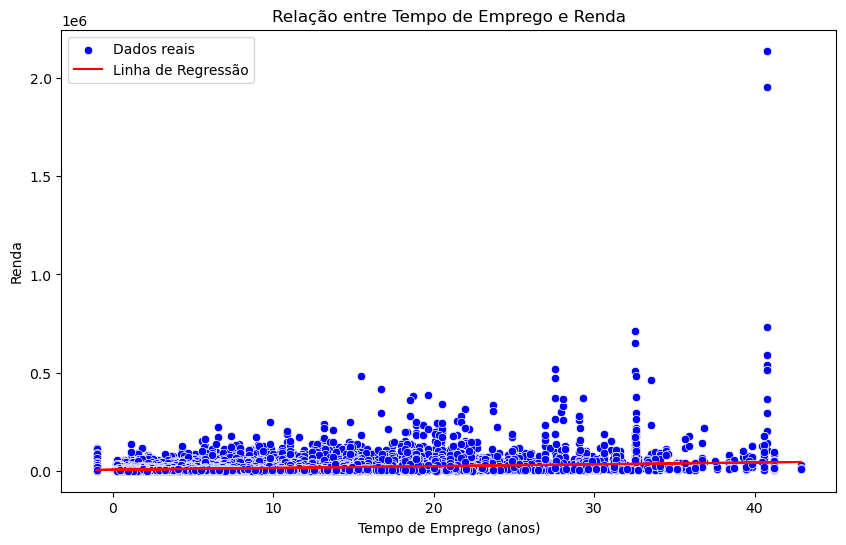

In [14]:
X = df['tempo_emprego']
y = df['renda']

X_with_const = sm.add_constant(X)

model = sm.OLS(y, X_with_const).fit()

y_pred = model.predict(X_with_const)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X, y=y, color='blue', label='Dados reais')

plt.plot(X, y_pred, color='red', label='Linha de Regressão')

plt.xlabel('Tempo de Emprego (anos)')
plt.ylabel('Renda')
plt.title('Relação entre Tempo de Emprego e Renda')
plt.legend()

plt.show()

## Algelin

### Diminuindo Correlações

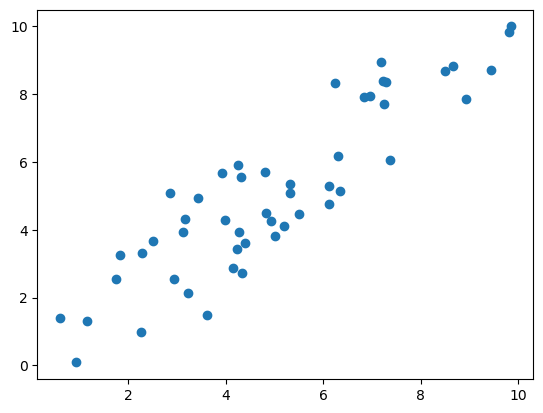

In [15]:
np.random.seed(123)

p1 = np.random.random(50) *10
p1[p1>10] = 10
p1[p1<0] = 0

p2 = p1 + np.random.normal(0,1,50)
p2[p2>10] = 10
p2[p2<0] = 0

df = pd.DataFrame({'p1': p1, 'p2': p2})
plt.scatter(x = df.p1, y=df.p2);

In [16]:
df['média'] = df.mean(axis=1)
df['evolução'] = df.p2-df.p1
df.style.format(precision=1, decimal=',')

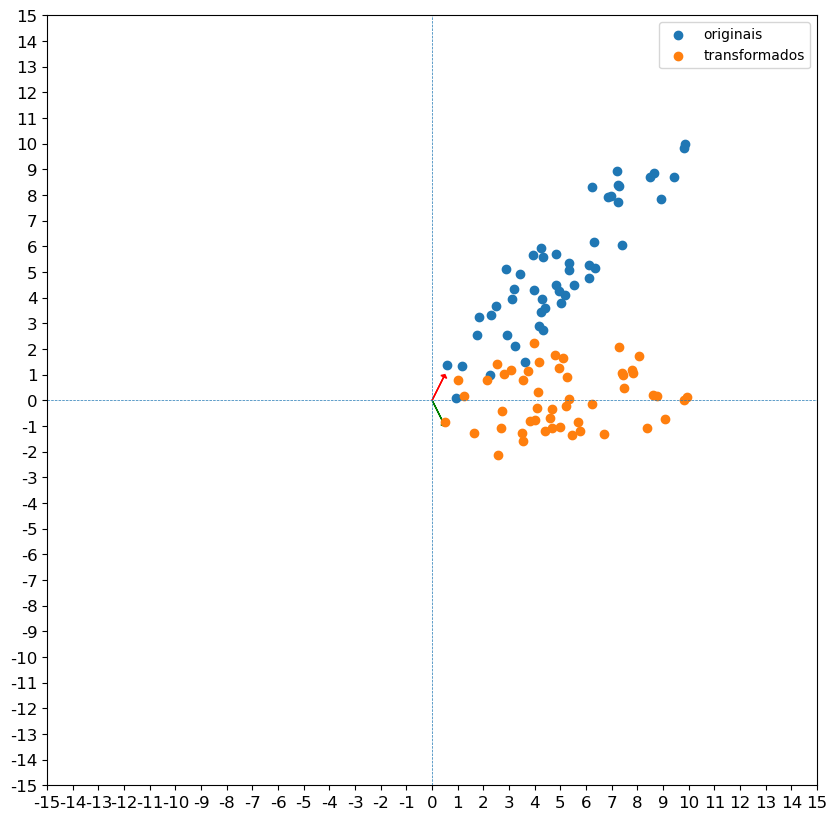

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)

xmin = -15
xmax = 15
ymin = -15
ymax = 15

# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

lista_xticks = list(range(int(xmin), int(xmax)+1))
ticksx = ax.set_xticks(lista_xticks)
labelsx = ax.set_xticklabels(lista_xticks, fontsize='large')

lista_yticks = list(range(int(ymin), int(ymax)+1))
ticksy = ax.set_yticks(lista_yticks)
labelsy = ax.set_yticklabels(lista_yticks, fontsize='large')

#Matriz de transformação
m = np.array([[ .5,.5],
              [ -1, 1]])

# Vetores coluna da matriz de transformação
ax.arrow(0, 0, m[0,0], m[1,0]
         , head_width=0.25
         , head_length=0.1
         , fc='g', ec='g', 
         length_includes_head=True)
ax.arrow(0, 0, m[0,1], m[1,1]
         , head_width=0.25
         , head_length=0.1
         , fc='r', ec='r', 
         length_includes_head=True)


#linhas horizontais e verticais de referência
ax.axvline(0, linewidth=.5, linestyle='--')
ax.axhline(0, linewidth=.5, linestyle='--')

#Transformação linear
df_rot = np.matmul(m, df[['p1', 'p2']].to_numpy().transpose())

# Plotar os dados originais
plt.scatter(df['p1'], df['p2'], label='originais')

# Plotar os dados transformados
plt.scatter(df_rot[0,:], df_rot[1,:], label='transformados')

#Legenda
plt.legend()

In [18]:
cor_p1p2 = df[['p1', 'p2']].corr(numeric_only=True)
cor_p1p2

p1        p2
p1  1.000000  0.895737
p2  0.895737  1.000000

### Soma e diferença

In [19]:
df['soma'] = df.p1+df.p2
df.style.format(precision=1, decimal=',')

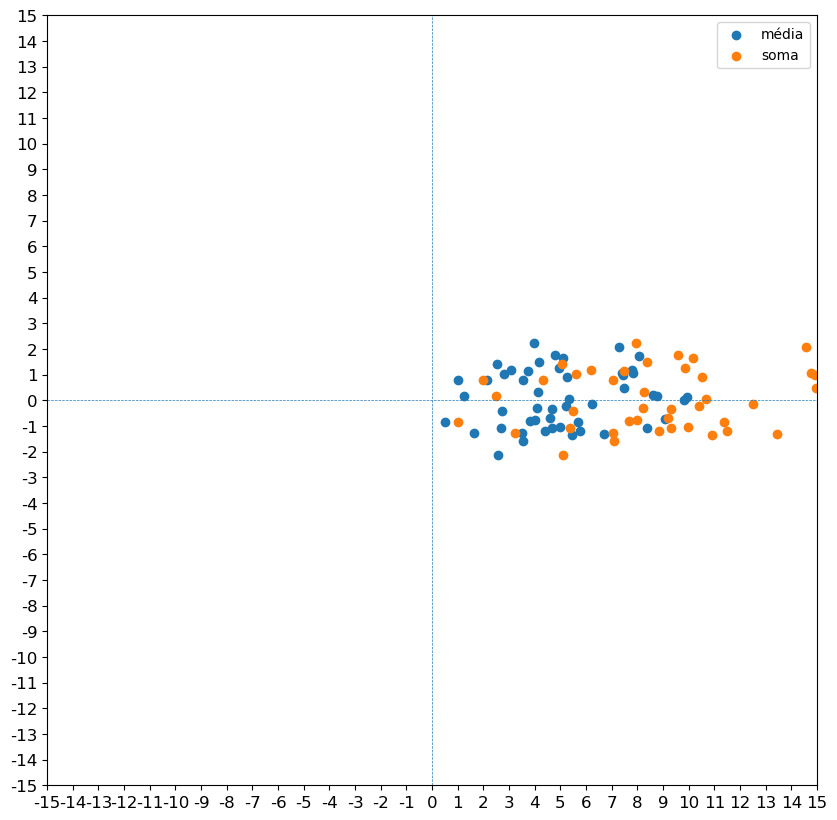

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)

xmin = -15
xmax = 15
ymin = -15
ymax = 15

# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

lista_xticks = list(range(int(xmin), int(xmax)+1))
ticksx = ax.set_xticks(lista_xticks)
labelsx = ax.set_xticklabels(lista_xticks, fontsize='large')

lista_yticks = list(range(int(ymin), int(ymax)+1))
ticksy = ax.set_yticks(lista_yticks)
labelsy = ax.set_yticklabels(lista_yticks, fontsize='large')

#Matriz de transformação
m = np.array([[ .5,.5],
              [ -1, 1]])

ax.axvline(0, linewidth=.5, linestyle='--')
ax.axhline(0, linewidth=.5, linestyle='--')

# Plotar a média
plt.scatter(df['média'], df['evolução'], label='média')

# Plotar a soma
plt.scatter(df['soma'], df['evolução'], label='soma')
#Legenda
plt.legend()

## PCA

### Árvore de decisão

In [21]:
%%time
clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(X_train, y_train)
print(X_train.shape)
print(y_train.shape)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

(42000, 24)
(42000, 1)
0.9303095238095238
0.9316111111111111
CPU times: total: 46.9 ms
Wall time: 225 ms


### Árvore com PCA

In [22]:
%%time
prcomp = PCA().fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste = prcomp.transform(X_test)

print(pc_treino.shape)
print(pc_teste.shape)

(42000, 24)
(18000, 24)
CPU times: total: 93.8 ms
Wall time: 76.7 ms


In [23]:
n = 1

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:, :n], columns=colunas)
pc_test = pd.DataFrame(pc_teste[:, :n], columns=colunas)

pc_train.head()

cp1
0  -0.754152
1  -6.834381
2   9.291479
3  21.250558
4  -2.759301

In [24]:
%%time
clf_pca = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_train, y_train)

CPU times: total: 359 ms
Wall time: 245 ms


In [25]:
print(clf_pca.score(pc_train, y_train))
print(clf_pca.score(pc_test, y_test))

0.9303095238095238
0.9316111111111111


### Testando o número de componentes

In [26]:
%%time
prcomp = PCA().fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste = prcomp.transform(X_test)

CPU times: total: 109 ms
Wall time: 84.7 ms


In [27]:
%%time

lista = [1, 3, 6, 12, 24]
score_train = []
score_test = []

for n in lista:
    colunas = ['cp'+str(x+1) for x in list(range(n))]

    pc_train = pd.DataFrame(pc_treino[:, :n], columns=colunas)
    pc_test = pd.DataFrame(pc_teste[:, :n], columns=colunas)

    clf = DecisionTreeClassifier(random_state=100, ccp_alpha=0.001).fit(pc_train, y_train)

    s_tr = clf.score(pc_train, y_train)
    score_train.append(s_tr)

    s_te = clf.score(pc_test, y_test)
    score_test.append(s_te)

CPU times: total: 1.75 s
Wall time: 3.14 s


In [28]:
resultados = {'quantidade_componentes': lista, 'score_treino': score_train, 'score_teste': score_test}

df = pd.DataFrame(resultados)
df

quantidade_componentes  score_treino  score_teste
0                       1       0.93031     0.931611
1                       3       0.93031     0.931611
2                       6       0.93031     0.931611
3                      12       0.93031     0.931611
4                      24       0.93031     0.931611

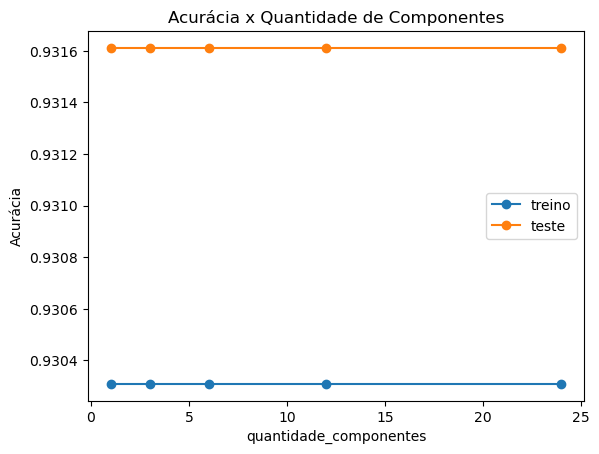

In [29]:
fig, ax = plt.subplots()

ax.set_xlabel("quantidade_componentes")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x Quantidade de Componentes")
ax.plot(df['quantidade_componentes'], df['score_treino'], marker='o', label="treino", drawstyle="steps-post")
ax.plot(df['quantidade_componentes'], df['score_teste'], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

In [30]:
%%time

n = 10

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:, :n], columns=colunas)
pc_test = pd.DataFrame(pc_teste[:, :n], columns=colunas)

clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_train, y_train)

CPU times: total: 297 ms
Wall time: 664 ms


### PCA com variáveis padronizadas

In [31]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: total: 31.2 ms
Wall time: 107 ms


0         1         2         3         4         5         6         7   \
0  1.0 -0.697838 -0.792954  0.701688 -0.021274 -0.547852 -0.447706  3.232667   
1  1.0 -0.697838 -0.792954 -1.425100 -0.021274  1.825268 -0.447706 -0.309335   
2  1.0 -0.697838 -0.792954  0.701688 -0.021274 -0.547852 -0.447706 -0.309335   
3  1.0 -0.697838 -0.792954  0.701688 -0.021274 -0.547852 -0.447706 -0.309335   
4  1.0  1.432964  1.261077 -1.425100 -0.021274 -0.547852 -0.447706 -0.309335   

         8         9   ...        14        15        16        17        18  \
0 -0.033112  0.697008  ... -0.286012 -0.206264  0.331784 -0.213315 -0.067944   
1 -0.033112  0.697008  ... -0.286012 -0.206264  0.331784 -0.213315 -0.067944   
2 -0.033112  0.697008  ... -0.286012 -0.206264  0.331784 -0.213315 -0.067944   
3 -0.033112  0.697008  ... -0.286012 -0.206264  0.331784 -0.213315 -0.067944   
4 -0.033112 -1.434670  ... -0.286012 -0.206264  0.331784 -0.213315 -0.067944   

         19        20        21        22        23  
0 -0.081034 -0.177509  0.770576 -0.067170 -0.235874  
1 -0.081034 -0.177509  2.131960 -0.601665  1.990100  
2 -0.081034 -0.177509 -0.590808  0.823654 -1.348860  
3 -0.081034 -0.177509 -0.590808  1.892643 -0.235874  
4 -0.081034 -0.177509 -0.590808 -0.245335 -0.235874  

[5 rows x 24 columns]

In [32]:
%%time
pca_X_train = PCA().fit(X_train)

CPU times: total: 62.5 ms
Wall time: 68.1 ms


In [33]:
%%time
pca_X_train_pad = PCA().fit(X_train_pad)

CPU times: total: 62.5 ms
Wall time: 56.5 ms


In [34]:
print(pca_X_train.explained_variance_[0:10])
print("")
print(pca_X_train.explained_variance_.cumsum()[0:10])
print("")
print(pca_X_train.explained_variance_ratio_[0:10])
print("")
print(pca_X_train.explained_variance_ratio_.cumsum()[0:10])

[1.26277622e+02 1.13352108e+00 3.90948257e-01 2.94184734e-01
 2.25609947e-01 1.79078281e-01 1.44036474e-01 1.35483591e-01
 1.05837033e-01 9.34088027e-02]

[126.27762171 127.41114279 127.80209105 128.09627578 128.32188573
 128.50096401 128.64500048 128.78048407 128.8863211  128.97972991]

[9.76347416e-01 8.76410532e-03 3.02271547e-03 2.27456378e-03
 1.74436044e-03 1.38458908e-03 1.11365448e-03 1.04752570e-03
 8.18305825e-04 7.22213817e-04]

[0.97634742 0.98511152 0.98813424 0.9904088  0.99215316 0.99353775
 0.9946514  0.99569893 0.99651724 0.99723945]


In [35]:
print(pca_X_train_pad.explained_variance_[0:10])
print("")
print(pca_X_train_pad.explained_variance_.cumsum()[0:10])
print("")
print(pca_X_train_pad.explained_variance_ratio_[0:10])
print("")
print(pca_X_train_pad.explained_variance_ratio_.cumsum()[0:10])

[2.906803   1.9769748  1.91879442 1.43389226 1.23724976 1.12846294
 1.11186185 1.06553146 1.04470095 1.01411807]

[ 2.906803    4.8837778   6.80257222  8.23646447  9.47371423 10.60217717
 11.71403902 12.77957048 13.82427144 14.83838951]

[0.12638274 0.08595543 0.08342584 0.06234314 0.05379347 0.04906361
 0.04834182 0.04632745 0.04542178 0.04409209]

[0.12638274 0.21233817 0.29576401 0.35810715 0.41190062 0.46096422
 0.50930604 0.5556335  0.60105528 0.64514737]


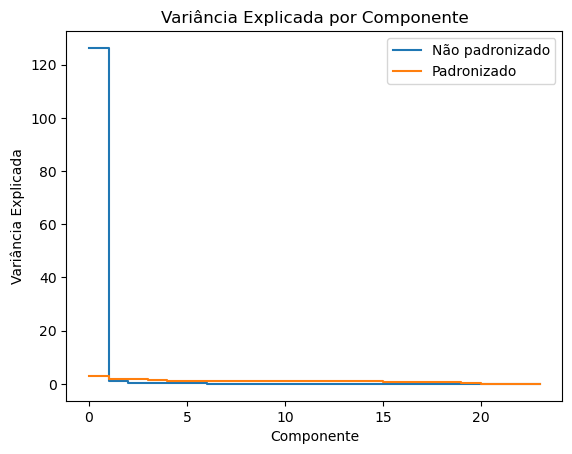

In [36]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Explicada")
ax.set_title("Variância Explicada por Componente")
ax.plot(pca_X_train.explained_variance_, label="Não padronizado", drawstyle="steps-post")
ax.plot(pca_X_train_pad.explained_variance_, label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

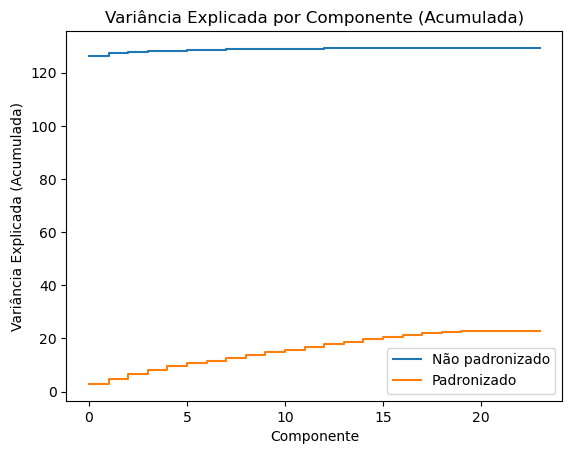

In [37]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Explicada (Acumulada)")
ax.set_title("Variância Explicada por Componente (Acumulada)")
ax.plot(pca_X_train.explained_variance_.cumsum(), label="Não padronizado", drawstyle="steps-post")
ax.plot(pca_X_train_pad.explained_variance_.cumsum(), label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

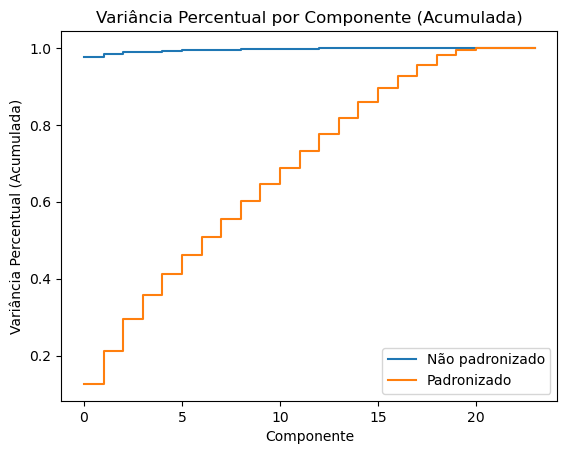

In [38]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Percentual (Acumulada)")
ax.set_title("Variância Percentual por Componente (Acumulada)")
ax.plot(pca_X_train.explained_variance_ratio_.cumsum(), label="Não padronizado",    drawstyle="steps-post")
ax.plot(pca_X_train_pad.explained_variance_ratio_.cumsum(), label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

In [39]:
ncomp_crit = (pca_X_train.explained_variance_ratio_.cumsum() < .90).sum()+1

print(f'Número de componentes para dados não padronizados: {ncomp_crit}')

Número de componentes para dados não padronizados: 1


In [40]:
ncomp_crit = (pca_X_train_pad.explained_variance_ratio_.cumsum() < .90).sum()+1

print(f'Número de componentes para dados padronizados: {ncomp_crit}')

Número de componentes para dados padronizados: 17


### Árvore com PCA

In [41]:
%%time

pc_treino = pca_X_train.transform(X_train)
pc_teste = pca_X_train.transform(X_test)

n = 10

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:, :n], columns=colunas)
pc_test = pd.DataFrame(pc_teste[:, :n], columns=colunas)

clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_train, y_train)

acc_treino = clf.score(pc_train, y_train)
acc_teste = clf.score(pc_test, y_test)

print(f'A acurácia na base de treino sem padronização é: {acc_treino*100:.2f}%')
print(f'A acurácia na base de teste sem padronização é: {acc_teste*100:.2f}%')

A acurácia na base de treino sem padronização é: 93.03%
A acurácia na base de teste sem padronização é: 93.16%
CPU times: total: 891 ms
Wall time: 717 ms


In [42]:
%%time

pc_treino_pad = pca_X_train_pad.transform(X_train)
pc_teste_pad = pca_X_train_pad.transform(X_test)

n = 10

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train_pad = pd.DataFrame(pc_treino_pad[:, :n], columns=colunas)
pc_test_pad = pd.DataFrame(pc_teste_pad[:, :n], columns=colunas)

clf_pad = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_train_pad, y_train)

acc_treino_pad = clf_pad.score(pc_train_pad, y_train)
acc_teste_pad = clf_pad.score(pc_test_pad, y_test)

print(f'A acurácia base de treino com padronização é: {acc_treino_pad*100:.2f}%')
print(f'A acurácia base de teste com padronização é: {acc_teste_pad*100:.2f}%')

A acurácia base de treino com padronização é: 93.03%
A acurácia base de teste com padronização é: 93.16%
CPU times: total: 656 ms
Wall time: 659 ms


In [43]:
print(f"A acurácia da base de treino padronizada foi {((acc_treino - acc_treino_pad) / acc_treino_pad)*100:.2f}% menor comparada a base sem padronização.")
print("")
print(f"A acurácia da base de teste padronizada foi {((acc_teste - acc_teste_pad) / acc_teste_pad)*100:.2f}% menor comparada a base sem padronização.")

A acurácia da base de treino padronizada foi 0.00% menor comparada a base sem padronização.

A acurácia da base de teste padronizada foi 0.00% menor comparada a base sem padronização.


## K-means

In [44]:
df = pd.read_csv('credit_scoring.csv')

In [45]:
df.head()

data_ref  id_cliente sexo  posse_de_veiculo  posse_de_imovel  qtd_filhos  \
0  2015-01-01           1    F              True             True           0   
1  2015-01-01           2    M              True            False           0   
2  2015-01-01           3    F              True            False           0   
3  2015-01-01           4    F             False             True           0   
4  2015-01-01           5    F             False            False           0   

    tipo_renda           educacao estado_civil tipo_residencia  idade  \
0  Assalariado         Secundário       Casado            Casa     49   
1   Empresário         Secundário        União            Casa     60   
2   Empresário         Secundário       Casado            Casa     28   
3  Assalariado  Superior completo       Casado            Casa     60   
4   Empresário         Secundário       Casado            Casa     47   

   tempo_emprego  qt_pessoas_residencia    renda  mau  
0       8.605479                    2.0  1916.54    0  
1       6.953425                    2.0  2967.25    0  
2       0.682192                    2.0   340.96    0  
3       1.879452                    2.0  4903.16    0  
4       8.438356                    2.0  3012.60    0

In [46]:
df.mau.value_counts(dropna=False)

mau
0    69774
1     5226
Name: count, dtype: int64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               75000 non-null  object 
 1   id_cliente             75000 non-null  int64  
 2   sexo                   75000 non-null  object 
 3   posse_de_veiculo       75000 non-null  bool   
 4   posse_de_imovel        75000 non-null  bool   
 5   qtd_filhos             75000 non-null  int64  
 6   tipo_renda             75000 non-null  object 
 7   educacao               75000 non-null  object 
 8   estado_civil           75000 non-null  object 
 9   tipo_residencia        75000 non-null  object 
 10  idade                  75000 non-null  int64  
 11  tempo_emprego          62529 non-null  float64
 12  qt_pessoas_residencia  75000 non-null  float64
 13  renda                  75000 non-null  float64
 14  mau                    75000 non-null  int64  
dtypes:

In [48]:
df.isnull().sum()

data_ref                     0
id_cliente                   0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            12471
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

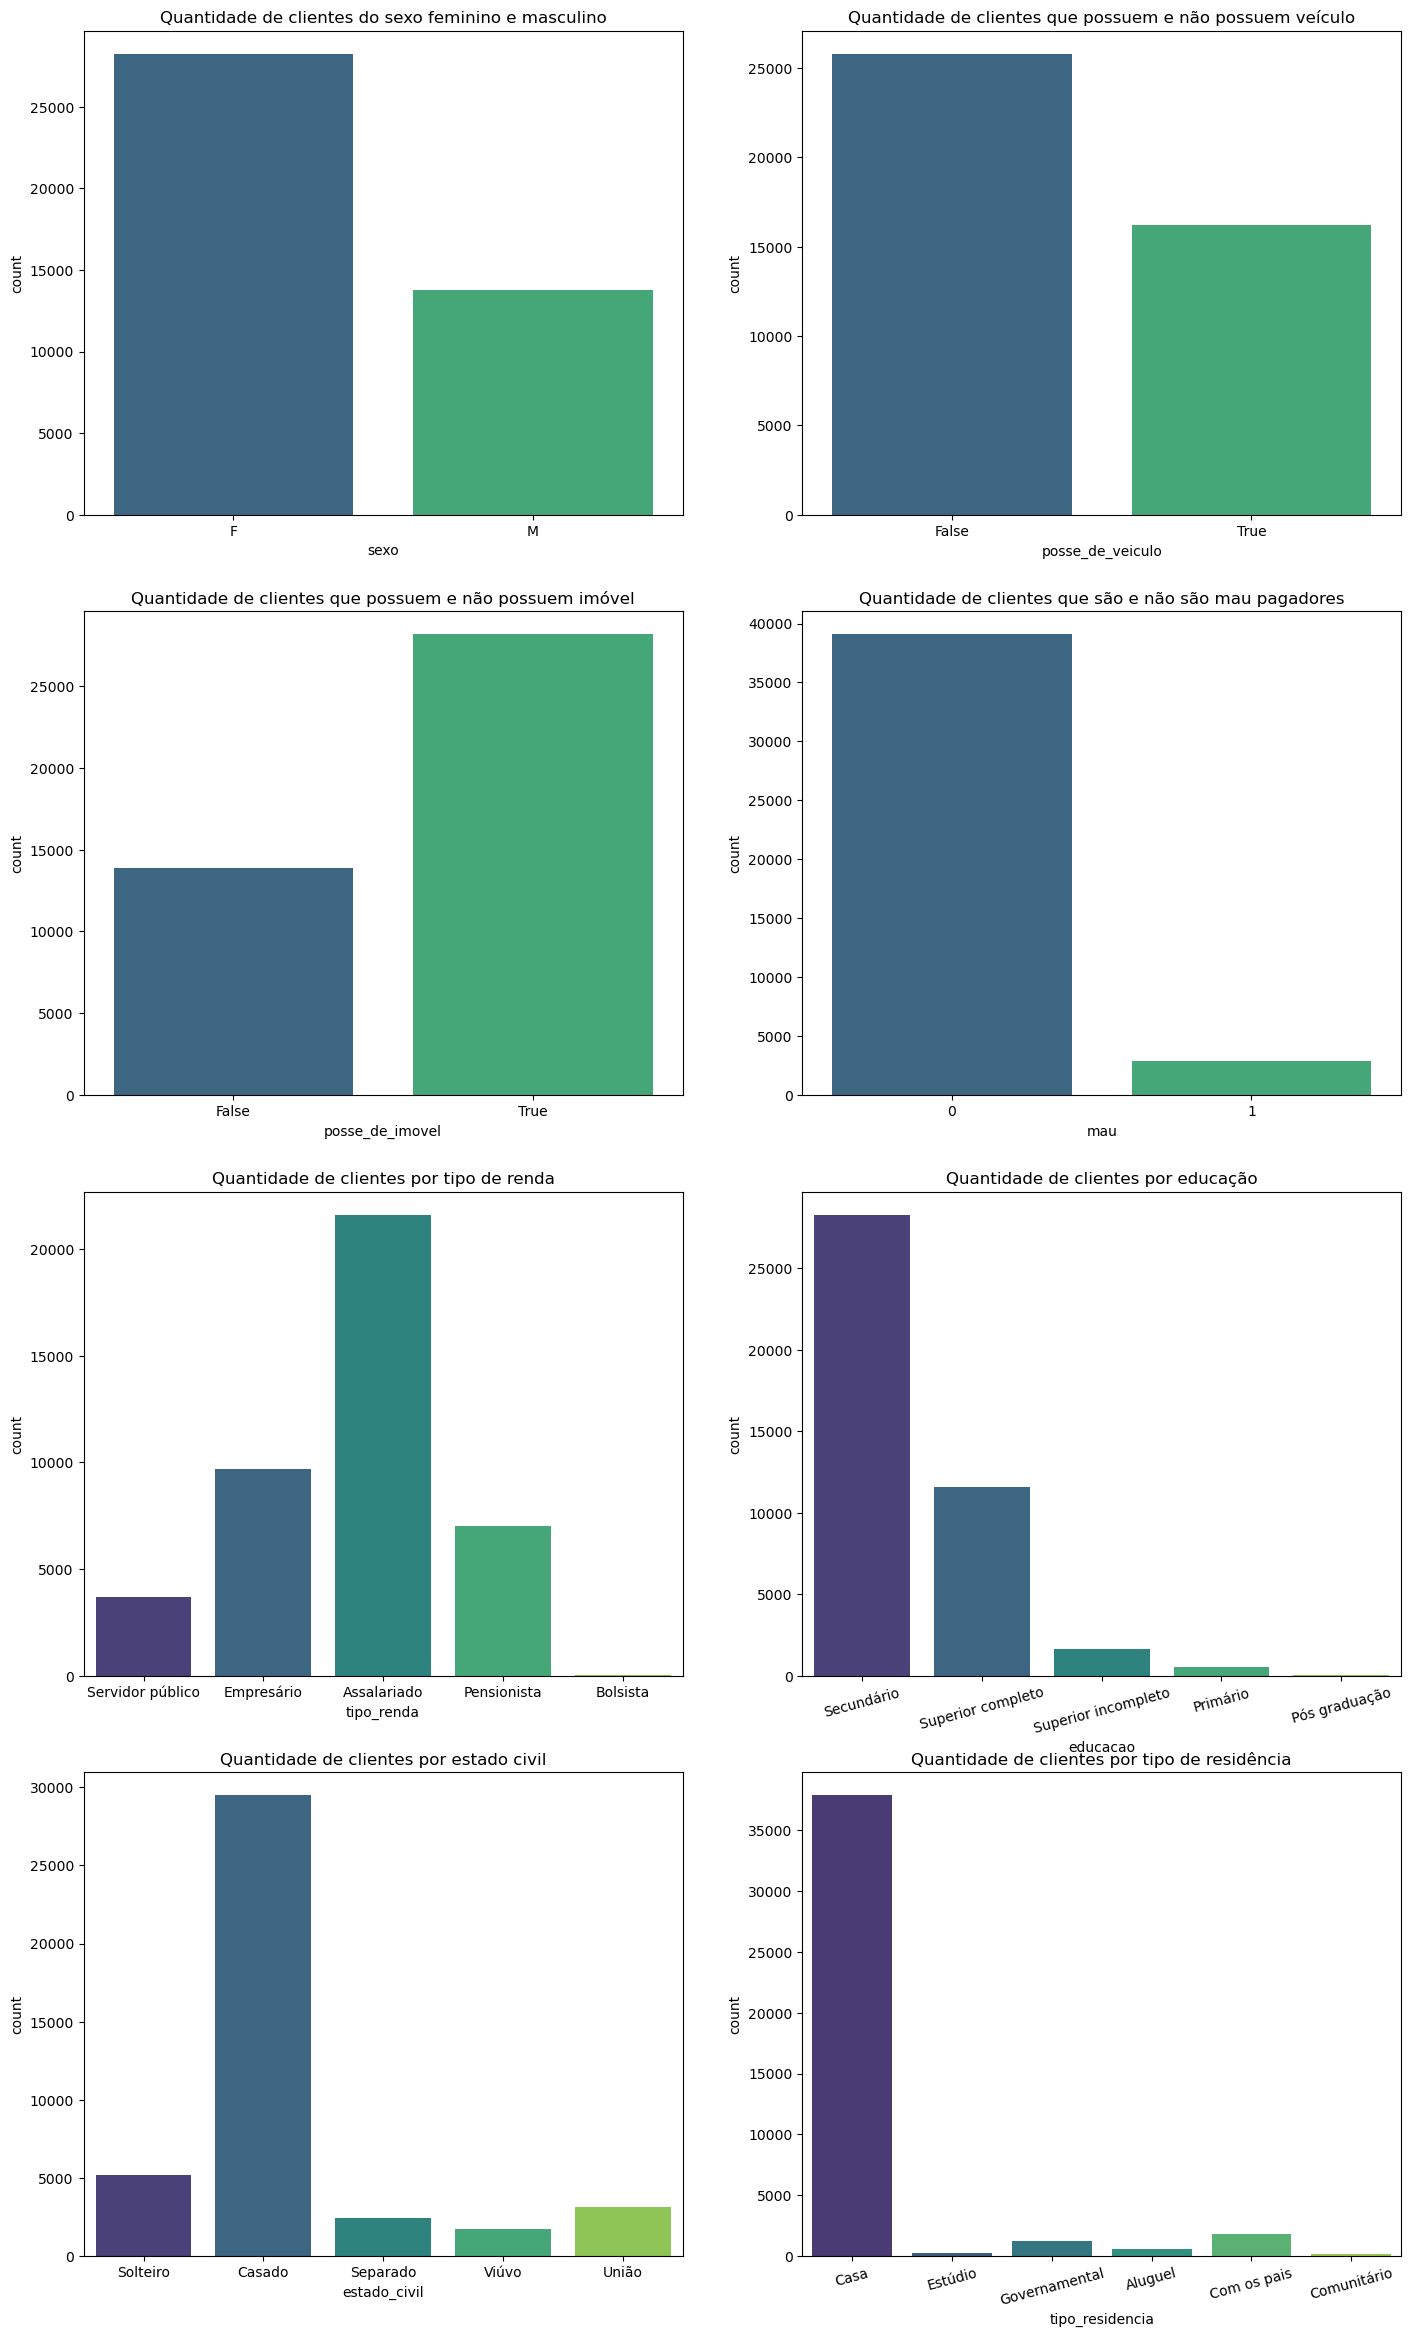

In [49]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(17, 28.9))

sns.countplot(data=df_train, x='sexo', palette='viridis', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de clientes do sexo feminino e masculino')

sns.countplot(data=df_train, x='posse_de_veiculo', palette='viridis', ax=ax[0, 1])
ax[0, 1].set_title('Quantidade de clientes que possuem e não possuem veículo')

sns.countplot(data=df_train, x='posse_de_imovel', palette='viridis', ax=ax[1, 0])
ax[1, 0].set_title('Quantidade de clientes que possuem e não possuem imóvel')

sns.countplot(data=df_train, x='mau', palette='viridis', ax=ax[1, 1])
ax[1, 1].set_title('Quantidade de clientes que são e não são mau pagadores')

sns.countplot(data=df_train, x='tipo_renda', palette='viridis', ax=ax[2, 0])
ax[2, 0].set_title('Quantidade de clientes por tipo de renda')

sns.countplot(data=df_train, x='educacao', palette='viridis', ax=ax[2, 1])
ax[2, 1].set_title('Quantidade de clientes por educação')
for tick in ax[2, 1].get_xticklabels():
    tick.set_rotation(15)

sns.countplot(data=df_train, x='estado_civil', palette='viridis', ax=ax[3, 0])
ax[3, 0].set_title('Quantidade de clientes por estado civil')

sns.countplot(data=df_train, x='tipo_residencia', palette='viridis', ax=ax[3, 1])
ax[3, 1].set_title('Quantidade de clientes por tipo de residência')
for tick in ax[3, 1].get_xticklabels():
    tick.set_rotation(15)

In [50]:
df.columns

Index(['data_ref', 'id_cliente', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [51]:
df.dtypes

data_ref                  object
id_cliente                 int64
sexo                      object
posse_de_veiculo            bool
posse_de_imovel             bool
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                        int64
dtype: object

In [52]:
variaveis = ['qtd_filhos','idade','tempo_emprego', 'qt_pessoas_residencia','renda', 'mau']

In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
df_padrao = pd.DataFrame(StandardScaler().fit_transform(df[variaveis]), columns=df[variaveis].columns)
df_padrao.head()

qtd_filhos     idade  tempo_emprego  qt_pessoas_residencia     renda  \
0   -0.584416  0.461931       0.125539              -0.233576 -0.357484   
1   -0.584416  1.440160      -0.121415              -0.233576 -0.305882   
2   -0.584416 -1.405598      -1.058860              -0.233576 -0.434863   
3   -0.584416  1.440160      -0.879890              -0.233576 -0.210807   
4   -0.584416  0.284071       0.100557              -0.233576 -0.303655   

        mau  
0 -0.273677  
1 -0.273677  
2 -0.273677  
3 -0.273677  
4 -0.273677

In [55]:
df_padrao = df_padrao.dropna()

In [56]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # Ou 'median', 'most_frequent'
df_padrao = pd.DataFrame(imputer.fit_transform(df_padrao), columns=df_padrao.columns)

In [57]:
from tqdm import tqdm
from sklearn.cluster import KMeans

In [58]:
%%time
SQD = []
K = range(1,15)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(df_padrao)
    SQD.append(km.inertia_)

  0%|          | 0/14 [00:00<?, ?it/s]C:\Users\natha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\natha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
100%|██████████| 14/14 [00:03<00:00,  4.27it/s]

CPU times: total: 12.3 s
Wall time: 3.29 s


In [59]:
SQD

[375309.2500135723,
 275273.2065759956,
 221517.1568568188,
 180819.66334754493,
 161086.5719015273,
 143333.55907392877,
 136792.49175746442,
 106613.42997376555,
 99897.34385329203,
 97041.3995564961,
 82715.31931248533,
 81465.69968588409,
 75464.70600215184,
 73335.18678675666]

<Axes: xlabel='num_clusters'>

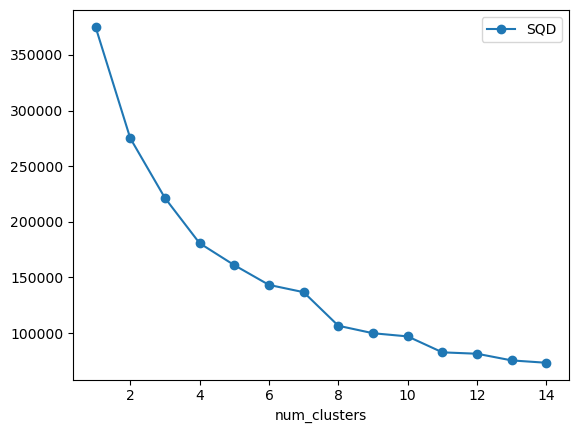

In [60]:
df_graf = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
df_graf.plot(x='num_clusters', y='SQD', marker='o')

In [61]:
from sklearn.metrics import silhouette_score

In [62]:
%%time
# Inicializar uma lista vazia que vai conter os valores da silueta média
siluetas = []
# Este é o número máximo de grupos que vamos testar
max_clusters = 10

# O loop percorre de 2 até o máximo de clusters
for n_clusters in tqdm(range(2, max_clusters+1)):
    # Aqui rodamos o k-means
    km = KMeans(n_clusters=n_clusters).fit(df_padrao[variaveis])
    # Aqui calculamos a silueta e guardamos o resultado na lista 'siluetas'
    siluetas.append(silhouette_score(df_padrao[variaveis], km.labels_))
    # Essa list comprehendion define o nome dos grupos
    nomes_grupos = ['grupo_' + str(g) for g in range(n_clusters)]
    # Agora vamos adicionar uma coluna no dataframe X_pad com o agrupamento construido
    df_padrao['grupos_'+str(n_clusters)] = pd.Categorical.from_codes(km.labels_, categories = nomes_grupos)

df_padrao.head()

100%|██████████| 9/9 [12:39<00:00, 84.39s/it]

CPU times: total: 14min 16s
Wall time: 12min 39s


qtd_filhos     idade  tempo_emprego  qt_pessoas_residencia     renda  \
0   -0.584416  0.461931       0.125539              -0.233576 -0.357484   
1   -0.584416  1.440160      -0.121415              -0.233576 -0.305882   
2   -0.584416 -1.405598      -1.058860              -0.233576 -0.434863   
3   -0.584416  1.440160      -0.879890              -0.233576 -0.210807   
4   -0.584416  0.284071       0.100557              -0.233576 -0.303655   

        mau grupos_2 grupos_3 grupos_4 grupos_5 grupos_6 grupos_7 grupos_8  \
0 -0.273677  grupo_0  grupo_0  grupo_1  grupo_2  grupo_0  grupo_6  grupo_0   
1 -0.273677  grupo_0  grupo_0  grupo_1  grupo_2  grupo_0  grupo_6  grupo_0   
2 -0.273677  grupo_0  grupo_0  grupo_1  grupo_0  grupo_0  grupo_0  grupo_5   
3 -0.273677  grupo_0  grupo_0  grupo_1  grupo_2  grupo_0  grupo_6  grupo_0   
4 -0.273677  grupo_0  grupo_0  grupo_1  grupo_2  grupo_0  grupo_6  grupo_0   

  grupos_9 grupos_10  
0  grupo_2   grupo_0  
1  grupo_2   grupo_0  
2  grupo_5   grupo_6  
3  grupo_2   grupo_0  
4  grupo_2   grupo_0

<Axes: xlabel='n_clusters'>

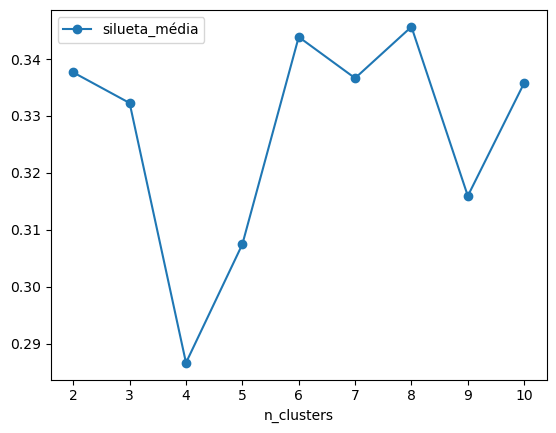

In [63]:
df_silueta = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silueta_média': siluetas})

df_silueta.plot.line(x = 'n_clusters', y = 'silueta_média', marker='o')
# plt.scatter(x = df_silueta.n_clusters, y = df_silueta.silueta_média)

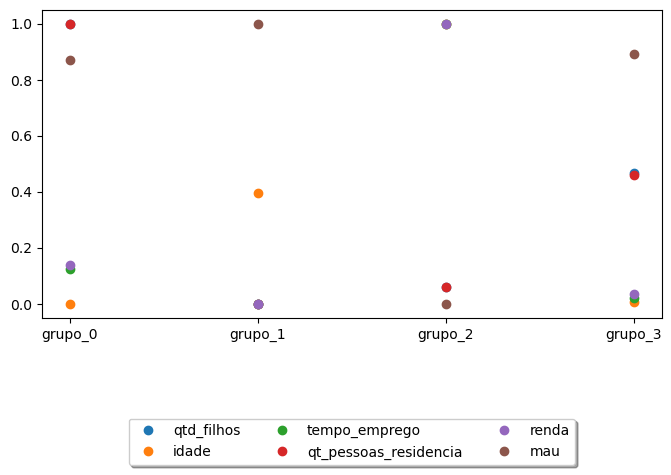

In [64]:
padroniza = lambda x: (x - x.min())/(x.max() - x.min())

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_padrao.groupby(['grupos_4'])[variaveis].mean().apply(padroniza), 'o ')
ax.legend(variaveis, loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True)

### Avaliação dos grupos

CPU times: total: 2min 17s
Wall time: 2min 39s


C:\Users\natha\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


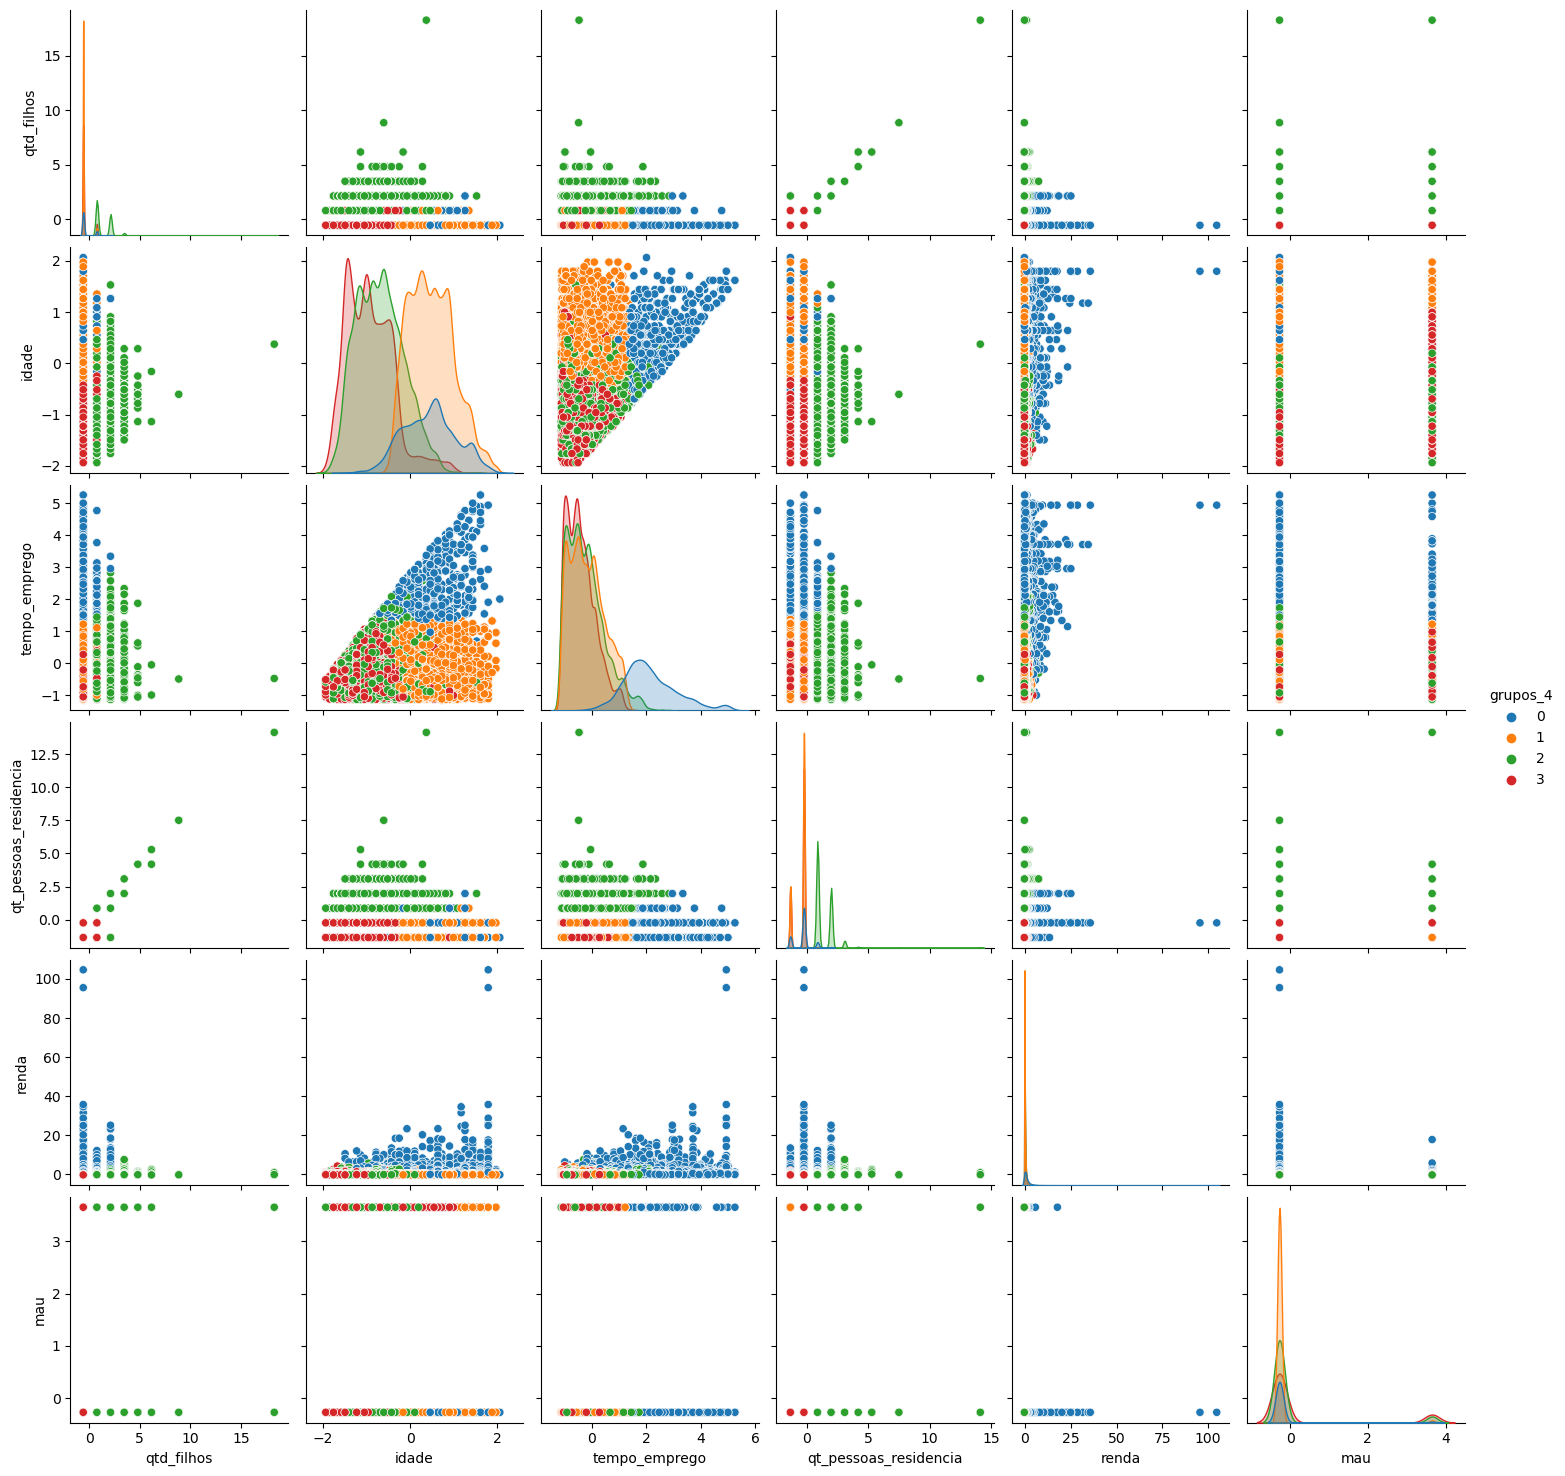

In [65]:
%%time
cluster_4 = KMeans(n_clusters=4)
cluster_4.fit_predict(df_padrao[variaveis])

df_padrao['grupos_4'] = pd.Categorical(cluster_4.labels_)

sns.pairplot(df_padrao, hue='grupos_4')

### Avaliação de resultados

<Axes: xlabel='tempo_emprego', ylabel='grupos_4'>

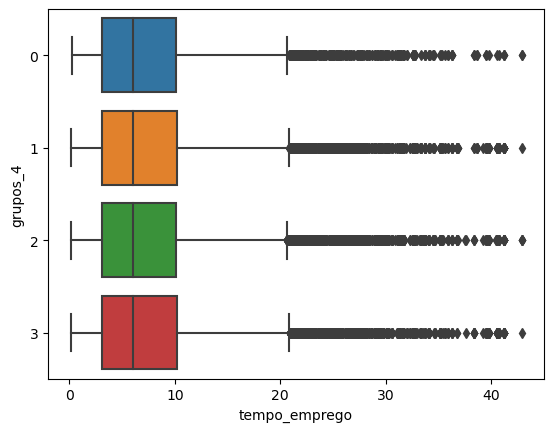

In [66]:
df_padrao['renda'] = df['renda']
df_padrao['tempo_emprego'] = df['tempo_emprego']

sns.boxplot(data=df_padrao, y='grupos_4', x='tempo_emprego')

In [67]:
pd.crosstab(df_padrao.tempo_emprego, df_padrao.grupos_4)

grupos_4       0   1   2   3
tempo_emprego               
0.117808       0   1   0   3
0.178082       0   2   0   0
0.191781       0   1   3   3
0.200000       4   8   7  13
0.216438       0   0   1   1
...           ..  ..  ..  ..
40.479452      0   0   2   0
40.575342      1   7   6  11
40.786301      1   5   4   4
41.200000      3  21  13  14
42.906849      2   1   4   1

[2989 rows x 4 columns]

In [68]:
pd.crosstab(df_padrao.tempo_emprego, df_padrao.grupos_4, normalize='columns')

grupos_4              0         1         2         3
tempo_emprego                                        
0.117808       0.000000  0.000063  0.000000  0.000207
0.178082       0.000000  0.000126  0.000000  0.000000
0.191781       0.000000  0.000063  0.000186  0.000207
0.200000       0.000704  0.000504  0.000435  0.000898
0.216438       0.000000  0.000000  0.000062  0.000069
...                 ...       ...       ...       ...
40.479452      0.000000  0.000000  0.000124  0.000000
40.575342      0.000176  0.000441  0.000372  0.000760
40.786301      0.000176  0.000315  0.000248  0.000276
41.200000      0.000528  0.001324  0.000807  0.000967
42.906849      0.000352  0.000063  0.000248  0.000069

[2989 rows x 4 columns]

## Inferência

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          750000 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 96.2+ MB


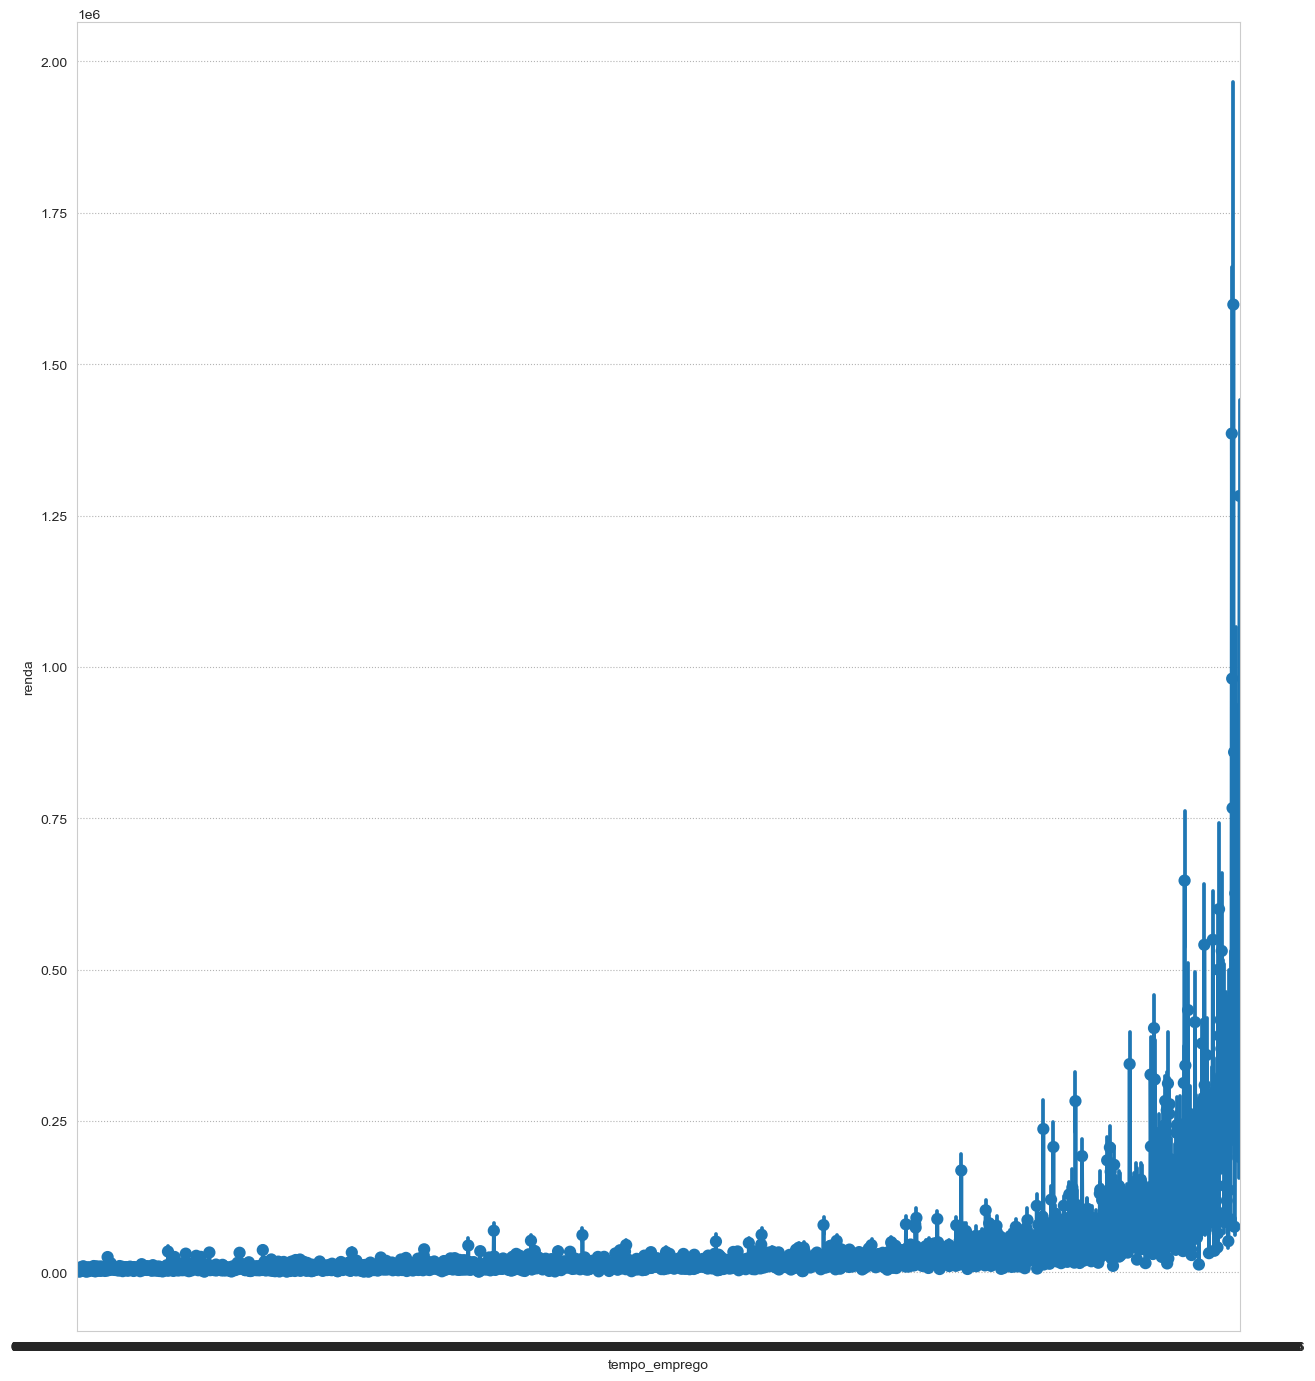

In [213]:
plt.rc('figure', figsize=(15, 17))
sns.pointplot(x='tempo_emprego', y='renda', data=df)
plt.show()

In [202]:
from scipy.stats import ttest_ind, f_oneway

grupo1 = df[df['tempo_emprego'] <= 5]['renda']
grupo2 = df[df['tempo_emprego'] > 5]['renda']
t_stat, p_value = ttest_ind(grupo1, grupo2)

print('t-statistic:', t_stat)
print('p-value:', p_value)

grupo1 = df[df['tempo_emprego'] <= 5]['renda']
grupo2 = df[(df['tempo_emprego'] > 5) & (df['tempo_emprego'] <= 10)]['renda']
grupo3 = df[df['tempo_emprego'] > 10]['renda']
f_stat, p_value = f_oneway(grupo1, grupo2, grupo3)

print('F-statistic:', f_stat)
print('p-value:', p_value)

t-statistic: -116.96151401354902
p-value: 0.0
F-statistic: 33795.526738535424
p-value: 0.0


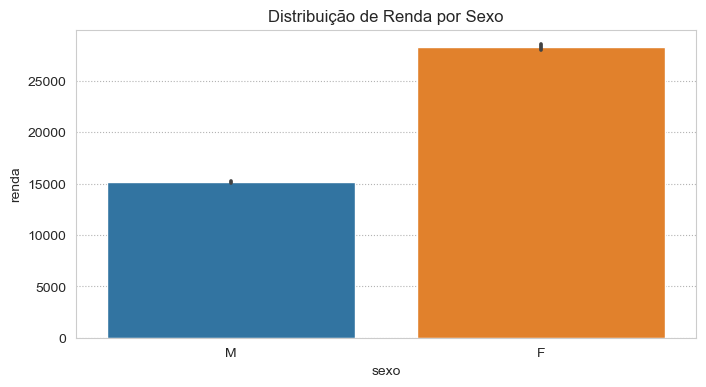

In [210]:
fig, ax = plt.subplots(figsize=(8,4), sharey=True)
sns.barplot(x='sexo', y='renda', data=df)
plt.title('Distribuição de Renda por Sexo')
plt.show()

In [204]:
renda_homens = df[df['sexo'] == 'M']['renda']
renda_mulheres = df[df['sexo'] == 'F']['renda']

# Teste t de Student
t_stat, p_value = ttest_ind(renda_homens, renda_mulheres, equal_var=False)  
print('t-statistic:', t_stat)
print('p-value:', p_value)

t-statistic: -81.2717268973398
p-value: 0.0


## Regressão

In [70]:
df = pd.read_csv('credit_scoring.csv')
df.head()

data_ref  id_cliente sexo  posse_de_veiculo  posse_de_imovel  qtd_filhos  \
0  2015-01-01           1    F              True             True           0   
1  2015-01-01           2    M              True            False           0   
2  2015-01-01           3    F              True            False           0   
3  2015-01-01           4    F             False             True           0   
4  2015-01-01           5    F             False            False           0   

    tipo_renda           educacao estado_civil tipo_residencia  idade  \
0  Assalariado         Secundário       Casado            Casa     49   
1   Empresário         Secundário        União            Casa     60   
2   Empresário         Secundário       Casado            Casa     28   
3  Assalariado  Superior completo       Casado            Casa     60   
4   Empresário         Secundário       Casado            Casa     47   

   tempo_emprego  qt_pessoas_residencia    renda  mau  
0       8.605479                    2.0  1916.54    0  
1       6.953425                    2.0  2967.25    0  
2       0.682192                    2.0   340.96    0  
3       1.879452                    2.0  4903.16    0  
4       8.438356                    2.0  3012.60    0

In [71]:
reg = smf.ols('renda ~ tempo_emprego', data=df).fit()
df['res_renda'] = reg.resid
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     4802.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:09:48   Log-Likelihood:            -7.1158e+05
No. Observations:               62529   AIC:                         1.423e+06
Df Residuals:                   62527   BIC:                         1.423e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3036.2417    129.813     23.389      0.000    2781.808    3290.675
tempo_emprego   877.6586     12.665     69.298      0.000     852.835     902.482
==============================================================================
Omnibus:                   172206.907   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      19780733410.951
Skew:                          34.453   Prob(JB):                         0.00
Kurtosis:                    2757.547   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

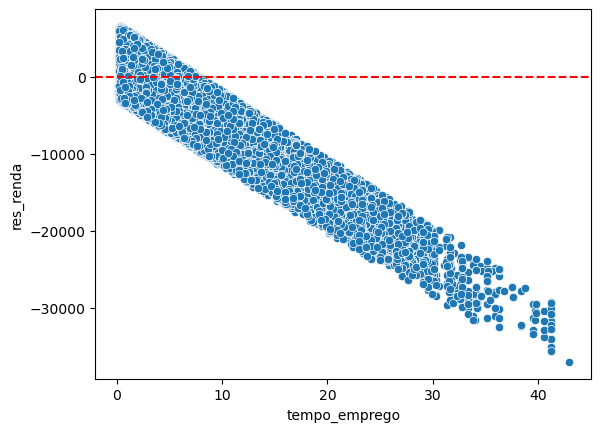

In [72]:
plt.close('all')
sns.scatterplot(x='tempo_emprego', y='res_renda', data=df[df['renda'] < 10000])
plt.axhline(y=0, color='r', linestyle='--')

In [73]:
reg_2 = smf.ols('np.log(renda) ~ tempo_emprego', data=df).fit()
df['res_renda_2'] = reg_2.resid
reg_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     7302.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:09:49   Log-Likelihood:                -93442.
No. Observations:               62529   AIC:                         1.869e+05
Df Residuals:                   62527   BIC:                         1.869e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.0791      0.007   1222.719      0.000       8.066       8.092
tempo_emprego     0.0551      0.001     85.454      0.000       0.054       0.056
==============================================================================
Omnibus:                      206.338   Durbin-Watson:                   1.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.660
Skew:                           0.037   Prob(JB):                     4.77e-36
Kurtosis:                       2.761   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
df.columns

Index(['data_ref', 'id_cliente', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'res_renda', 'res_renda_2'],
      dtype='object')

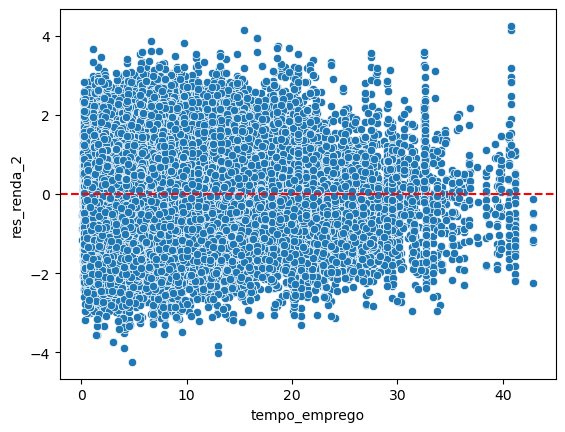

In [75]:
plt.close('all')
sns.scatterplot(x='tempo_emprego', y='res_renda_2', data=df)
plt.axhline(y=0, color='r', linestyle='--')

In [76]:
print(f"O R² do segundo modelo diminuiu, porém, o 'coef' e 'std err' se aproximaram de 0.")
print(f"R² do Modelo 1: {reg.rsquared*100:.2f}%")
print(f"R² do Modelo 2: {reg_2.rsquared*100:.2f}%")

O R² do segundo modelo diminuiu, porém, o 'coef' e 'std err' se aproximaram de 0.
R² do Modelo 1: 7.13%
R² do Modelo 2: 10.46%


In [77]:
reg_renda_multi = smf.ols('renda ~ data_ref + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + mau', data=df).fit()
df['res_renda_multi'] = reg_renda_multi.resid
reg_renda_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     417.0
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:09:54   Log-Likelihood:            -7.0666e+05
No. Observations:               62529   AIC:                         1.413e+06
Df Residuals:                   62489   BIC:                         1.414e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                        -1.786e+04   2884.916     -6.191      0.000   -2.35e+04   -1.22e+04
data_ref[T.2015-02-01]            1481.8136    429.427      3.451      0.001     640.135    2323.492
data_ref[T.2015-03-01]            3368.1916    429.376      7.844      0.000    2526.615    4209.769
data_ref[T.2015-04-01]            7147.2945    429.047     16.659      0.000    6306.362    7988.227
data_ref[T.2015-05-01]            1.104e+04    429.606     25.705      0.000    1.02e+04    1.19e+04
data_ref[T.2015-06-01]            1.547e+04    429.105     36.046      0.000    1.46e+04    1.63e+04
data_ref[T.2015-07-01]            1.824e+04    428.245     42.588      0.000    1.74e+04    1.91e+04
data_ref[T.2015-08-01]            1.512e+04    428.578     35.276      0.000    1.43e+04     1.6e+04
data_ref[T.2015-09-01]            1.112e+04    428.244     25.955      0.000    1.03e+04     1.2e+04
data_ref[T.2015-10-01]            6719.2084    428.602     15.677      0.000    5879.147    7559.270
data_ref[T.2015-11-01]            3799.4189    427.877      8.880      0.000    2960.779    4638.059
data_ref[T.2015-12-01]            1548.1056    429.412      3.605      0.000     706.457    2389.755
data_ref[T.2016-01-01]              39.9147    428.038      0.093      0.926    -799.040     878.870
data_ref[T.2016-02-01]            -687.7408    429.030     -1.603      0.109   -1528.640     153.158
data_ref[T.2016-03-01]           -1168.6043    428.675     -2.726      0.006   -2008.807    -328.401
sexo[T.M]                         1.019e+04    177.860     57.269      0.000    9837.204    1.05e+04
posse_de_veiculo[T.True]           315.1825    171.972      1.833      0.067     -21.883     652.248
posse_de_imovel[T.True]            494.7219    169.275      2.923      0.003     162.942     826.501
tipo_renda[T.Bolsista]           -3048.0530   3644.848     -0.836      0.403   -1.02e+04    4095.857
tipo_renda[T.Empresário]          1177.3101    181.598      6.483      0.000     821.378    1533.242
tipo_renda[T.Pensionista]        -4069.2030   3414.466     -1.192      0.233   -1.08e+04    2623.156
tipo_renda[T.Servidor público]    -886.6944    266.284     -3.330      0.001   -1408.612    -364.777
educacao[T.Pós graduação]          540.8798   2373.637      0.228      0.820   -4111.454    5193.213
educacao[T.Secundário]              84.7898    878.914      0.096      0.923   -1637.883    1807.462
educacao[T.Superior completo]     1619.1827    886.013      1.827      0.068    -117.405    3355.770
educacao[T.Superior incompleto]    870.9017    949.619      0.917      0.359    -990.352    2732.156
estado_civil[T.Separado]          1650.3786   1362.195      1.212      0.226   -1019.526    4320.283
estado_civil[T.Solteiro]          2713.0960   1329.80

In [78]:
reg_renda_multi_2 = smf.ols('np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel + np.power(idade, 2) + tempo_emprego',data=df).fit()
df['res_renda_multi_2'] = reg_renda_multi_2.resid
reg_renda_multi_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     3672.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:09:54   Log-Likelihood:                -88846.
No. Observations:               62529   AIC:                         1.777e+05
Df Residuals:                   62523   BIC:                         1.778e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    7.5459      0.012    614.192      0.000       7.522       7.570
sexo[T.M]                    0.8225      0.009     92.038      0.000       0.805       0.840
posse_de_veiculo[T.True]     0.0323      0.009      3.724      0.000       0.015       0.049
posse_de_imovel[T.True]      0.1214      0.008     14.366      0.000       0.105       0.138
np.power(idade, 2)        5.376e-05    5.4e-06      9.961      0.000    4.32e-05    6.43e-05
tempo_emprego                0.0610      0.001     95.604      0.000       0.060       0.062
==============================================================================
Omnibus:                      331.008   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.151
Skew:                          -0.011   Prob(JB):                     3.19e-52
Kurtosis:                       2.699   Cond. No.                     6.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
print(f"R² do Modelo 1: {reg_renda_multi.rsquared*100:.2f}%")
print(f"R² do Modelo 2: {reg_renda_multi_2.rsquared*100:.2f}%")

R² do Modelo 1: 20.65%
R² do Modelo 2: 22.70%


<Axes: xlabel='sexo', ylabel='res_renda_multi_2'>

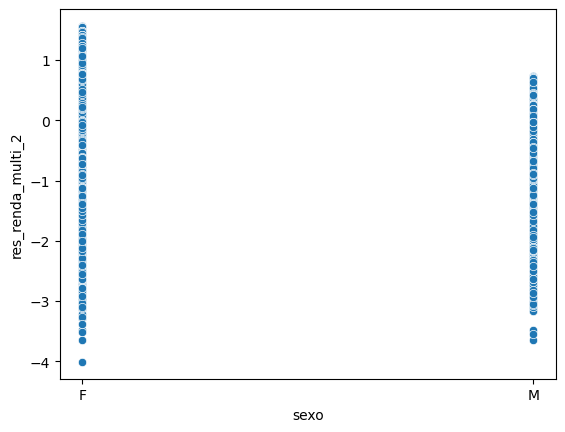

In [80]:
sns.scatterplot(x='sexo', y='res_renda_multi_2', data=df[df['renda'] < 10000])

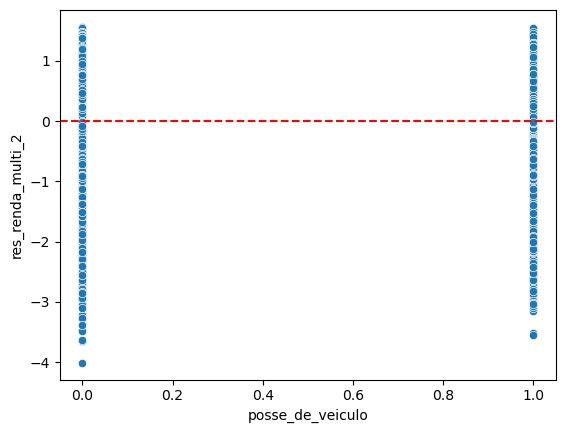

In [81]:
sns.scatterplot(x='posse_de_veiculo', y='res_renda_multi_2', data=df[df['renda'] < 10000])
plt.axhline(y=0, color='r', linestyle='--')

### Dummies

In [82]:
df_dummies = pd.get_dummies(df, drop_first=True)

In [83]:
qualitativa = df.select_dtypes(include=['object','bool'])
qualitativa.head()

data_ref sexo  posse_de_veiculo  posse_de_imovel   tipo_renda  \
0  2015-01-01    F              True             True  Assalariado   
1  2015-01-01    M              True            False   Empresário   
2  2015-01-01    F              True            False   Empresário   
3  2015-01-01    F             False             True  Assalariado   
4  2015-01-01    F             False            False   Empresário   

            educacao estado_civil tipo_residencia  
0         Secundário       Casado            Casa  
1         Secundário        União            Casa  
2         Secundário       Casado            Casa  
3  Superior completo       Casado            Casa  
4         Secundário       Casado            Casa

In [84]:
qualitativa['sexo'].value_counts()

qualitativa['posse_de_veiculo'].value_counts()

qualitativa['posse_de_imovel'].value_counts()

qualitativa['tipo_renda'].value_counts()

qualitativa['educacao'].value_counts()

qualitativa['estado_civil'].value_counts()

qualitativa['tipo_residencia'].value_counts()

tipo_residencia
Casa             67541
Com os pais       3265
Governamental     2316
Aluguel           1041
Estúdio            509
Comunitário        328
Name: count, dtype: int64

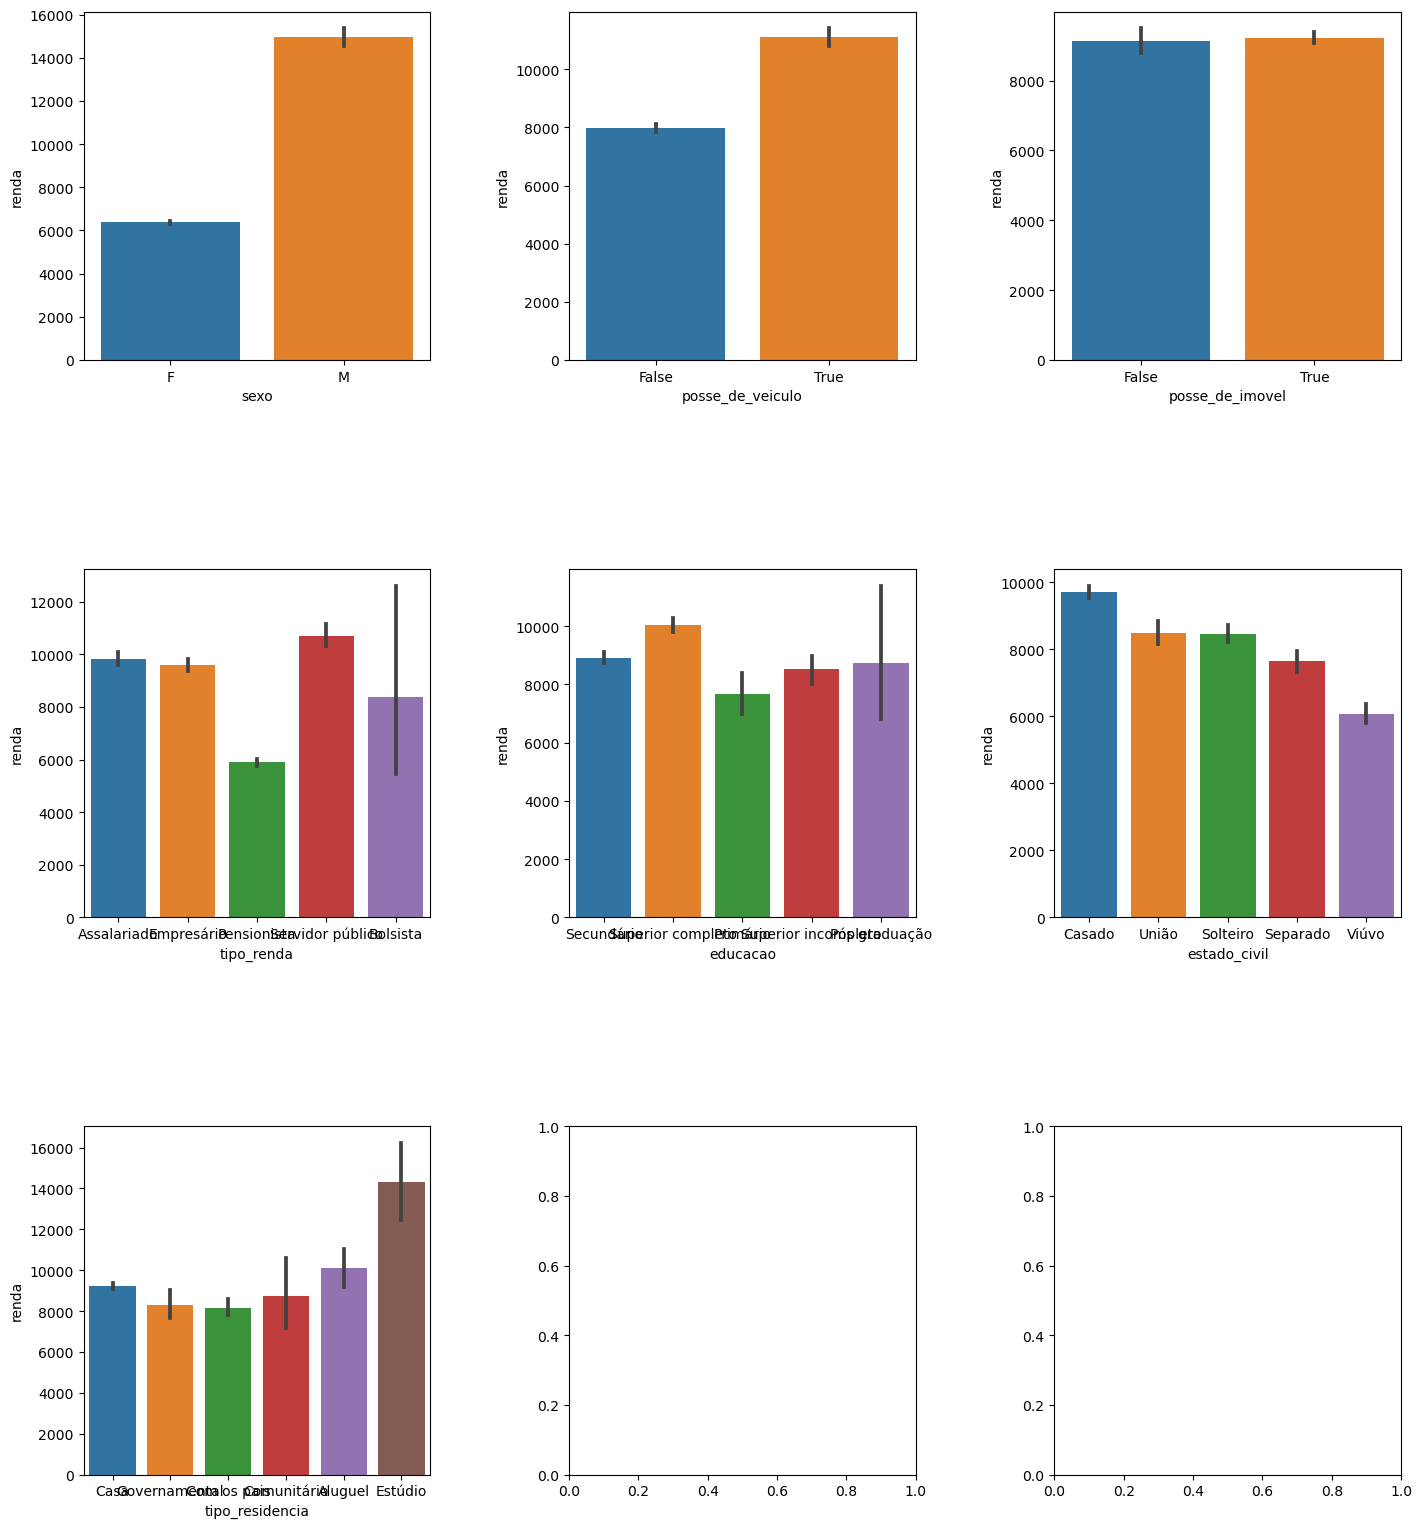

In [85]:
plt.close('all')

plt.rc('figure', figsize=(17, 19))
fig, axes = plt.subplots(3, 3)

sns.barplot(ax = axes[0, 0],y = 'renda', x = 'sexo', data = df)
sns.barplot(ax = axes[0, 1],y = 'renda', x = 'posse_de_veiculo', data = df)
sns.barplot(ax = axes[0, 2],y = 'renda', x = 'posse_de_imovel', data = df)
sns.barplot(ax = axes[1, 0],y = 'renda', x = 'tipo_renda', data = df)
sns.barplot(ax = axes[1, 1],y = 'renda', x = 'educacao', data = df)
sns.barplot(ax = axes[1, 2],y = 'renda', x = 'estado_civil', data = df)
sns.barplot(ax = axes[2, 0],y = 'renda', x = 'tipo_residencia', data = df)

plt.subplots_adjust(wspace=0.4, hspace=0.6)

In [86]:
y, x = patsy.dmatrices('''np.log(renda) ~ C(sexo, Treatment(0))
                               + C(posse_de_veiculo, Treatment(0))  
                               + C(posse_de_imovel, Treatment(0))
                               + C(tipo_renda, Treatment(1))
                               + C(educacao, Treatment(1))
                               + C(estado_civil, Treatment(1))
                               + C(tipo_residencia, Treatment(1))                                                           
                               + qtd_filhos
                               + idade
                               + tempo_emprego
                               + qt_pessoas_residencia
                       ''', data = df)
x

DesignMatrix with shape (62529, 25)
  Columns:
    ['Intercept',
     'C(sexo, Treatment(0))[T.M]',
     'C(posse_de_veiculo, Treatment(0))[T.True]',
     'C(posse_de_imovel, Treatment(0))[T.True]',
     'C(tipo_renda, Treatment(1))[T.Assalariado]',
     'C(tipo_renda, Treatment(1))[T.Empresário]',
     'C(tipo_renda, Treatment(1))[T.Pensionista]',
     'C(tipo_renda, Treatment(1))[T.Servidor público]',
     'C(educacao, Treatment(1))[T.Primário]',
     'C(educacao, Treatment(1))[T.Secundário]',
     'C(educacao, Treatment(1))[T.Superior completo]',
     'C(educacao, Treatment(1))[T.Superior incompleto]',
     'C(estado_civil, Treatment(1))[T.Casado]',
     'C(estado_civil, Treatment(1))[T.Solteiro]',
     'C(estado_civil, Treatment(1))[T.União]',
     'C(estado_civil, Treatment(1))[T.Viúvo]',
     'C(tipo_residencia, Treatment(1))[T.Aluguel]',
     'C(tipo_residencia, Treatment(1))[T.Com os pais]',
     'C(tipo_residencia, Treatment(1))[T.Comunitário]',
     'C(tipo_residencia, Treatm

In [87]:
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     804.4
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:10:12   Log-Likelihood:                -88480.
No. Observations:               62529   AIC:                         1.770e+05
Df Residuals:                   62504   BIC:                         1.772e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.2075      0.229     31.463      0.000       6.759       7.657
C(sexo, Treatment(0))[T.M]                            0.8441      0.009     93.648      0.000       0.826       0.862
C(posse_de_veiculo, Treatment(0))[T.True]             0.0111      0.009      1.265      0.206      -0.006       0.028
C(posse_de_imovel, Treatment(0))[T.True]              0.1189      0.009     13.810      0.000       0.102       0.136
C(tipo_renda, Treatment(1))[T.Assalariado]            0.0088      0.185      0.048      0.962      -0.354       0.372
C(tipo_renda, Treatment(1))[T.Empresário]             0.1684      0.185      0.908      0.364      -0.195       0.532
C(tipo_renda, Treatment(1))[T.Pensionista]           -0.3970      0.254     -1.564      0.118      -0.894       0.100
C(tipo_renda, Treatment(1))[T.Servidor público]       0.0766      0.186      0.413      0.680      -0.287       0.440
C(educacao, Treatment(1))[T.Primário]                -0.3282      0.121     -2.719      0.007      -0.565      -0.092
C(educacao, Treatment(1))[T.Secundário]              -0.2939      0.112     -2.617      0.009      -0.514      -0.074
C(educacao, Treatment(1))[T.Superior completo]       -0.1381      0.112     -1.229      0.219      -0.359       0.082
C(educacao, Treatment(1))[T.Superior incompleto]     -0.2188      0.114     -1.922      0.055      -0.442       0.004
C(estado_civil, Treatment(1))[T.Casado]              -0.2728      0.069     -3.938      0.000      -0.409      -0.137
C(estado_civil, Treatment(1))[T.Solteiro]             0.0527      0.020      2.606      0.009       0.013       0.092
C(estado_civil, Treatment(1))[T.União]               -0.2717      0.071     -3.850      0.000      -0.410      -0.133
C(estado_civil, Treatment(1))[T.Viúvo]                0.0198      0.031      0.642      0.521      -0.041       0.080
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0672      0.032      2.075      0.038       0.004       0.131
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0276      0.018      1.494      0.135      -0.009       0.064
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.0339      0.055     -0.611      0.541      -0.143       0.075
C(tipo_residencia, Treatment(1))[T.Estúdio]           0.0840      0.048      1.762      0.078      -0.009       0.178
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0121      0.023     -0.522      0.602      -0.058       0.033
qtd_filhos                                           -0.3255      0.067     -4.835      0.000      -0.457      -0.194
idade                                                 0.0061      0.000     12.398      0.000       0.005       0.007
tempo_emprego  

In [88]:
df2 = df.copy()

In [89]:
df2['tipo_renda'] = df2['tipo_renda'].apply(lambda i: i if i not in ['Empresário', 'Assalariado'] else 'Empresário/Assalariado')
df2['tipo_renda'].value_counts()

tipo_renda
Empresário/Assalariado    55899
Pensionista               12504
Servidor público           6568
Bolsista                     29
Name: count, dtype: int64

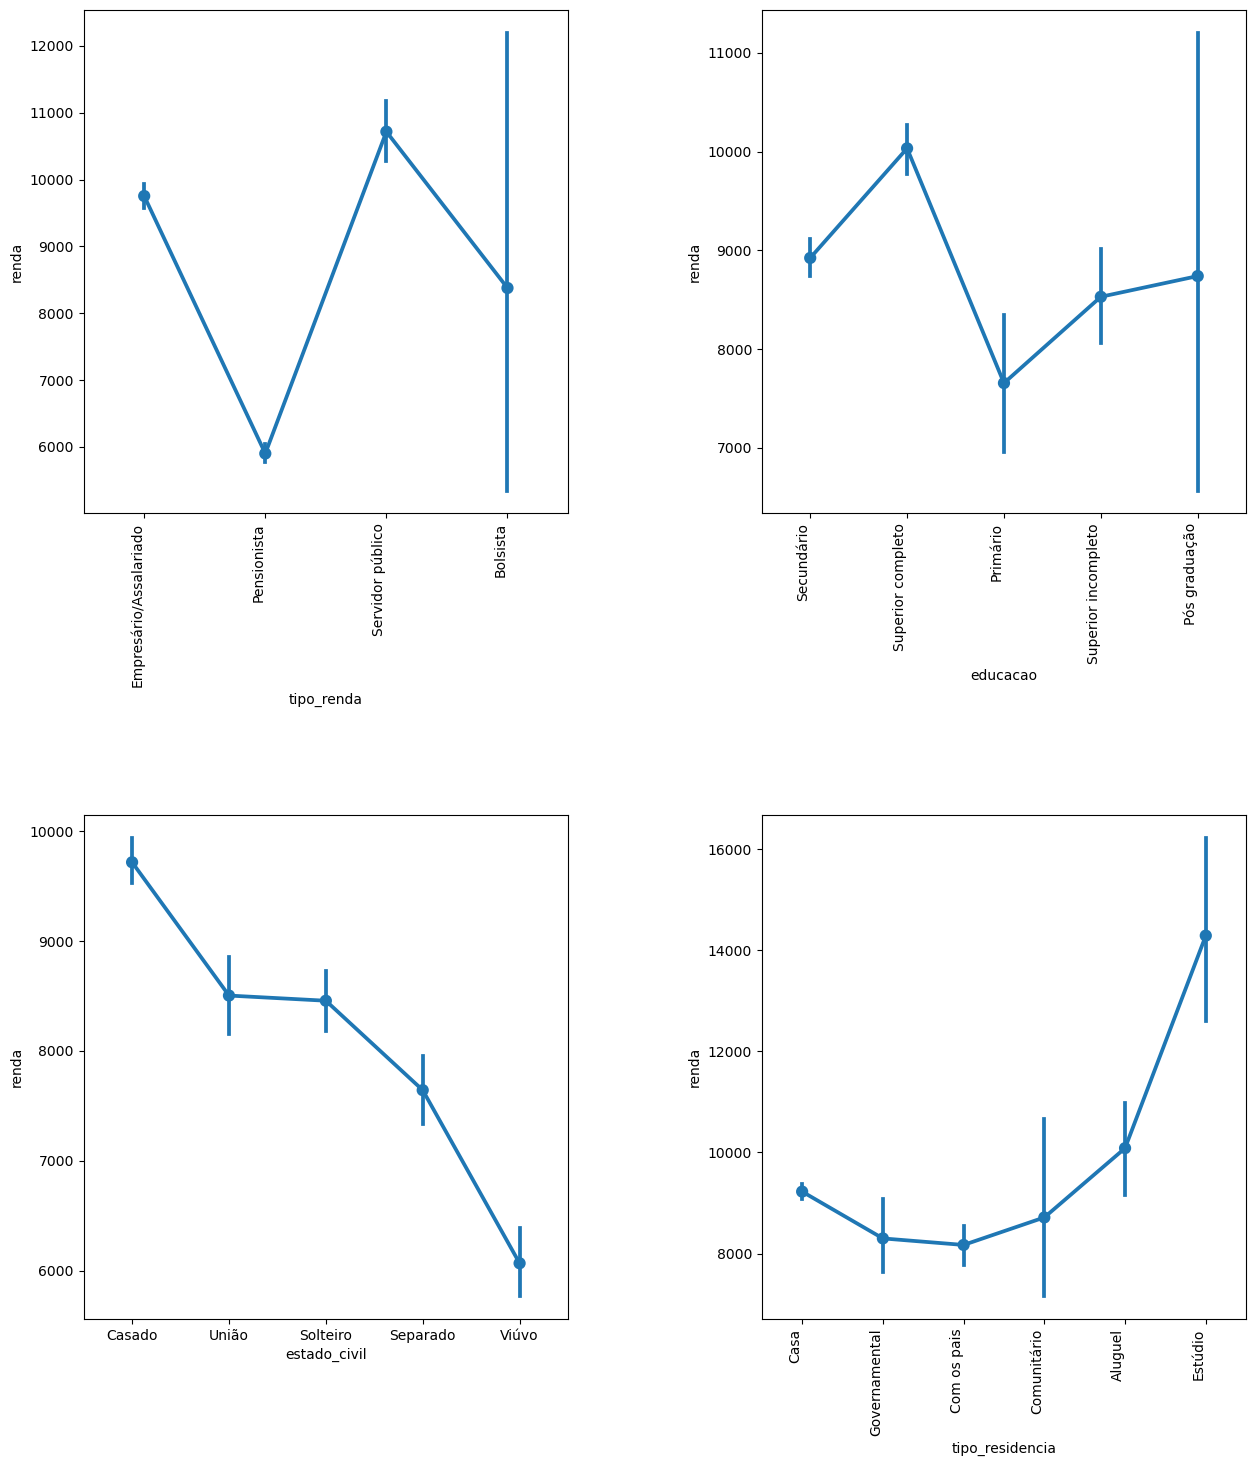

In [90]:
plt.close('all')

plt.rc('figure', figsize=(15, 17))
fig, axes = plt.subplots(2, 2)

tipo_renda = sns.pointplot(ax = axes[0, 0],y = 'renda', x = 'tipo_renda', data = df2)
educação = sns.pointplot(ax = axes[0, 1],y = 'renda', x = 'educacao', data = df2)
sns.pointplot(ax = axes[1, 0],y = 'renda', x = 'estado_civil', data = df2)
tipo_residencia = sns.pointplot(ax = axes[1, 1],y = 'renda', x = 'tipo_residencia', data = df2)

tipo_renda.set_xticklabels(tipo_renda.get_xticklabels(), rotation=90, horizontalalignment='right')
educação.set_xticklabels(educação.get_xticklabels(), rotation=90, horizontalalignment='right')
tipo_residencia.set_xticklabels(tipo_residencia.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.subplots_adjust(wspace=0.4, hspace=0.6)

In [91]:
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     804.4
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:10:19   Log-Likelihood:                -88480.
No. Observations:               62529   AIC:                         1.770e+05
Df Residuals:                   62504   BIC:                         1.772e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.2075      0.229     31.463      0.000       6.759       7.657
C(sexo, Treatment(0))[T.M]                            0.8441      0.009     93.648      0.000       0.826       0.862
C(posse_de_veiculo, Treatment(0))[T.True]             0.0111      0.009      1.265      0.206      -0.006       0.028
C(posse_de_imovel, Treatment(0))[T.True]              0.1189      0.009     13.810      0.000       0.102       0.136
C(tipo_renda, Treatment(1))[T.Assalariado]            0.0088      0.185      0.048      0.962      -0.354       0.372
C(tipo_renda, Treatment(1))[T.Empresário]             0.1684      0.185      0.908      0.364      -0.195       0.532
C(tipo_renda, Treatment(1))[T.Pensionista]           -0.3970      0.254     -1.564      0.118      -0.894       0.100
C(tipo_renda, Treatment(1))[T.Servidor público]       0.0766      0.186      0.413      0.680      -0.287       0.440
C(educacao, Treatment(1))[T.Primário]                -0.3282      0.121     -2.719      0.007      -0.565      -0.092
C(educacao, Treatment(1))[T.Secundário]              -0.2939      0.112     -2.617      0.009      -0.514      -0.074
C(educacao, Treatment(1))[T.Superior completo]       -0.1381      0.112     -1.229      0.219      -0.359       0.082
C(educacao, Treatment(1))[T.Superior incompleto]     -0.2188      0.114     -1.922      0.055      -0.442       0.004
C(estado_civil, Treatment(1))[T.Casado]              -0.2728      0.069     -3.938      0.000      -0.409      -0.137
C(estado_civil, Treatment(1))[T.Solteiro]             0.0527      0.020      2.606      0.009       0.013       0.092
C(estado_civil, Treatment(1))[T.União]               -0.2717      0.071     -3.850      0.000      -0.410      -0.133
C(estado_civil, Treatment(1))[T.Viúvo]                0.0198      0.031      0.642      0.521      -0.041       0.080
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0672      0.032      2.075      0.038       0.004       0.131
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0276      0.018      1.494      0.135      -0.009       0.064
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.0339      0.055     -0.611      0.541      -0.143       0.075
C(tipo_residencia, Treatment(1))[T.Estúdio]           0.0840      0.048      1.762      0.078      -0.009       0.178
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0121      0.023     -0.522      0.602      -0.058       0.033
qtd_filhos                                           -0.3255      0.067     -4.835      0.000      -0.457      -0.194
idade                                                 0.0061      0.000     12.398      0.000       0.005       0.007
tempo_emprego  

In [92]:
qualitativa = df.select_dtypes(include=['int64','float64'])
qualitativa.head()

id_cliente  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  \
0           1           0     49       8.605479                    2.0   
1           2           0     60       6.953425                    2.0   
2           3           0     28       0.682192                    2.0   
3           4           0     60       1.879452                    2.0   
4           5           0     47       8.438356                    2.0   

     renda  mau    res_renda  res_renda_2  res_renda_multi  res_renda_multi_2  
0  1916.54    0 -8672.374416    -0.994916       587.947262          -0.795018  
1  2967.25    0 -6171.724379    -0.466793     -8848.750013          -1.022820  
2   340.96    0 -3294.013146    -2.284951      7903.103099          -1.830171  
3  4903.16    0   217.401123     0.314965      7608.584214           0.522224  
4  3012.60    0 -7429.637231    -0.533427      1673.738519          -0.168622

In [93]:
qualitativa['qtd_filhos'].value_counts()

qtd_filhos
0     51799
1     15121
2      7099
3       844
4       108
5        13
14       10
7         6
Name: count, dtype: int64

In [94]:
idade = qualitativa['idade'].value_counts()
idade.head()

idade
40    2457
37    2378
39    2323
32    2273
33    2224
Name: count, dtype: int64

In [95]:
tempo_emprego = qualitativa['tempo_emprego'].value_counts()
tempo_emprego.head()

tempo_emprego
4.216438    160
6.934247    144
4.797260    136
0.547945    132
5.216438    126
Name: count, dtype: int64

In [96]:
qt_pessoas = qualitativa['qt_pessoas_residencia'].value_counts()
qt_pessoas.head()

qt_pessoas_residencia
2.0    40902
1.0    13588
3.0    12771
4.0     6801
5.0      801
Name: count, dtype: int64

In [97]:
y, x = patsy.dmatrices('''np.log(renda) ~ C(sexo, Treatment(0))
                               + C(posse_de_veiculo, Treatment(0))  
                               + C(posse_de_imovel, Treatment(0))
                               + C(tipo_renda, Treatment(1))
                               + C(educacao, Treatment(1))
                               + C(estado_civil, Treatment(1))
                               + C(tipo_residencia, Treatment(1))                                                           
                               + C(qtd_filhos, Treatment(2))    
                               + idade
                               + tempo_emprego
                               + C(qt_pessoas_residencia, Treatment(2))    
                       ''', data = df2)
x

DesignMatrix with shape (62529, 37)
  Columns:
    ['Intercept',
     'C(sexo, Treatment(0))[T.M]',
     'C(posse_de_veiculo, Treatment(0))[T.True]',
     'C(posse_de_imovel, Treatment(0))[T.True]',
     'C(tipo_renda, Treatment(1))[T.Bolsista]',
     'C(tipo_renda, Treatment(1))[T.Pensionista]',
     'C(tipo_renda, Treatment(1))[T.Servidor público]',
     'C(educacao, Treatment(1))[T.Primário]',
     'C(educacao, Treatment(1))[T.Secundário]',
     'C(educacao, Treatment(1))[T.Superior completo]',
     'C(educacao, Treatment(1))[T.Superior incompleto]',
     'C(estado_civil, Treatment(1))[T.Casado]',
     'C(estado_civil, Treatment(1))[T.Solteiro]',
     'C(estado_civil, Treatment(1))[T.União]',
     'C(estado_civil, Treatment(1))[T.Viúvo]',
     'C(tipo_residencia, Treatment(1))[T.Aluguel]',
     'C(tipo_residencia, Treatment(1))[T.Com os pais]',
     'C(tipo_residencia, Treatment(1))[T.Comunitário]',
     'C(tipo_residencia, Treatment(1))[T.Estúdio]',
     'C(tipo_residencia, Treatme

In [98]:
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     574.6
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:10:23   Log-Likelihood:                -88611.
No. Observations:               62529   AIC:                         1.773e+05
Df Residuals:                   62495   BIC:                         1.776e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.3397      0.142     51.563      0.000       7.061       7.619
C(sexo, Treatment(0))[T.M]                            0.8377      0.009     92.679      0.000       0.820       0.855
C(posse_de_veiculo, Treatment(0))[T.True]             0.0130      0.009      1.485      0.137      -0.004       0.030
C(posse_de_imovel, Treatment(0))[T.True]              0.1192      0.009     13.789      0.000       0.102       0.136
C(tipo_renda, Treatment(1))[T.Bolsista]              -0.0688      0.186     -0.370      0.711      -0.433       0.295
C(tipo_renda, Treatment(1))[T.Pensionista]           -0.4723      0.174     -2.713      0.007      -0.814      -0.131
C(tipo_renda, Treatment(1))[T.Servidor público]       0.0194      0.013      1.461      0.144      -0.007       0.045
C(educacao, Treatment(1))[T.Primário]                -0.3647      0.121     -3.012      0.003      -0.602      -0.127
C(educacao, Treatment(1))[T.Secundário]              -0.3148      0.113     -2.794      0.005      -0.536      -0.094
C(educacao, Treatment(1))[T.Superior completo]       -0.1440      0.113     -1.277      0.202      -0.365       0.077
C(educacao, Treatment(1))[T.Superior incompleto]     -0.2245      0.114     -1.966      0.049      -0.448      -0.001
C(estado_civil, Treatment(1))[T.Casado]              -0.2783      0.070     -3.999      0.000      -0.415      -0.142
C(estado_civil, Treatment(1))[T.Solteiro]             0.0557      0.021      2.702      0.007       0.015       0.096
C(estado_civil, Treatment(1))[T.União]               -0.2698      0.071     -3.806      0.000      -0.409      -0.131
C(estado_civil, Treatment(1))[T.Viúvo]                0.0051      0.031      0.163      0.870      -0.056       0.066
C(tipo_residencia, Treatment(1))[T.Aluguel]           0.0634      0.032      1.954      0.051      -0.000       0.127
C(tipo_residencia, Treatment(1))[T.Com os pais]       0.0223      0.019      1.206      0.228      -0.014       0.059
C(tipo_residencia, Treatment(1))[T.Comunitário]      -0.0922      0.056     -1.644      0.100      -0.202       0.018
C(tipo_residencia, Treatment(1))[T.Estúdio]           0.0934      0.048      1.952      0.051      -0.000       0.187
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.0181      0.023     -0.774      0.439      -0.064       0.028
C(qtd_filhos, Treatment(2))[T.0]                      0.5967      0.141      4.221      0.000       0.320       0.874
C(qtd_filhos, Treatment(2))[T.1]                      0.2768      0.083      3.319      0.001       0.113       0.440
C(qtd_filhos, Treatment(2))[T.3]                      0.0265      0.193      0.137      0.891      -0.351       0.404
C(qtd_filhos, T

In [99]:
df2.loc[df2['qtd_filhos']>=3, 'qtd_filhos'] = '3+'
df2['qtd_filhos'].value_counts()

qtd_filhos
0     51799
1     15121
2      7099
3+      981
Name: count, dtype: int64

In [100]:
df2.loc[df2['qt_pessoas_residencia']>=4, 'qt_pessoas_residencia'] = '4+'
df2['qt_pessoas_residencia'].value_counts()

qt_pessoas_residencia
2.0    40902
1.0    13588
3.0    12771
4+      7739
Name: count, dtype: int64

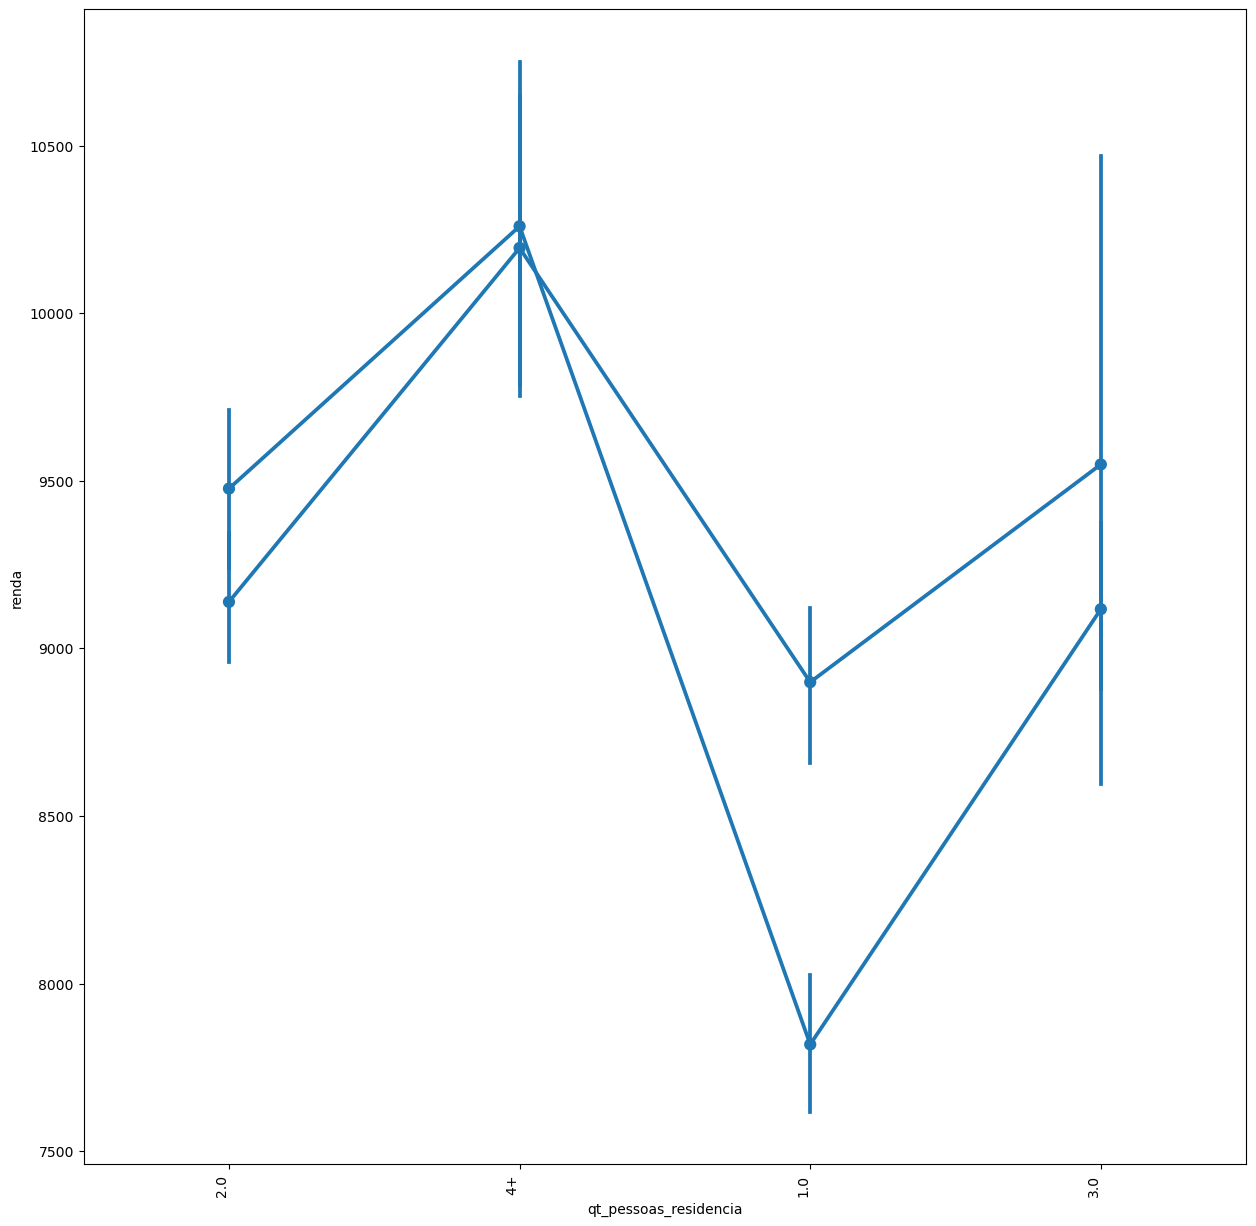

In [101]:
plt.close('all')

plt.rc('figure', figsize=(15, 15))

qtd_filhos = sns.pointplot(y = 'renda', x = 'qtd_filhos', data = df2)
qt_pessoas_residencia = sns.pointplot(y = 'renda', x = 'qt_pessoas_residencia', data = df2)

qtd_filhos.set_xticklabels(qtd_filhos.get_xticklabels(), rotation=90, horizontalalignment='right')
qt_pessoas_residencia.set_xticklabels(qt_pessoas_residencia.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.subplots_adjust(wspace=0.15, hspace=0.5)

In [102]:
import graphviz

In [103]:
df = pd.read_csv('previsao_de_renda.csv')
df.head()

Unnamed: 0    data_ref  index sexo  posse_de_veiculo  posse_de_imovel  \
0           0  2015-01-01   8682    F             False             True   
1           1  2015-01-01  12830    M              True             True   
2           2  2015-01-01   2885    M              True             True   
3           3  2015-01-01  16168    F              True            False   
4           4  2015-01-01  12438    M             False            False   

   qtd_filhos   tipo_renda           educacao estado_civil tipo_residencia  \
0           1  Assalariado         Secundário       Casado            Casa   
1           0   Empresário         Secundário       Casado            Casa   
2           2  Assalariado  Superior completo       Casado            Casa   
3           0   Empresário         Secundário       Casado            Casa   
4           0  Assalariado         Secundário       Casado            Casa   

   idade  tempo_emprego  qt_pessoas_residencia    mau    renda  
0     36       3.575342                    3.0  False  3369.24  
1     42       0.860274                    2.0  False  6096.14  
2     31       8.065753                    4.0  False  5658.98  
3     50       1.208219                    2.0  False  7246.69  
4     52      13.873973                    2.0  False  4017.37

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   index                  15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12466 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  mau                    15000 non-null  bool   
 15  re

In [105]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies

Unnamed: 0  index  posse_de_veiculo  posse_de_imovel  qtd_filhos  \
0               0   8682             False             True           1   
1               1  12830              True             True           0   
2               2   2885              True             True           2   
3               3  16168              True            False           0   
4               4  12438             False            False           0   
...           ...    ...               ...              ...         ...   
14995       14995   3678              True             True           1   
14996       14996   3405              True             True           1   
14997       14997   7944              True             True           0   
14998       14998  16019             False             True           0   
14999       14999  12895              True             True           0   

       idade  tempo_emprego  qt_pessoas_residencia    mau    renda  ...  \
0         36       3.575342                    3.0  False  3369.24  ...   
1         42       0.860274                    2.0  False  6096.14  ...   
2         31       8.065753                    4.0  False  5658.98  ...   
3         50       1.208219                    2.0  False  7246.69  ...   
4         52      13.873973                    2.0  False  4017.37  ...   
...      ...            ...                    ...    ...      ...  ...   
14995     37       2.046575                    3.0  False  1193.29  ...   
14996     30      12.079452                    3.0  False  2519.18  ...   
14997     40       2.161644                    2.0  False  1586.85  ...   
14998     47       3.295890                    2.0  False  6975.39  ...   
14999     50       3.049315                    2.0  False   993.86  ...   

       educacao_Superior incompleto  estado_civil_Separado  \
0                             False                  False   
1                             False                  False   
2                             False                  False   
3                             False                  False   
4                             False                  False   
...                             ...                    ...   
14995                         False                  False   
14996                         False                  False   
14997                         False                  False   
14998                         False                  False   
14999                         False                  False   

       estado_civil_Solteiro  estado_civil_União  estado_civil_Viúvo  \
0                      False               False               False   
1                      False               False               False   
2                      False               False               False   
3                      False               False               False   
4                      False               False               False   
...                      ...                 ...                 ...   
14995                  False               False               False   
14996                  False               False               False   
14997                  False               False               False   
14998                  False               False               False   
14999                  False               False               False   

       tipo_residencia_Casa  tipo_residencia_Com os pais  \
0                      True                        False   
1                      True                        False   
2                      True                        False   
3                      True                        False   
4                      True                        False   
...                     ...                          ...   
14995                  True                        False   
14996                 False                        False   
14997                  True                        Fals

In [106]:
X = df.drop(['Unnamed: 0', 'data_ref', 'index'], axis=1)
X

sexo  posse_de_veiculo  posse_de_imovel  qtd_filhos        tipo_renda  \
0        F             False             True           1       Assalariado   
1        M              True             True           0        Empresário   
2        M              True             True           2       Assalariado   
3        F              True            False           0        Empresário   
4        M             False            False           0       Assalariado   
...    ...               ...              ...         ...               ...   
14995    M              True             True           1       Assalariado   
14996    M              True             True           1  Servidor público   
14997    F              True             True           0       Assalariado   
14998    F             False             True           0  Servidor público   
14999    F              True             True           0       Assalariado   

                educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0             Secundário       Casado            Casa     36       3.575342   
1             Secundário       Casado            Casa     42       0.860274   
2      Superior completo       Casado            Casa     31       8.065753   
3             Secundário       Casado            Casa     50       1.208219   
4             Secundário       Casado            Casa     52      13.873973   
...                  ...          ...             ...    ...            ...   
14995         Secundário       Casado            Casa     37       2.046575   
14996  Superior completo       Casado         Estúdio     30      12.079452   
14997         Secundário       Casado            Casa     40       2.161644   
14998  Superior completo       Casado            Casa     47       3.295890   
14999         Secundário       Casado            Casa     50       3.049315   

       qt_pessoas_residencia    mau    renda  
0                        3.0  False  3369.24  
1                        2.0  False  6096.14  
2                        4.0  False  5658.98  
3                        2.0  False  7246.69  
4                        2.0  False  4017.37  
...                      ...    ...      ...  
14995                    3.0  False  1193.29  
14996                    3.0  False  2519.18  
14997                    2.0  False  1586.85  
14998                    2.0  False  6975.39  
14999                    2.0  False   993.86  

[15000 rows x 13 columns]

In [107]:
X_train, X_test = train_test_split(X, train_size=0.75, random_state=100)

In [108]:
X1 = patsy.dmatrices('''np.log(renda) ~ C(sexo)
                    + C(posse_de_veiculo)
                    + C(posse_de_imovel)
                    + qtd_filhos
                    + C(tipo_renda)
                    + C(educacao, Treatment(2))
                    + C(estado_civil)
                    + C(tipo_residencia, Treatment(1))
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia
                    + 1''', X_test)

In [109]:
modelo = smf.ols(X1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0)

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     38.79
Date:                Mon, 02 Sep 2024   Prob (F-statistic):          2.15e-162
Time:                        16:10:28   Log-Likelihood:                -3284.7
No. Observations:                3105   AIC:                             6621.
Df Residuals:                    3080   BIC:                             6778.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.3618      0.411     17.913      0.000       6.556       8.168
C(sexo)[T.M]                                          0.4823      0.029     16.843      0.000       0.426       0.538
C(posse_de_veiculo)[T.True]                           0.0164      0.028      0.592      0.554      -0.038       0.071
C(posse_de_imovel)[T.True]                            0.1090      0.027      4.033      0.000       0.056       0.162
C(tipo_renda)[T.Bolsista]                            -0.1716      0.701     -0.245      0.807      -1.545       1.202
C(tipo_renda)[T.Empresário]                           0.1608      0.030      5.418      0.000       0.103       0.219
C(tipo_renda)[T.Pensionista]                          0.4815      0.351      1.372      0.170      -0.207       1.170
C(tipo_renda)[T.Servidor público]                     0.1028      0.042      2.453      0.014       0.021       0.185
C(educacao, Treatment(2))[T.Primário]                 0.0913      0.145      0.631      0.528      -0.192       0.375
C(educacao, Treatment(2))[T.Pós graduação]            0.2572      0.405      0.634      0.526      -0.538       1.052
C(educacao, Treatment(2))[T.Superior completo]        0.0871      0.027      3.203      0.001       0.034       0.140
C(educacao, Treatment(2))[T.Superior incompleto]      0.0124      0.058      0.214      0.831      -0.101       0.126
C(estado_civil)[T.Separado]                          -0.1296      0.209     -0.619      0.536      -0.540       0.281
C(estado_civil)[T.Solteiro]                          -0.1019      0.205     -0.498      0.619      -0.503       0.299
C(estado_civil)[T.União]                              0.0392      0.048      0.823      0.411      -0.054       0.133
C(estado_civil)[T.Viúvo]                             -0.0648      0.223     -0.291      0.771      -0.502       0.372
C(tipo_residencia, Treatment(1))[T.Aluguel]          -0.0834      0.095     -0.878      0.380      -0.270       0.103
C(tipo_residencia, Treatment(1))[T.Com os pais]      -0.1140      0.058     -1.966      0.049      -0.228      -0.000
C(tipo_residencia, Treatment(1))[T.Comunitário]       0.3026      0.212      1.427      0.154      -0.113       0.718
C(tipo_residencia, Treatment(1))[T.Estúdio]          -0.2346      0.150     -1.561      0.119      -0.529       0.060
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.1558      0.078     -2.004      0.045      -0.308      -0.003
qtd_filhos                                            0.0870      0.203      0.429      0.668      -0.311       0.485
idade                                                 0.0056      0.002      3.535      0.000       0.002       0.009
tempo_emprego  

In [110]:
modelo_1 = smf.ols(X1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.001)

modelo_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     53.60
Date:                Mon, 02 Sep 2024   Prob (F-statistic):          4.20e-167
Time:                        16:10:29   Log-Likelihood:                -3287.4
No. Observations:                3105   AIC:                             6613.
Df Residuals:                    3087   BIC:                             6728.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.3857      0.410     17.995      0.000       6.581       8.190
C(sexo)[T.M]                                          0.4808      0.028     16.889      0.000       0.425       0.537
C(posse_de_veiculo)[T.True]                           0.0145      0.028      0.525      0.600      -0.040       0.069
C(posse_de_imovel)[T.True]                            0.1077      0.027      3.991      0.000       0.055       0.161
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                           0.1584      0.030      5.353      0.000       0.100       0.216
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                     0.0992      0.042      2.370      0.018       0.017       0.181
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]        0.0862      0.027      3.243      0.001       0.034       0.138
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                          -0.1340      0.209     -0.641      0.522      -0.544       0.276
C(estado_civil)[T.Solteiro]                          -0.1029      0.205     -0.503      0.615      -0.504       0.298
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                             -0.0695      0.223     -0.312      0.755      -0.506       0.367
C(tipo_residencia, Treatment(1))[T.Aluguel]          -0.0881      0.095     -0.927      0.354      -0.274       0.098
C(tipo_residencia, Treatment(1))[T.Com os pais]      -0.1151      0.058     -1.992      0.046      -0.228      -0.002
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]          -0.2368      0.150     -1.576      0.115      -0.531       0.058
C(tipo_residencia, Treatment(1))[T.Governamental]    -0.1607      0.078     -2.068      0.039      -0.313      -0.008
qtd_filhos                                            0.0859      0.203      0.424      0.672      -0.312       0.483
idade                                                 0.0053      0.002      3.428      0.001       0.002       0.008
tempo_emprego  

In [111]:
modelo_2 = smf.ols(X1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.005)

modelo_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     104.6
Date:                Mon, 02 Sep 2024   Prob (F-statistic):          2.60e-171
Time:                        16:10:29   Log-Likelihood:                -3297.5
No. Observations:                3105   AIC:                             6615.
Df Residuals:                    3096   BIC:                             6675.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.2290      0.078     92.934      0.000       7.077       7.382
C(sexo)[T.M]                                          0.4835      0.027     18.103      0.000       0.431       0.536
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                            0.1186      0.027      4.448      0.000       0.066       0.171
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                           0.1705      0.029      5.785      0.000       0.113       0.228
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                     0.1099      0.042      2.635      0.008       0.028       0.192
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]      -0.1099      0.058     -1.907      0.057      -0.223       0.003
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                                 0          0        nan        nan           0           0
idade                                                 0.0050      0.001      3.313      0.001       0.002       0.008
tempo_emprego  

In [112]:
modelo_3 = smf.ols(X1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.01)

modelo_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     149.8
Date:                Mon, 02 Sep 2024   Prob (F-statistic):          2.64e-167
Time:                        16:10:29   Log-Likelihood:                -3314.3
No. Observations:                3105   AIC:                             6643.
Df Residuals:                    3099   BIC:                             6685.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.2595      0.075     96.909      0.000       7.113       7.406
C(sexo)[T.M]                                          0.4756      0.027     17.758      0.000       0.423       0.528
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                                 0          0        nan        nan           0           0
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                           0.1613      0.029      5.566      0.000       0.104       0.218
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                                 0          0        nan        nan           0           0
idade                                                 0.0061      0.001      4.103      0.000       0.003       0.009
tempo_emprego  

In [113]:
modelo_4 = smf.ols(X1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.05)

modelo_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     213.0
Date:                Mon, 02 Sep 2024   Prob (F-statistic):          1.24e-161
Time:                        16:10:30   Log-Likelihood:                -3332.9
No. Observations:                3105   AIC:                             6676.
Df Residuals:                    3101   BIC:                             6706.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.4229      0.059    125.463      0.000       7.307       7.539
C(sexo)[T.M]                                          0.4775      0.027     17.800      0.000       0.425       0.530
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                                 0          0        nan        nan           0           0
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                                 0          0        nan        nan           0           0
idade                                                 0.0052      0.001      3.643      0.000       0.002       0.008
tempo_emprego  

In [114]:
modelo_5 = smf.ols(X1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.1)

modelo_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     213.0
Date:                Mon, 02 Sep 2024   Prob (F-statistic):          1.24e-161
Time:                        16:10:30   Log-Likelihood:                -3332.9
No. Observations:                3105   AIC:                             6676.
Df Residuals:                    3101   BIC:                             6706.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.4229      0.059    125.463      0.000       7.307       7.539
C(sexo)[T.M]                                          0.4775      0.027     17.800      0.000       0.425       0.530
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                                 0          0        nan        nan           0           0
C(tipo_renda)[T.Bolsista]                                  0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                                 0          0        nan        nan           0           0
idade                                                 0.0052      0.001      3.643      0.000       0.002       0.008
tempo_emprego  

In [115]:
X_test['log_renda']=np.log(X_test['renda'])

In [116]:
X_test['pred'] = modelo.predict(X_test)
r = X_test[['pred', 'log_renda']].corr().iloc[0,1]
r**2

0.23946914174421594

In [117]:
X_test['pred1'] = modelo_1.predict(X_test)
r = X_test[['pred1', 'log_renda']].corr().iloc[0,1]
r**2

0.2381228578002218

In [118]:
X_test['pred2'] = modelo_2.predict(X_test)
r = X_test[['pred2', 'log_renda']].corr().iloc[0,1]
r**2

0.23315953626785677

In [119]:
X_test['pred3'] = modelo_3.predict(X_test)
r = X_test[['pred3', 'log_renda']].corr().iloc[0,1]
r**2

0.224812733487191

In [120]:
X_test['pred4'] = modelo_4.predict(X_test)
r = X_test[['pred4', 'log_renda']].corr().iloc[0,1]
r**2

0.21549608421314714

In [121]:
X_test['pred5'] = modelo_5.predict(X_test)
r = X_test[['pred5', 'log_renda']].corr().iloc[0,1]
r**2

0.21549608421314714

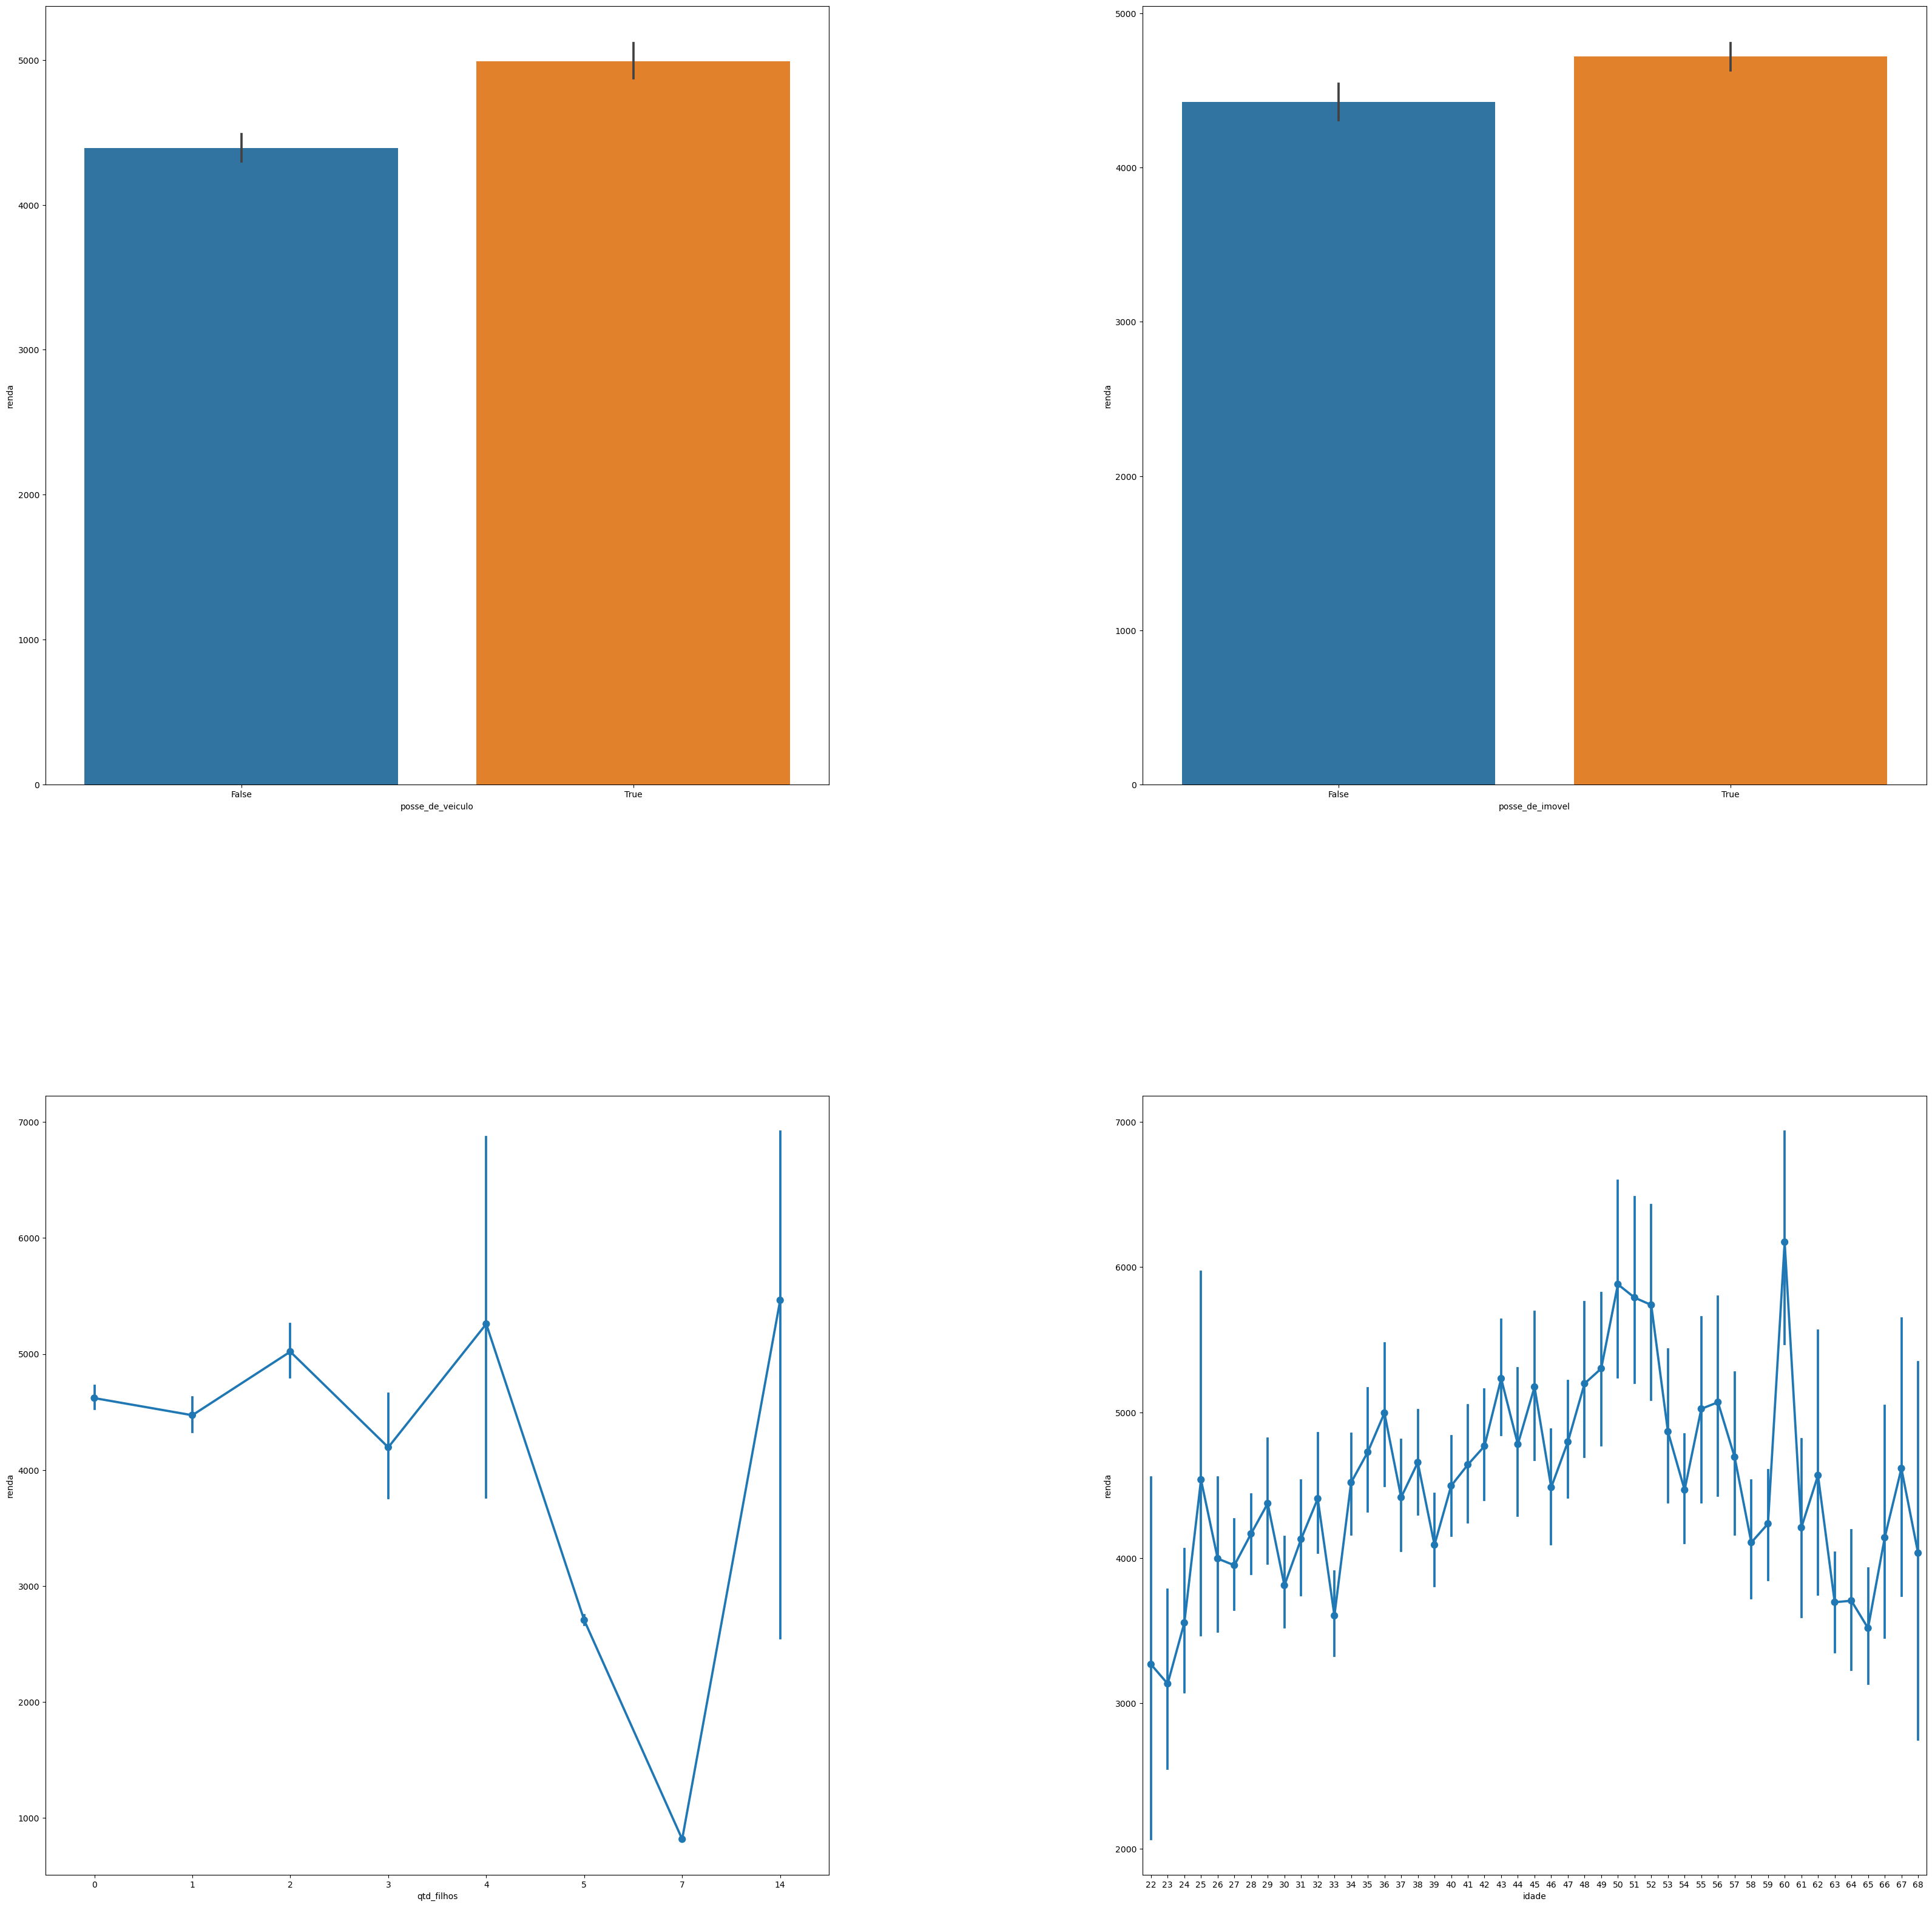

In [122]:
plt.close('all')

plt.rc('figure', figsize=(40, 40))
fig, axes = plt.subplots(2, 2)

sns.barplot(ax = axes[0, 0],y = 'renda', x = 'posse_de_veiculo', data = X)
sns.barplot(ax = axes[0, 1],y = 'renda', x = 'posse_de_imovel', data = X)
sns.pointplot(ax = axes[1, 0],y = 'renda', x = 'qtd_filhos', data = X)
sns.pointplot(ax = axes[1, 1],y = 'renda', x = 'idade', data = X)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [123]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.05, verbose=True):
  """
  Perform a forward-backward feature selection based on p-value from statsmodels.api.OLS
  """
  included = list(initial_list)
  while True:
    changed = False
    # forward step
    excluded = list(set(X.columns) - set(included))
    new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
    for new_column in excluded:
      model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
      new_pval[new_column] = model.pvalues[new_column]
    best_pval = new_pval.min()
    if best_pval < threshold_in:
      best_feature = new_pval.idxmin()
      included.append(best_feature)
      changed = True
      if verbose:
        print('Add {:30} with p-value {:.6}'.format(best_feature, best_pval))

    # backward step
    if included:
      model = sm.OLS(y, sm.add_constant(X[included])).fit()
      # use all coefs except intercept
      pvalues = model.pvalues.iloc[1:]
      worst_pval = pvalues.max() # null if pvalues is empty
      if worst_pval > threshold_out:
        worst_feature = pvalues.idxmax()
        included.remove(worst_feature)
        changed = True
        if verbose:
          print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
    if not changed:
      break
  return included

In [124]:
X_train_a = X_train.dropna()

In [125]:
X_train_b = pd.get_dummies(X_train_a, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], drop_first=True)
X_train_b.head()

qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia    mau  \
1614            0     28       2.178082                    2.0  False   
9327            0     46       1.542466                    2.0  False   
11914           0     54      18.109589                    2.0  False   
14579           0     42      18.632877                    2.0  False   
10292           2     43       1.550685                    4.0  False   

          renda  sexo_M  posse_de_veiculo_True  posse_de_imovel_True  \
1614    3065.96   False                  False                  True   
9327    2267.87   False                  False                  True   
11914   9742.35    True                   True                 False   
14579  12614.10   False                  False                 False   
10292   9683.96    True                  False                  True   

       tipo_renda_Bolsista  ...  educacao_Superior incompleto  \
1614                 False  ...                          True   
9327                 False  ...                         False   
11914                False  ...                         False   
14579                False  ...                         False   
10292                False  ...                         False   

       estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
1614                   False                  False                True   
9327                   False                  False               False   
11914                  False                  False               False   
14579                  False                  False                True   
10292                  False                  False               False   

       estado_civil_Viúvo  tipo_residencia_Casa  tipo_residencia_Com os pais  \
1614                False                  True                        False   
9327                False                  True                        False   
11914               False                  True                        False   
14579               False                  True                        False   
10292               False                  True                        False   

       tipo_residencia_Comunitário  tipo_residencia_Estúdio  \
1614                         False                    False   
9327                         False                    False   
11914                        False                    False   
14579                        False                    False   
10292                        False                    False   

       tipo_residencia_Governamental  
1614                           False  
9327                           False  
11914                          False  
14579                          False  
10292                          False  

[5 rows x 26 columns]

In [126]:
X_train_b = X_train_b.astype(float).dropna()

In [127]:
X_train_c = X_train_b.drop(['renda'], axis=1)
y_train_a = X_train_b['renda']

In [128]:
result = stepwise_selection(X=X_train_c, y=y_train_a)
print('resulting features:')
print(result)

Add tempo_emprego                  with p-value 0.0
Add sexo_M                         with p-value 5.46052e-116
Add tipo_renda_Empresário          with p-value 1.012e-24
Add educacao_Superior completo     with p-value 4.74209e-11
Add idade                          with p-value 9.59887e-09
Add posse_de_imovel_True           with p-value 0.000224121
Add educacao_Pós graduação         with p-value 0.00599789
Add tipo_renda_Servidor público    with p-value 0.0079383
resulting features:
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior completo', 'idade', 'posse_de_imovel_True', 'educacao_Pós graduação', 'tipo_renda_Servidor público']


In [129]:
X_train_b.rename(columns = {'educacao_Superior completo':'educacao_Superior_completo'}, inplace=True)

In [130]:
modelo_m = smf.ols('''np.log(renda) ~  tempo_emprego +
                                        sexo_M +
                                        tipo_renda_Empresário +
                                        idade +
                                        educacao_Superior_completo +
                                        qt_pessoas_residencia''', data = X_train_b).fit()
modelo_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     487.4
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:10:40   Log-Likelihood:                -9945.5
No. Observations:                9361   AIC:                         1.990e+04
Df Residuals:                    9354   BIC:                         1.995e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.2627      0.044    165.505      0.000       7.177       7.349
tempo_emprego                  0.0491      0.001     42.996      0.000       0.047       0.051
sexo_M                         0.4759      0.015     30.839      0.000       0.446       0.506
tipo_renda_Empresário          0.1729      0.016     10.490      0.000       0.141       0.205
idade                          0.0055      0.001      6.501      0.000       0.004       0.007
educacao_Superior_completo     0.1099      0.015      7.311      0.000       0.080       0.139
qt_pessoas_residencia          0.0107      0.008      1.353      0.176      -0.005       0.026
==============================================================================
Omnibus:                        0.673   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.714   Jarque-Bera (JB):                0.666
Skew:                          -0.021   Prob(JB):                        0.717
Kurtosis:                       3.003   Cond. No.                         262.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
X_train_a = X_train.dropna()
X_train_b = pd.get_dummies(X_train_a, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], drop_first=True)
X_train_b.rename(columns = {'educacao_Superior completo':'educacao_Superior_completo'}, inplace=True)
X_train_b['log_renda']=np.log(X_train_b['renda'])

In [132]:
X_train_b = X_train_b.astype(float).dropna()

In [133]:
X_train_b['pred_m'] = modelo_m.predict(X_train_b)
r = X_train_b[['pred_m', 'log_renda']].corr().iloc[0,1]
r**2

0.23817594517821242

In [134]:
modelo_n = smf.ols('np.log(renda) ~  tempo_emprego + sexo_M + idade + qt_pessoas_residencia', data = X_train_b).fit()
modelo_n.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     676.1
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:10:40   Log-Likelihood:                -10030.
No. Observations:                9361   AIC:                         2.007e+04
Df Residuals:                    9356   BIC:                         2.011e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.3996      0.043    172.470      0.000       7.316       7.484
tempo_emprego             0.0480      0.001     41.879      0.000       0.046       0.050
sexo_M                    0.4686      0.016     30.123      0.000       0.438       0.499
idade                     0.0048      0.001      5.584      0.000       0.003       0.006
qt_pessoas_residencia     0.0074      0.008      0.925      0.355      -0.008       0.023
==============================================================================
Omnibus:                        0.203   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.903   Jarque-Bera (JB):                0.175
Skew:                           0.004   Prob(JB):                        0.916
Kurtosis:                       3.019   Cond. No.                         253.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
modelo_o = smf.ols('np.log(renda) ~  tempo_emprego + I(tempo_emprego**2) + sexo_M + idade + qt_pessoas_residencia', data = X_train_b).fit()
modelo_o.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     541.0
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:10:40   Log-Likelihood:                -10030.
No. Observations:                9361   AIC:                         2.007e+04
Df Residuals:                    9355   BIC:                         2.012e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.4062      0.044    167.866      0.000       7.320       7.493
tempo_emprego             0.0463      0.003     16.144      0.000       0.041       0.052
I(tempo_emprego ** 2)  6.239e-05   9.83e-05      0.635      0.526      -0.000       0.000
sexo_M                    0.4688      0.016     30.128      0.000       0.438       0.499
idade                     0.0047      0.001      5.545      0.000       0.003       0.006
qt_pessoas_residencia     0.0078      0.008      0.969      0.333      -0.008       0.023
==============================================================================
Omnibus:                        0.204   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.903   Jarque-Bera (JB):                0.176
Skew:                           0.004   Prob(JB):                        0.916
Kurtosis:                       3.020   Cond. No.                     1.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [136]:
from sklearn.tree import DecisionTreeRegressor

In [137]:
regr1 = DecisionTreeRegressor(max_depth=8)
regr2 = DecisionTreeRegressor(max_depth=2)

regr1.fit(X_train_c, y_train_a)
regr2.fit(X_train_c, y_train_a)

DecisionTreeRegressor(max_depth=2)

In [138]:
from sklearn.metrics import mean_squared_error

In [139]:
train1 = regr1.predict(X_train_c)
train2 = regr2.predict(X_train_c)
print('Para base de treinamento:')
print('O mse com profundidade = 8, MSE=', mean_squared_error(y_train_a,train1))
print('O mse com profundidade = 2, MSE=', mean_squared_error(y_train_a,train2))

Para base de treinamento:
O mse com profundidade = 8, MSE= 13851144.034315458
O mse com profundidade = 2, MSE= 19047952.81297678


In [140]:
from sklearn import tree

Text(0, 0.5, 'Impureza total das folhas')

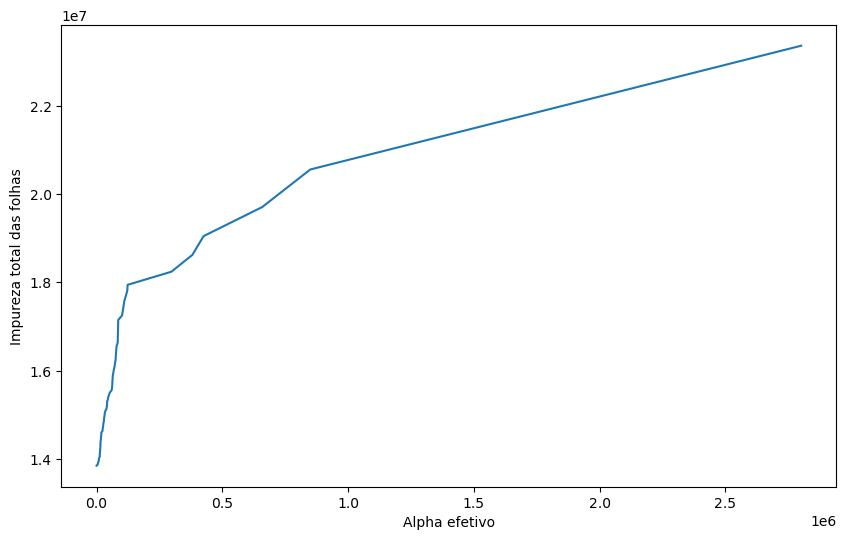

In [143]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("Alpha efetivo")
plt.ylabel("Impureza total das folhas")

In [144]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_c, y_train_a)
    clfs.append(clf)

Text(0, 0.5, 'Profundidade da árvore')

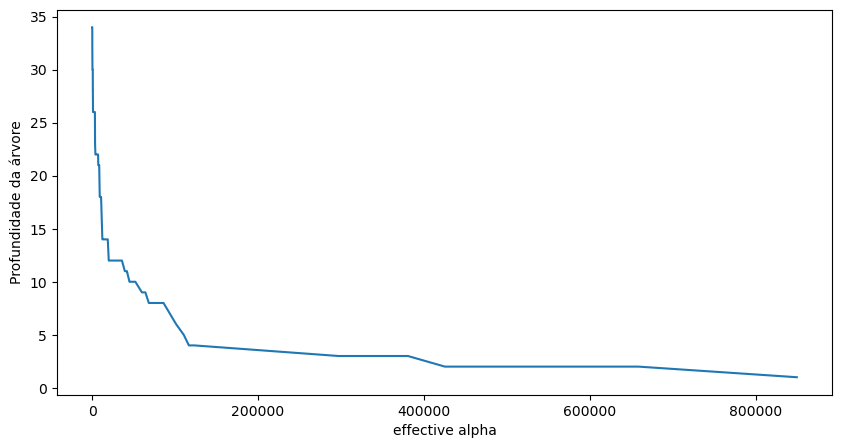

In [145]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  5))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Profundidade da árvore")

In [146]:
train_scores = [mean_squared_error(y_train_a, clf.predict(X_train_c)) for clf in clfs]

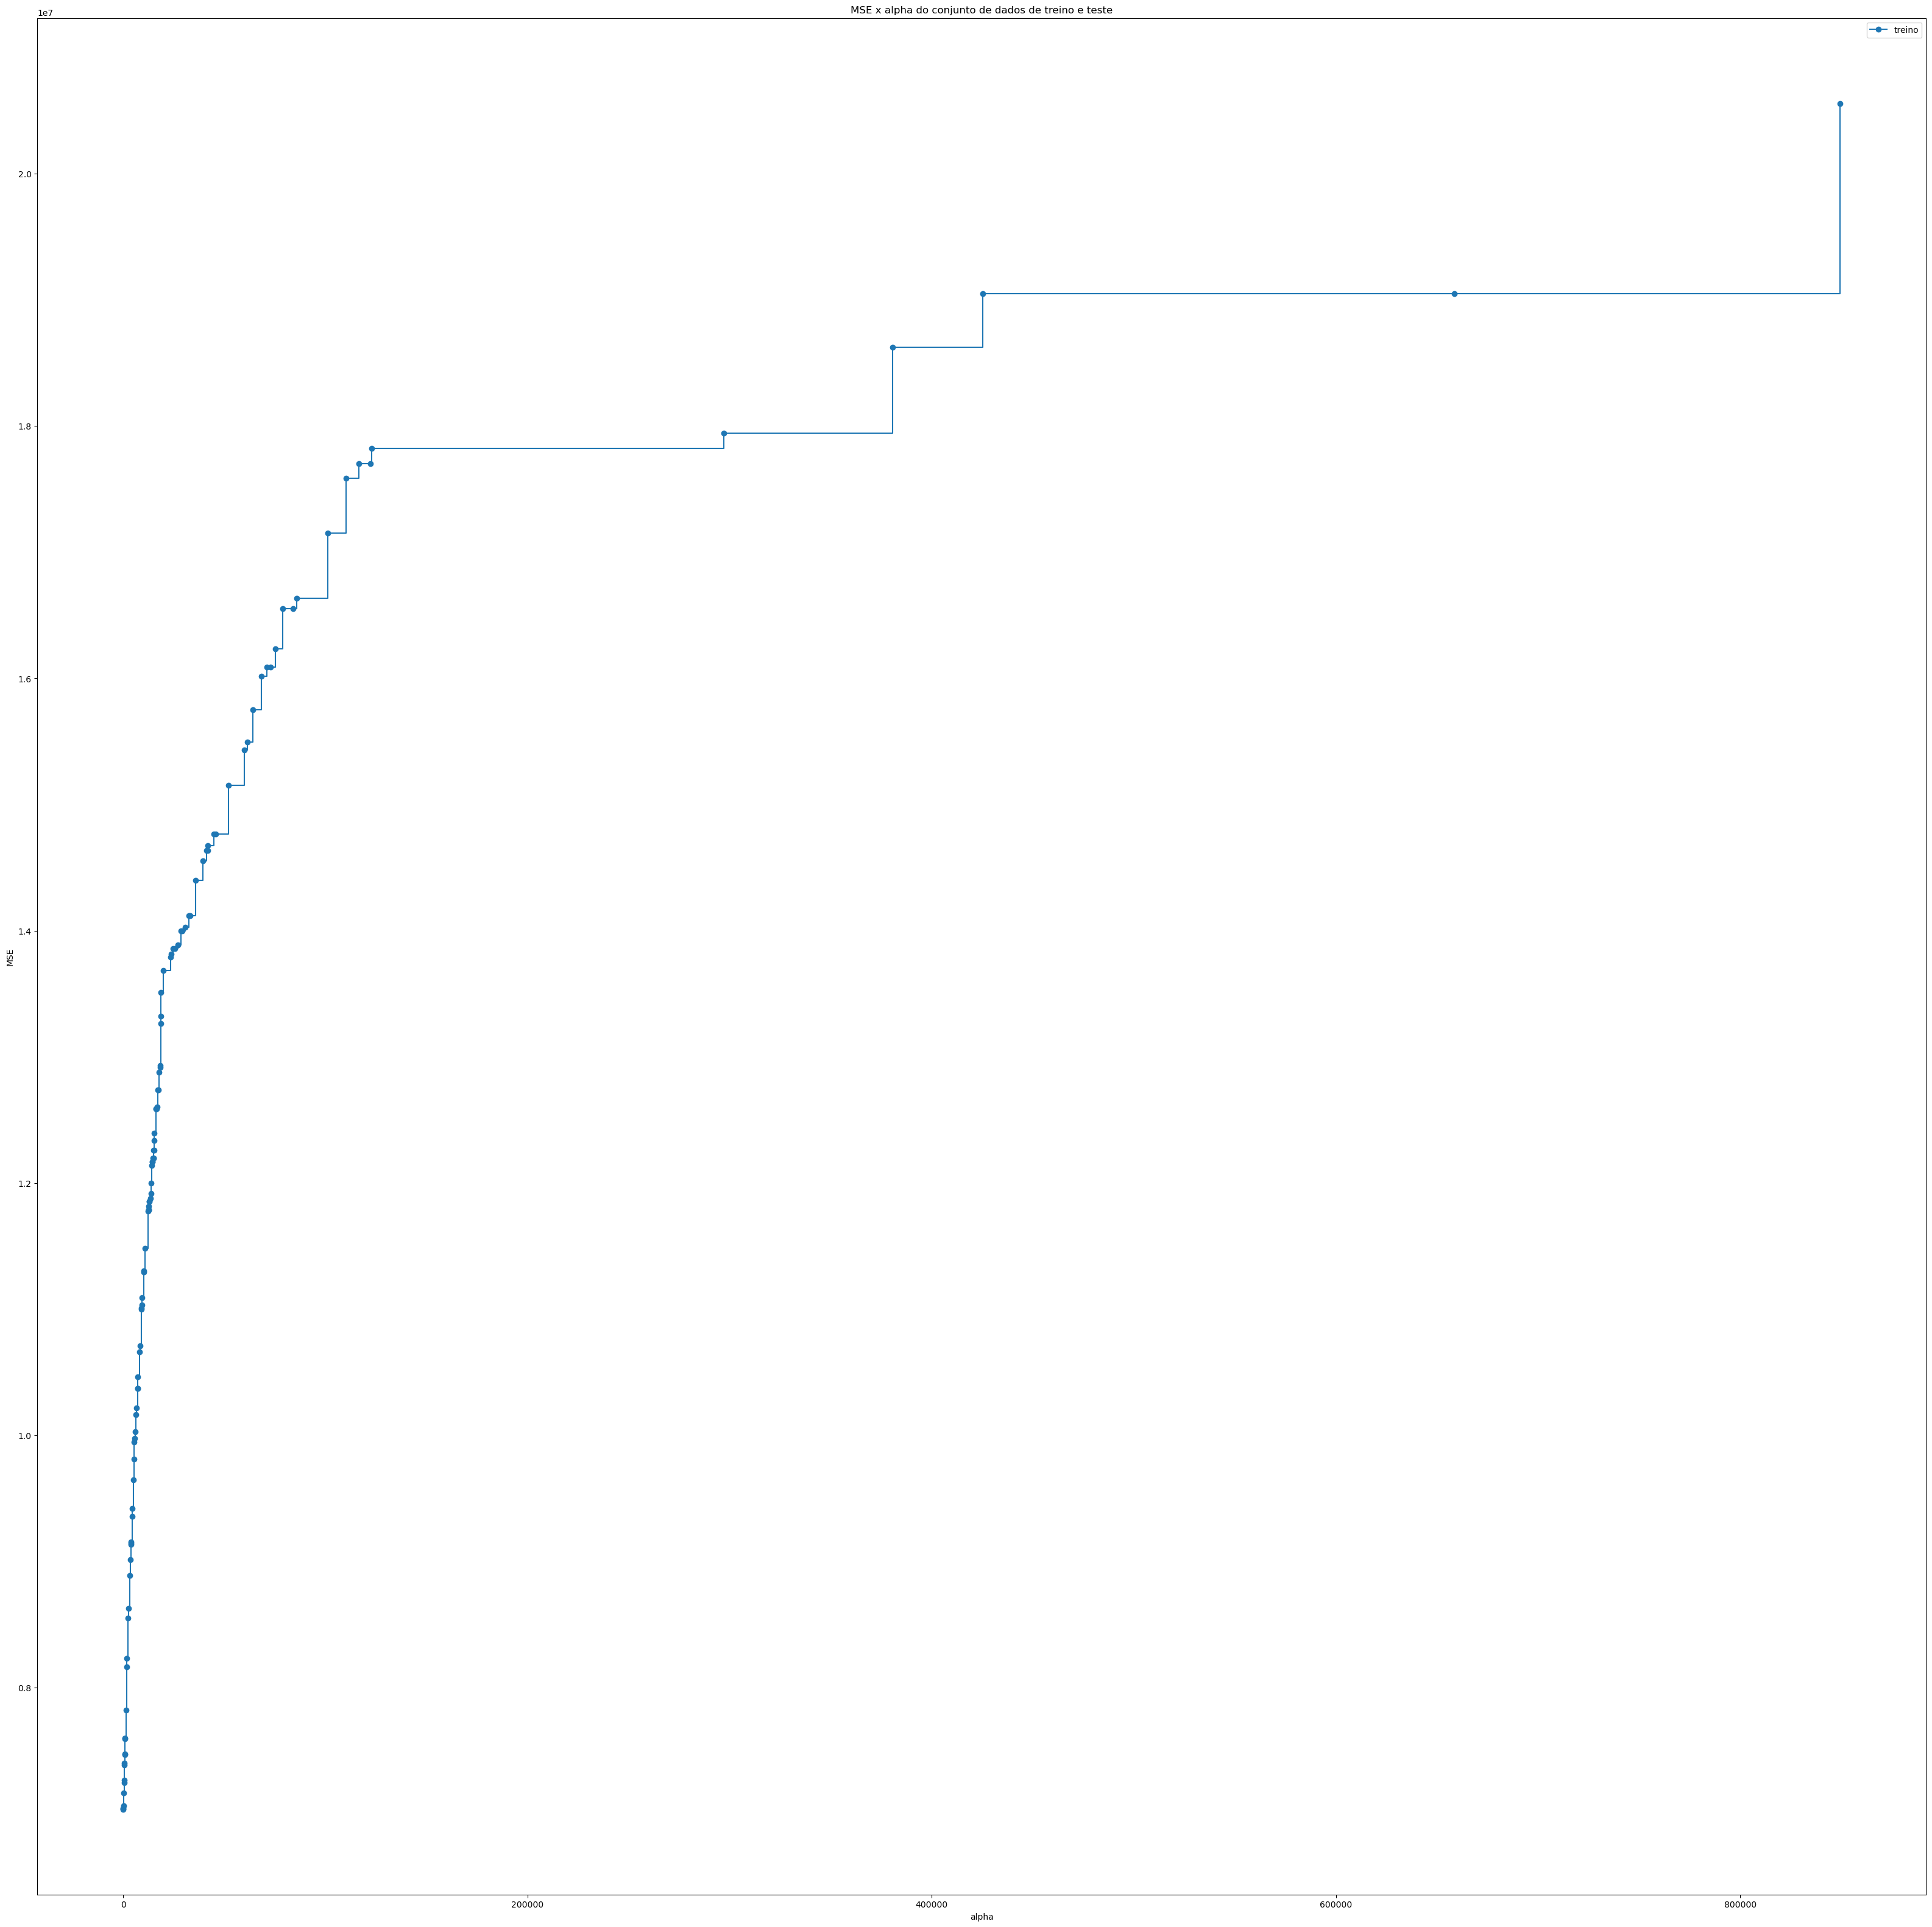

In [147]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="treino",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [148]:
arvore_final = DecisionTreeRegressor (random_state=0, ccp_alpha=.5)
arvore_final.fit(X_train_c, y_train_a)

print(f'Profundidade: {arvore_final.tree_.max_depth}')

Profundidade: 34


### Avaliação de valores missing e substitituição pela média

In [150]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
data_ref                                                              
2015-01-01   5762    M                S               N           0   
2015-01-01   1279    M                S               N           0   
2015-01-01  14111    M                S               N           0   
2015-01-01   8189    M                N               S           2   
2015-01-01   1830    F                N               S           2   

             tipo_renda             educacao estado_civil tipo_residencia  \
data_ref                                                                    
2015-01-01   Empresário    Superior completo       Casado            Casa   
2015-01-01  Assalariado  Superior incompleto       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   
2015-01-01  Assalariado                Médio       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   

            idade  tempo_emprego  qt_pessoas_residencia     renda  
data_ref                                                           
2015-01-01     47      16.717808                    2.0  11138.14  
2015-01-01     30       9.600000                    2.0   2424.81  
2015-01-01     28       8.208219                    2.0  13749.66  
2015-01-01     44       1.301370                    4.0   2361.84  
2015-01-01     33       1.254795                    4.0    790.78

In [151]:
df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [152]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())
df.isnull().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [153]:
df.index = pd.to_datetime(df.index)

print(f'''Meses presentes na base:
{[mes for mes in df.index.unique().strftime('%b%y')]}

{[mes for mes in df[df.index > (df.index.unique().max() - pd.DateOffset(months=3))].index.unique().strftime('%b%y')]}
''')

Meses presentes na base:
['Jan15', 'Feb15', 'Mar15', 'Apr15', 'May15', 'Jun15', 'Jul15', 'Aug15', 'Sep15', 'Oct15', 'Nov15', 'Dec15', 'Jan16', 'Feb16', 'Mar16']

['Jan16', 'Feb16', 'Mar16']



In [154]:
df_holdout = df[df.index > (df.index.unique().max() - pd.DateOffset(months=3))].copy()
df_holdout

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
data_ref                                                              
2016-01-01  12946    F                N               S           0   
2016-01-01   8872    F                N               S           2   
2016-01-01  16279    F                S               S           3   
2016-01-01   8158    M                S               S           3   
2016-01-01   9356    F                S               N           0   
...           ...  ...              ...             ...         ...   
2016-03-01  11611    F                N               S           1   
2016-03-01   9144    F                N               S           0   
2016-03-01  16583    F                N               S           0   
2016-03-01   3024    F                S               S           1   
2016-03-01   6074    F                N               S           0   

                  tipo_renda           educacao estado_civil tipo_residencia  \
data_ref                                                                       
2016-01-01       Pensionista              Médio       Casado            Casa   
2016-01-01  Servidor público  Superior completo       Casado            Casa   
2016-01-01       Assalariado              Médio       Casado            Casa   
2016-01-01  Servidor público              Médio       Casado            Casa   
2016-01-01       Assalariado              Médio        Viúvo            Casa   
...                      ...                ...          ...             ...   
2016-03-01       Assalariado  Superior completo       Casado            Casa   
2016-03-01       Pensionista  Superior completo       Casado            Casa   
2016-03-01       Assalariado  Superior completo       Casado            Casa   
2016-03-01        Empresário  Superior completo        União            Casa   
2016-03-01       Pensionista  Superior completo     Separado            Casa   

            idade  tempo_emprego  qt_pessoas_residencia     renda  
data_ref                                                           
2016-01-01     61       6.046575                    2.0   2137.61  
2016-01-01     27       9.301370                    4.0  13884.35  
2016-01-01     38      10.967123                    5.0  11042.47  
2016-01-01     35       5.553425                    5.0   1333.82  
2016-01-01     63       9.265753                    1.0  17633.03  
...           ...            ...                    ...       ...  
2016-03-01     29       8.665753                    3.0   2930.40  
2016-03-01     65       6.046575                    2.0   4084.37  
2016-03-01     33      10.969863                    2.0   4339.66  
2016-03-01     28       8.219178                    3.0   9159.49  
2016-03-01     62       6.046575                    1.0   2243.21  

[150000 rows x 13 columns]

In [155]:
df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]

In [156]:
X1 = patsy.dmatrices('''np.log(renda) ~ C(sexo)
                    + C(posse_de_veiculo)
                    + C(posse_de_imovel)
                    + qtd_filhos
                    + C(tipo_renda)
                    + C(educacao, Treatment(2))
                    + C(estado_civil)
                    + C(tipo_residencia, Treatment(1))
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia
                    + 1''', df_train)

In [157]:
res = smf.ols(X1, data=df_train).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)

resumo = res.summary()
resumo.tables[0]

<class 'statsmodels.iolib.table.SimpleTable'>

In [158]:
tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05, axis=1, props='color:red', subset='P>|t|'
).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

In [159]:
df_train['tempo_emprego_cat'], quebras = pd.qcut(df_train.tempo_emprego, 20, duplicates='drop', retbins=True)

C:\Users\natha\AppData\Local\Temp\ipykernel_15636\4272664757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tempo_emprego_cat'], quebras = pd.qcut(df_train.tempo_emprego, 20, duplicates='drop', retbins=True)


In [160]:
df_train.head()

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
data_ref                                                              
2015-01-01   5762    M                S               N           0   
2015-01-01   1279    M                S               N           0   
2015-01-01  14111    M                S               N           0   
2015-01-01   8189    M                N               S           2   
2015-01-01   1830    F                N               S           2   

             tipo_renda             educacao estado_civil tipo_residencia  \
data_ref                                                                    
2015-01-01   Empresário    Superior completo       Casado            Casa   
2015-01-01  Assalariado  Superior incompleto       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   
2015-01-01  Assalariado                Médio       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   

            idade  tempo_emprego  qt_pessoas_residencia     renda  \
data_ref                                                            
2015-01-01     47      16.717808                    2.0  11138.14   
2015-01-01     30       9.600000                    2.0   2424.81   
2015-01-01     28       8.208219                    2.0  13749.66   
2015-01-01     44       1.301370                    4.0   2361.84   
2015-01-01     33       1.254795                    4.0    790.78   

           tempo_emprego_cat  
data_ref                      
2015-01-01  (15.214, 20.216]  
2015-01-01   (9.082, 10.436]  
2015-01-01    (8.107, 9.082]  
2015-01-01    (0.816, 1.458]  
2015-01-01    (0.816, 1.458]

In [161]:
quebras

array([ 0.11780822,  0.81643836,  1.45753425,  2.09589041,  2.91232877,
        3.63561644,  4.29863014,  4.93424658,  5.75890411,  6.04657534,
        6.35890411,  7.12054795,  8.10684932,  9.08219178, 10.43561644,
       12.46575342, 15.21369863, 20.21643836, 42.90684932])

In [162]:
df_train['tempo_emprego_cat'] = pd.cut(df_train.tempo_emprego, bins=quebras, duplicates='drop')
df_train.head()

C:\Users\natha\AppData\Local\Temp\ipykernel_15636\1125015400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tempo_emprego_cat'] = pd.cut(df_train.tempo_emprego, bins=quebras, duplicates='drop')


index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
data_ref                                                              
2015-01-01   5762    M                S               N           0   
2015-01-01   1279    M                S               N           0   
2015-01-01  14111    M                S               N           0   
2015-01-01   8189    M                N               S           2   
2015-01-01   1830    F                N               S           2   

             tipo_renda             educacao estado_civil tipo_residencia  \
data_ref                                                                    
2015-01-01   Empresário    Superior completo       Casado            Casa   
2015-01-01  Assalariado  Superior incompleto       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   
2015-01-01  Assalariado                Médio       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   

            idade  tempo_emprego  qt_pessoas_residencia     renda  \
data_ref                                                            
2015-01-01     47      16.717808                    2.0  11138.14   
2015-01-01     30       9.600000                    2.0   2424.81   
2015-01-01     28       8.208219                    2.0  13749.66   
2015-01-01     44       1.301370                    4.0   2361.84   
2015-01-01     33       1.254795                    4.0    790.78   

           tempo_emprego_cat  
data_ref                      
2015-01-01  (15.214, 20.216]  
2015-01-01   (9.082, 10.436]  
2015-01-01    (8.107, 9.082]  
2015-01-01    (0.816, 1.458]  
2015-01-01    (0.816, 1.458]

In [163]:
tab_perfil = pd.DataFrame()

tab_perfil['qtd_obs'] = df_train['tempo_emprego_cat'].value_counts()

df_train['log_renda']=np.log(df_train['renda'])

tab_perfil['log_renda_med'] = df_train.groupby('tempo_emprego_cat')['log_renda'].mean()

tab_perfil['tempo_emprego_med'] = df_train.groupby('tempo_emprego_cat')['tempo_emprego'].mean()

tab_perfil.sort_index(axis = 0, inplace = True)

tab_perfil.reset_index(inplace=True)

tab_perfil.rename(columns={'index':'tempo_emprego_cat'}, inplace=True)

tab_perfil

C:\Users\natha\AppData\Local\Temp\ipykernel_15636\1178829481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_renda']=np.log(df_train['renda'])


tempo_emprego_cat  qtd_obs  log_renda_med  tempo_emprego_med
0     (0.118, 0.816]    30207       8.365576           0.515397
1     (0.816, 1.458]    30031       8.454323           1.125014
2     (1.458, 2.096]    29736       8.569544           1.781261
3     (2.096, 2.912]    30013       8.624148           2.510920
4     (2.912, 3.636]    30408       8.755365           3.301180
5     (3.636, 4.299]    29625       8.855078           3.987156
6     (4.299, 4.934]    30109       8.903273           4.610421
7     (4.934, 5.759]    29991       9.049495           5.367829
8     (5.759, 6.047]   110726       9.040393           6.034873
9     (6.047, 6.359]     9178       9.102869           6.200063
10    (6.359, 7.121]    30240       9.182894           6.717185
11    (7.121, 8.107]    29989       9.318448           7.613714
12    (8.107, 9.082]    29740       9.428302           8.572256
13   (9.082, 10.436]    30005       9.599298           9.741024
14  (10.436, 12.466]    29991       9.773545          11.383356
15  (12.466, 15.214]    30025      10.127487          13.855346
16  (15.214, 20.216]    29999      10.657687          17.538365
17  (20.216, 42.907]    29960      11.732204          26.457212

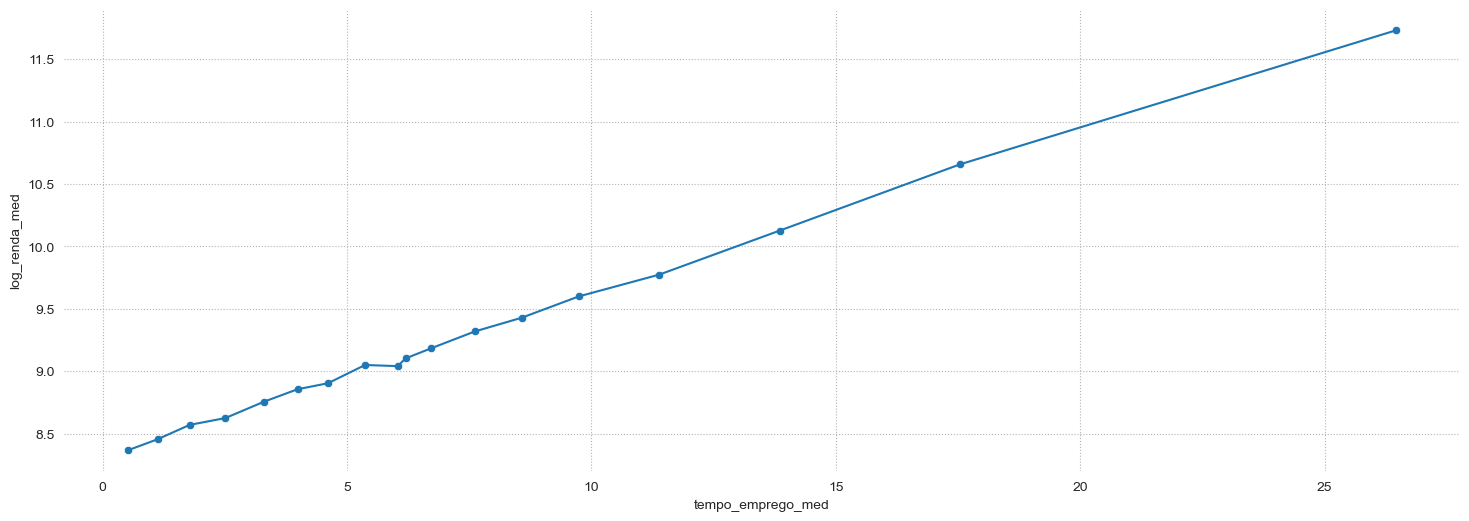

In [164]:
sns.set_style("whitegrid", {"grid.color": '.7', "grid.linestyle": ':'})

plt.figure(figsize=(18,6))

sns.scatterplot(x='tempo_emprego_med', y='log_renda_med', data=tab_perfil)

sns.lineplot(x='tempo_emprego_med', y='log_renda_med', data=tab_perfil)

sns.despine(left=True, bottom=True)

plt.show()

### Linearização

In [165]:
df_train_b = df_train.merge(tab_perfil, on='tempo_emprego_cat', how='left')
df_train_b.head()

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0   5762    M                S               N           0   Empresário   
1   1279    M                S               N           0  Assalariado   
2  14111    M                S               N           0  Assalariado   
3   8189    M                N               S           2  Assalariado   
4   1830    F                N               S           2  Assalariado   

              educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0    Superior completo       Casado            Casa     47      16.717808   
1  Superior incompleto       Casado            Casa     30       9.600000   
2    Superior completo       Casado            Casa     28       8.208219   
3                Médio       Casado            Casa     44       1.301370   
4    Superior completo       Casado            Casa     33       1.254795   

   qt_pessoas_residencia     renda tempo_emprego_cat  log_renda  qtd_obs  \
0                    2.0  11138.14  (15.214, 20.216]   9.318131  29999.0   
1                    2.0   2424.81   (9.082, 10.436]   7.793508  30005.0   
2                    2.0  13749.66    (8.107, 9.082]   9.528769  29740.0   
3                    4.0   2361.84    (0.816, 1.458]   7.767196  30031.0   
4                    4.0    790.78    (0.816, 1.458]   6.673020  30031.0   

   log_renda_med  tempo_emprego_med  
0      10.657687          17.538365  
1       9.599298           9.741024  
2       9.428302           8.572256  
3       8.454323           1.125014  
4       8.454323           1.125014

In [166]:
X2 = patsy.dmatrices('''log_renda ~
                    + C(posse_de_imovel)
                    + qtd_filhos
                    + idade
                    + tempo_emprego_cat
                    + 1''', df_train_b)

res_2 = smf.ols(X2, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_2.rsquared_adj:.2%}')

R-quadrado ajustado: 42.02%


In [167]:
%%time
lowess = sm.nonparametric.lowess(df_train_b.log_renda, df_train_b.tempo_emprego, frac=2/3)

CPU times: total: 4min 56s
Wall time: 9min 14s


In [168]:
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_train_b['tempo_emprego_lowess'] = f(df_train_b.tempo_emprego)
df_train_b.head()

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0   5762    M                S               N           0   Empresário   
1   1279    M                S               N           0  Assalariado   
2  14111    M                S               N           0  Assalariado   
3   8189    M                N               S           2  Assalariado   
4   1830    F                N               S           2  Assalariado   

              educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0    Superior completo       Casado            Casa     47      16.717808   
1  Superior incompleto       Casado            Casa     30       9.600000   
2    Superior completo       Casado            Casa     28       8.208219   
3                Médio       Casado            Casa     44       1.301370   
4    Superior completo       Casado            Casa     33       1.254795   

   qt_pessoas_residencia     renda tempo_emprego_cat  log_renda  qtd_obs  \
0                    2.0  11138.14  (15.214, 20.216]   9.318131  29999.0   
1                    2.0   2424.81   (9.082, 10.436]   7.793508  30005.0   
2                    2.0  13749.66    (8.107, 9.082]   9.528769  29740.0   
3                    4.0   2361.84    (0.816, 1.458]   7.767196  30031.0   
4                    4.0    790.78    (0.816, 1.458]   6.673020  30031.0   

   log_renda_med  tempo_emprego_med  tempo_emprego_lowess  
0      10.657687          17.538365             10.529949  
1       9.599298           9.741024              9.568334  
2       9.428302           8.572256              9.380380  
3       8.454323           1.125014              8.487446  
4       8.454323           1.125014              8.481435

In [169]:
X3 = patsy.dmatrices('''log_renda ~
                    + C(posse_de_imovel)
                    + qtd_filhos
                    + idade
                    + tempo_emprego_lowess
                    + 1''', df_train_b)

res_3 = smf.ols(X3, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_3.rsquared_adj:.2%}')

R-quadrado ajustado: 43.06%


### Avaliando o modelo

In [170]:
import warnings;   warnings.filterwarnings("ignore")

In [171]:
df_test['log_renda']=np.log(df_test['renda'])

df_test['pred_1'] = res.predict(df_test)

r = df_test[['pred_1', 'log_renda']].corr().iloc[0,1]
r**2

0.5376715049560669

In [172]:
df_test['tempo_emprego_cat'] = pd.cut(df_test.tempo_emprego, bins = quebras, duplicates='drop')

warnings.filterwarnings('ignore')
df_test['tempo_emprego_cat'].isna().value_counts()

tempo_emprego_cat
False    149991
True          9
Name: count, dtype: int64

In [173]:
df_test.dropna(inplace=True)
df_test['pred_2'] = res_2.predict(df_test)

r = df_test[['pred_2', 'log_renda']].corr().iloc[0,1]
r**2

0.5247549560888934

In [174]:
%%time
# Lowess
lowess = sm.nonparametric.lowess(df_test.log_renda, df_test.tempo_emprego, frac=2/3)

CPU times: total: 31.2 s
Wall time: 1min 6s


In [175]:
lowess_x = lowess[:, 0]

lowess_y = lowess[:, 1]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_test['tempo_emprego_lowess'] = f(df_test.tempo_emprego)
df_test.head(2)

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
data_ref                                                              
2016-01-01  12946    F                N               S           0   
2016-01-01   8872    F                N               S           2   

                  tipo_renda           educacao estado_civil tipo_residencia  \
data_ref                                                                       
2016-01-01       Pensionista              Médio       Casado            Casa   
2016-01-01  Servidor público  Superior completo       Casado            Casa   

            idade  tempo_emprego  qt_pessoas_residencia     renda  log_renda  \
data_ref                                                                       
2016-01-01     61       6.046575                    2.0   2137.61   7.667444   
2016-01-01     27       9.301370                    4.0  13884.35   9.538518   

              pred_1 tempo_emprego_cat    pred_2  tempo_emprego_lowess  
data_ref                                                                
2016-01-01  9.141801    (5.759, 6.047]  9.091657              7.900725  
2016-01-01  9.597904   (9.082, 10.436]  9.618868              8.342858

In [176]:
df_test['pred_3'] = res_3.predict(df_test)
r = df_test[['pred_3', 'log_renda']].corr().iloc[0,1]
r**2

0.5384478691854504

In [177]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [178]:
df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]
df_train['log_renda']=np.log(df_train['renda'])
df_test['log_renda']=np.log(df_test['renda'])

In [179]:
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                    + qtd_filhos
                    + idade
                    + tempo_emprego
                    + 1''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                 1.131e+05
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:22:44   Log-Likelihood:            -8.0162e+05
No. Observations:              600000   AIC:                         1.603e+06
Df Residuals:                  599996   BIC:                         1.603e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.2219      0.005   1661.668      0.000       8.212       8.232
C(posse_de_imovel)[T.S]     0.1812      0.003     70.949      0.000       0.176       0.186
qtd_filhos                       0          0        nan        nan           0           0
idade                      -0.0008      0.000     -7.364      0.000      -0.001      -0.001
tempo_emprego               0.1300      0.000    658.747      0.000       0.130       0.130
==============================================================================
Omnibus:                      973.028   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              860.618
Skew:                          -0.049   Prob(JB):                    1.32e-187
Kurtosis:                       2.842   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

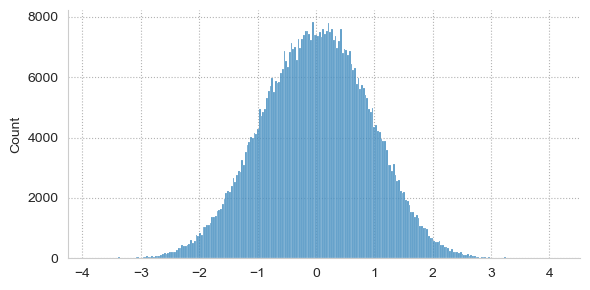

In [180]:
sns.displot(res.resid, height=3, aspect=2);

<Axes: ylabel='log_renda'>

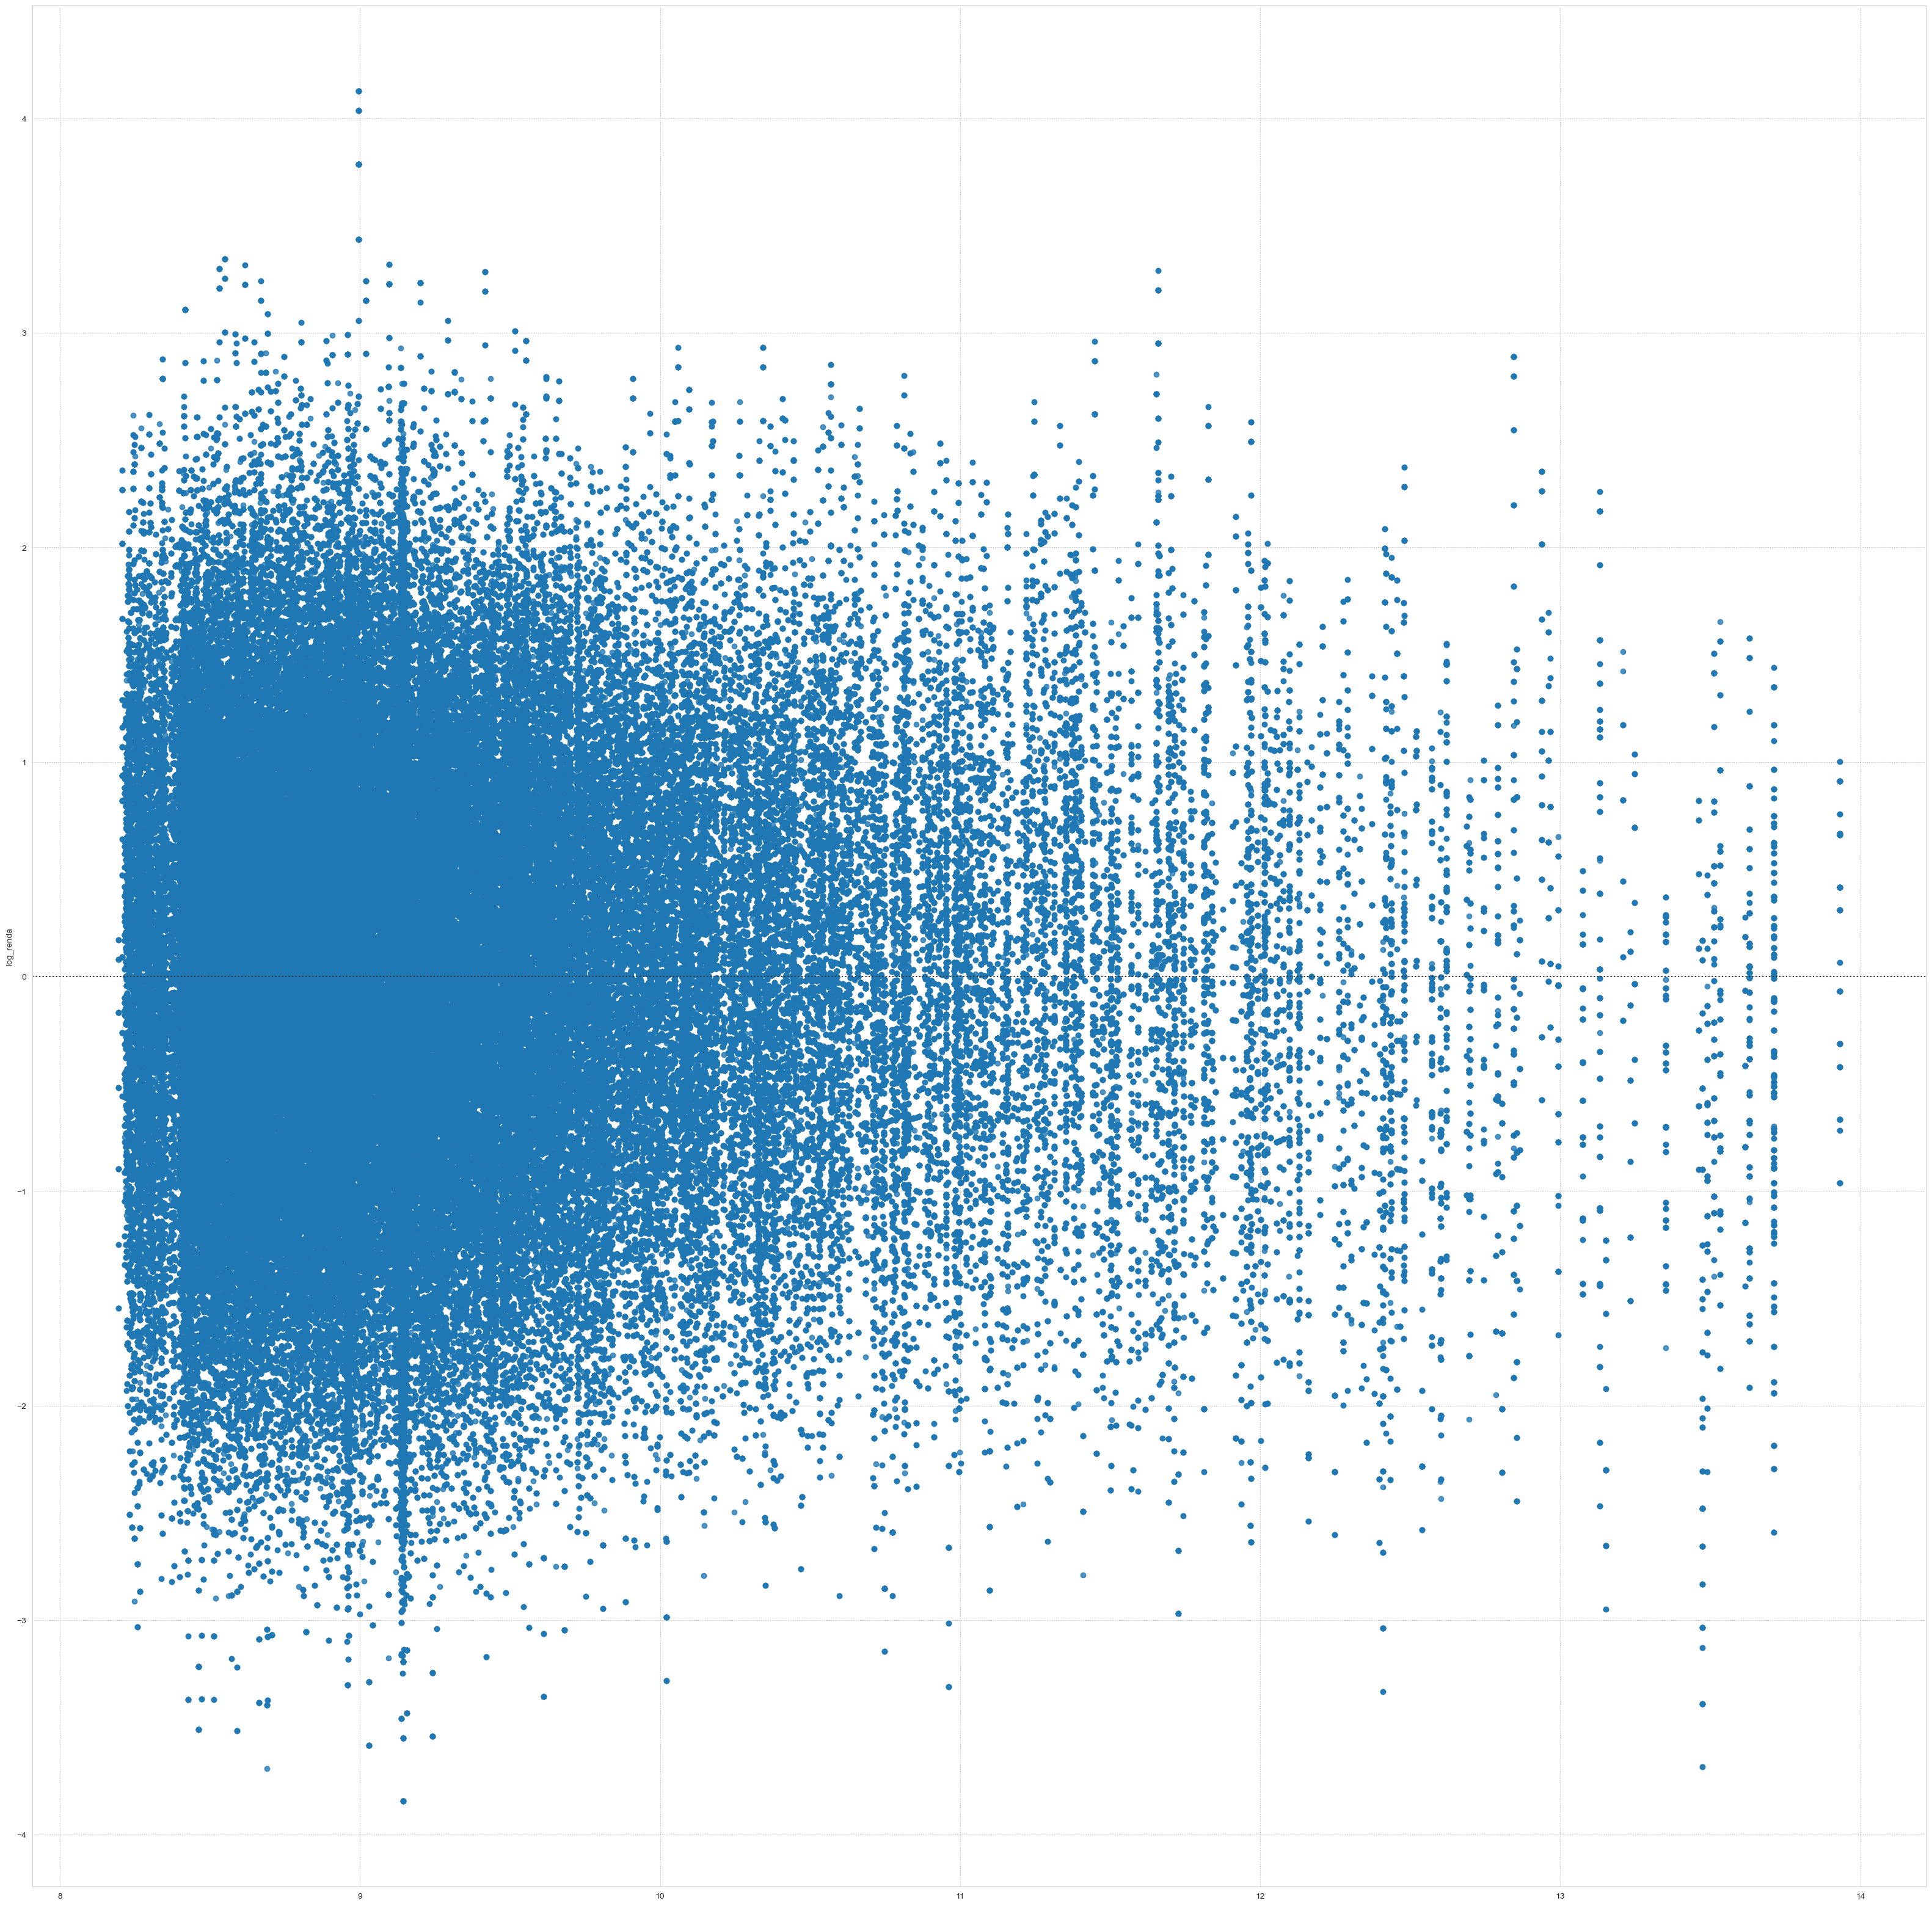

In [181]:
sns.residplot(x=res.predict(), y='log_renda', data=df_train)

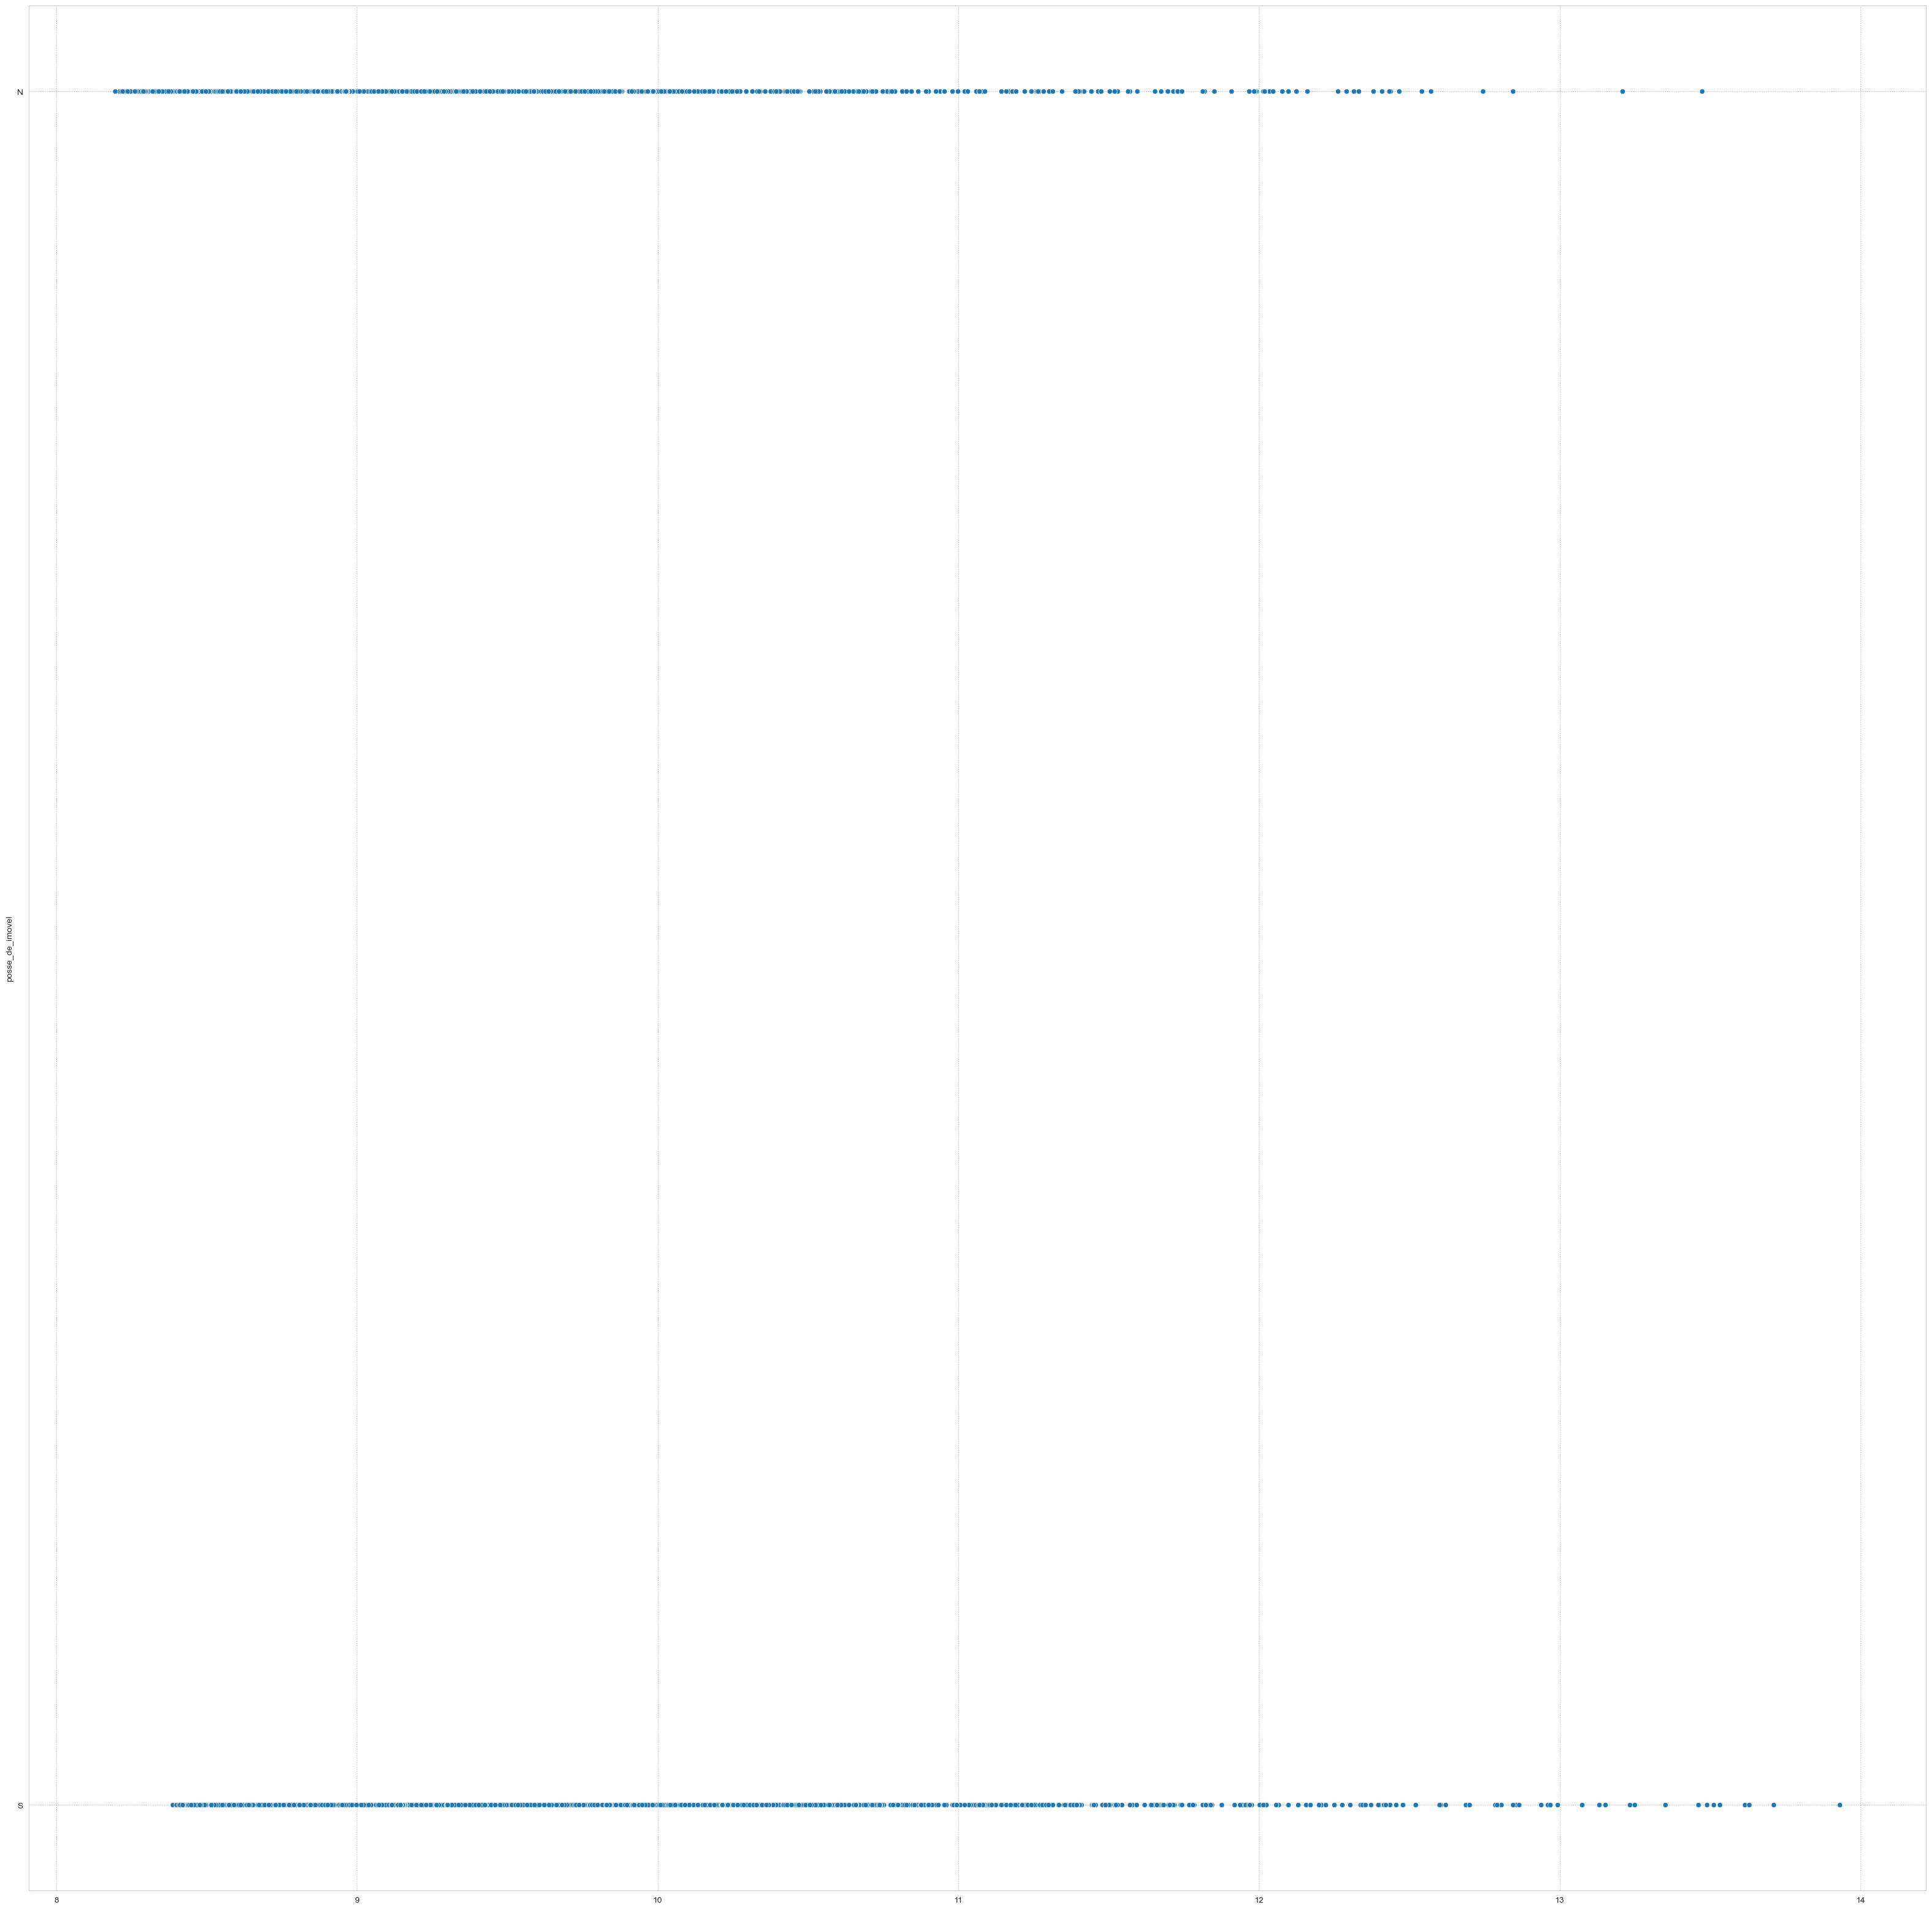

In [182]:
sns.scatterplot(x = res.predict(), y = 'posse_de_imovel', data=df_train);


### Outliers

Avaliar os studentized residuals e verificar se há pontos que parecem ser discrepantes.

In [183]:
df_train_short = df_train[:'2015-02-01']
df_train_short.reset_index(inplace=True)
df_train_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               100000 non-null  datetime64[ns]
 1   index                  100000 non-null  int64         
 2   sexo                   100000 non-null  object        
 3   posse_de_veiculo       100000 non-null  object        
 4   posse_de_imovel        100000 non-null  object        
 5   qtd_filhos             100000 non-null  int64         
 6   tipo_renda             100000 non-null  object        
 7   educacao               100000 non-null  object        
 8   estado_civil           100000 non-null  object        
 9   tipo_residencia        100000 non-null  object        
 10  idade                  100000 non-null  int64         
 11  tempo_emprego          100000 non-null  float64       
 12  qt_pessoas_residencia  100000 non-null  float

In [184]:
reg = smf.ols('log_renda ~ tempo_emprego', data=df_train_short).fit()

### Multicolinearidade

Avaliar se há questões relacionadas a multicolinearidade.

In [185]:
df_train_cut = df_train[['idade', 'tempo_emprego', 'log_renda']]

df_train_cut.head()

idade  tempo_emprego  log_renda
data_ref                                   
2015-01-01     47      16.717808   9.318131
2015-01-01     30       9.600000   7.793508
2015-01-01     28       8.208219   9.528769
2015-01-01     44       1.301370   7.767196
2015-01-01     33       1.254795   6.673020

In [186]:
df_train_cut.corr()

idade  tempo_emprego  log_renda
idade          1.000000       0.186305   0.123649
tempo_emprego  0.186305       1.000000   0.652057
log_renda      0.123649       0.652057   1.000000

In [187]:
df_train_cut.corr(method='spearman')

idade  tempo_emprego  log_renda
idade          1.000000       0.201228   0.113378
tempo_emprego  0.201228       1.000000   0.541167
log_renda      0.113378       0.541167   1.000000

In [188]:
variaveis = ['tempo_emprego', 'log_renda']

dum = pd.get_dummies(df_train_cut[variaveis], drop_first=True)
dum.head(2)

tempo_emprego  log_renda
data_ref                            
2015-01-01      16.717808   9.318131
2015-01-01       9.600000   7.793508

In [189]:
vif(dum.values, 1)

3.051133505604778

In [190]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(dum, i) for i in range(dum.shape[1])]
vars_vif["Feature"] = dum.columns

vars_vif.round(2)

VIF Factor        Feature
0        3.05  tempo_emprego
1        3.05      log_renda

## Conclusões

Com a execução deste trabalho pude não apenas aprender muito, como também organaizar dados e deixá-los mais legíveis para as pessoas. Após toda a curadoria desses dados pude chegar as seguintes conclusões:

   * A "Renda" é o fator mais definitivo na hora de criar correlações. Através dela apenas, já podemos presumir se esse cliente possui casa, veículo e até mesmo seu nível de educação. Porém existem dados que podem alterar uma conclusão superficial, por isso não dá para deduzir tudo através dela.

   * O número de filhos e quantidade de pessoas por residência são fatores que afetam muito a renda. Quanto maior eles forem, maior será a distribuição dessa renda, logo os gastos desse cliente são maiores.

   * A idade também é um dado muito relacionado a renda. Clientes entre 45 e 60 anos têm as melhores rendas.

* O nível de educação e tipo de emprego estão relacionados a renda também. Notamos que clientes com Ensino Superior Completo têm uma renda alta, assim como assalariados e empresários têm maior poder aquisitivo.

* O tempo de emprego se relaciona a renda. Pode-se notar que quanto maior o tempo, maior a renda.

* Nota-se que boa parte dos clientes têm residêcia e veículo

* A maior parte dos clientes é casada

* A maior parte dos clientes é do sexo feminino

* A maioria dos clientes são assalariados

* A maioria dos cliente têm Ensino Médio completo

* Quanto maior a renda, maior chance desse cliente ter uma residência e um veículo

* A maioria dos clientes são bons pagadores